# Neural Network (Supervised - Lag Shifting) Time Series Analysis

This section treats the envisaged dataset as a time series problem. Proposed techniques / methodology here is to:
* Covert the featured label into a discrete column value type, instead of continuous.
* Time Shift the provided datasets with varied 'lag' values.
* Combine all 3 matrices into a agglomorated matrix of 61 + 162 + 1179 features (1402). Duplicate columns ('SNAP_ID') will be reduced to a single one.
* Perform normalization on the data.
* Perform Feature Selction on the dataset by selecting and retaining 1/4 of the total features. (Multivariate analysis - through a Random Forest Ensemble Elimination approach)
* Perform Feature Decomposition on the dataset by decomposing those selected features into a smaller number of components
* Slicing agglomorated matrix into Features/Labels.
* Splitting of train/validation/test set.
* Feed dataset into a number of machine learning models.

A Many to Many approach is opted for in this experiment. The following experiment is trained on a number (greater than 1) of past sequences (t-lag), and all used to train and later predict a number of (t+lag) sequences.

Applicable links:
* https://machinelearningmastery.com/multi-step-time-series-forecasting/
* https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/
* https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
* https://machinelearningmastery.com/crash-course-recurrent-neural-networks-deep-learning/
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
* https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

### Module Installation and Importing Libraries

* https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/
* https://vertexai-plaidml.readthedocs-hosted.com/en/latest/installing.html

In [1]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
# pandas
import pandas as pd
from pandas.plotting import lag_plot
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import sklearn as sk
print('sklearn: %s' % sk.__version__)
# theano
import theano
print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# plaidml keras
import plaidml.keras
plaidml.keras.install_backend()
# keras
import keras as ke
print('keras: %s' % ke.__version__)
# math
import math
import csv
import os.path
import time

scipy: 1.1.0
numpy: 1.15.4
pandas: 0.23.4
statsmodels: 0.9.0
sklearn: 0.20.2
theano: 1.0.3
tensorflow: 1.11.0
keras: 2.2.4


### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment. 
NB: This experiment demonstrates at time  step = 1 (1 minute in advance). Further down in experiment, other timestep results are also featured and evaluated.

In [2]:
# Experiment Config
tpcds='TPCDS1' # Schema upon which to operate test
lag=12 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
if lag < 1:
    raise ValueError('Lag value must be greater than 1!')
nrows=None
bin_value = 2
if bin_value < 2:
    raise ValueError('Number of buckets must be greater than 1')
test_split=.5 # Denotes which Data Split to operate under when it comes to training / validation
sub_sample_start=350 # Denotes frist 0..n samples (Used for plotting purposes)
y_label = ['CPU_TIME_DELTA', 'IOWAIT_DELTA'] # Denotes which label to use for time series experiments

# Feature Selection
parallel_degree = -1
n_estimators=100

# LSTM Network Structure
epochs=600
batch=32
activation='sigmoid'
initializer='uniform'
dropout=0
layer=2

### Read data from file into Pandas Dataframes

In [3]:
# Root path
#root_dir = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds
root_dir = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds

# Open Data
rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = root_dir + '/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = root_dir + '/rep_hist_sysstat.csv'
#rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'
#rep_hist_sysmetric_summary_path = root_dir + '/rep_hist_sysmetric_summary.csv'
#rep_hist_sysstat_path = root_dir + '/rep_hist_sysstat.csv'

rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path, nrows=nrows)
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path, nrows=nrows)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path, nrows=nrows)

def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list

rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_df.columns = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)

print(rep_hist_snapshot_df.columns.values)
print(rep_hist_sysmetric_summary_df.columns.values)
print(rep_hist_sysstat_df.columns.values)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'SQL_ID' 'PLAN_HASH_VALUE'
 'OPTIMIZER_COST' 'OPTIMIZER_MODE' 'OPTIMIZER_ENV_HASH_VALUE'
 'SHARABLE_MEM' 'LOADED_VERSIONS' 'VERSION_COUNT' 'MODULE' 'ACTION'
 'SQL_PROFILE' 'FORCE_MATCHING_SIGNATURE' 'PARSING_SCHEMA_ID'
 'PARSING_SCHEMA_NAME' 'PARSING_USER_ID' 'FETCHES_TOTAL' 'FETCHES_DELTA'
 'END_OF_FETCH_COUNT_TOTAL' 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL'
 'SORTS_DELTA' 'EXECUTIONS_TOTAL' 'EXECUTIONS_DELTA'
 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA' 'LOADS_TOTAL'
 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROCESSED_TOTAL' 'ROWS_PROCESSED_DELTA' 'CPU_TIME_TOTAL'
 'CPU_TIME_DELTA' 'ELAPSED_TIME_TOTAL' 'ELAPSED_TIME_DELTA' 'IOWAIT_TOTAL'
 'IOWAIT_DELTA' 'CLWAIT_TOTAL' 'CLWAIT_DELTA' 'APWAIT_TOTAL'
 'APWAIT_DELTA' 'CCWAIT_TOTAL' 'CCWAIT_DELTA' 'DIRECT_WRITES_TOTAL'
 'DIRECT_WRITES_DELTA' 'PLSEXEC_TIME_T

### Pivoting Tables and Changing Matrix Shapes

Changes all dataframe shapes to be similar to each other, where in a number of snap_id timestamps are cojoined with instance metrics.

In [4]:
print('Header Lengths [Before Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# Table REP_HIST_SYSMETRIC_SUMMARY
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.pivot(index='SNAP_ID', columns='METRIC_NAME', values='AVERAGE')
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df[['SNAP_ID']] = rep_hist_sysmetric_summary_df[['SNAP_ID']].astype(int)
#rep_hist_sysmetric_summary_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
#rep_hist_sysstat_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

rep_hist_sysmetric_summary_df.rename(str.upper, inplace=True, axis='columns')
rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')

# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID','DBID','INSTANCE_NUMBER']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)

print('\nHeader Lengths [After Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# DF Shape
print('\nDataframe shapes:\nTable [REP_HIST_SNAPSHOT] - ' + str(rep_hist_snapshot_df.shape))
print('Table [REP_HIST_SYSMETRIC_SUMMARY] - ' + str(rep_hist_sysmetric_summary_df.shape))
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape))

Header Lengths [Before Pivot]
REP_HIST_SNAPSHOT: 90
REP_HIST_SYSMETRIC_SUMMARY: 26
REP_HIST_SYSSTAT: 16

Header Lengths [After Pivot]
REP_HIST_SNAPSHOT: 77
REP_HIST_SYSMETRIC_SUMMARY: 163
REP_HIST_SYSSTAT: 1180

Dataframe shapes:
Table [REP_HIST_SNAPSHOT] - (19831, 77)
Table [REP_HIST_SYSMETRIC_SUMMARY] - (19831, 163)
Table [REP_HIST_SYSSTAT] - (19831, 1180)


### Dealing with Empty Values

In [5]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list

print('N/A Columns\n')
print('\n REP_HIST_SNAPSHOT Features ' + str(len(rep_hist_snapshot_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_df.columns)) + "\n")
print('REP_HIST_SYSMETRIC_SUMMARY Features ' + str(len(rep_hist_sysmetric_summary_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_df.columns)) + "\n")
print('REP_HIST_SYSSTAT Features ' + str(len(rep_hist_sysstat_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_df.columns)) + "\n")

# Populating NaN values with amount '0'
rep_hist_snapshot_df = rep_hist_snapshot_df.fillna(0)
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.fillna(0)
rep_hist_sysstat_df = rep_hist_sysstat_df.fillna(0)

N/A Columns


 REP_HIST_SNAPSHOT Features 77: []

REP_HIST_SYSMETRIC_SUMMARY Features 163: ['ACTIVE PARALLEL SESSIONS', 'ACTIVE SERIAL SESSIONS', 'AVERAGE ACTIVE SESSIONS', 'AVERAGE SYNCHRONOUS SINGLE-BLOCK READ LATENCY', 'BACKGROUND CPU USAGE PER SEC', 'BACKGROUND TIME PER SEC', 'CAPTURED USER CALLS', 'CELL PHYSICAL IO INTERCONNECT BYTES', 'HOST CPU USAGE PER SEC', 'I/O MEGABYTES PER SECOND', 'I/O REQUESTS PER SECOND', 'PX OPERATIONS NOT DOWNGRADED PER SEC', 'REPLAYED USER CALLS', 'RUN QUEUE PER SEC', 'SESSION COUNT', 'TEMP SPACE USED', 'TOTAL PGA ALLOCATED', 'TOTAL PGA USED BY SQL WORKAREAS', 'VM IN BYTES PER SEC', 'VM OUT BYTES PER SEC', 'WORKLOAD CAPTURE AND REPLAY STATUS']

REP_HIST_SYSSTAT Features 1180: ['BA SPARE STATISTIC 9', 'CLI FLSTASK CREATE', 'EHCC COMPRESSED LENGTH COMPRESSED', 'EFFECTIVE IO TIME', 'FORWARDED 2PC COMMANDS ACROSS RAC NODES', 'IM POPULATE (FASTSTART) CUS READ ATTEMPTS', 'IM POPULATE CUS MEMCOMPRESS FOR CAPACITY LOW', 'IM REPOPULATE (TRICKLE) CUS MEMCOMPRES

### Merging Frames

This part merges the following pandas data frame into a single frame:
* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* REP_HIST_SYSSTAT

In [6]:
df = pd.merge(rep_hist_snapshot_df, rep_hist_sysmetric_summary_df,how='inner',on ='SNAP_ID')
df = pd.merge(df, rep_hist_sysstat_df,how='inner',on ='SNAP_ID')
print(df.shape)
print('----------------------------------')
print(df.columns.tolist())

(19831, 1418)
----------------------------------
['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'PLAN_HASH_VALUE', 'OPTIMIZER_COST', 'OPTIMIZER_ENV_HASH_VALUE', 'SHARABLE_MEM', 'LOADED_VERSIONS', 'VERSION_COUNT', 'SQL_PROFILE', 'PARSING_SCHEMA_ID', 'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA', 'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL', 'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA', 'PARSE_CALLS_TOTAL', 'PARSE_CALLS_DELTA', 'DISK_READS_TOTAL', 'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA', 'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL', 'CPU_TIME_DELTA', 'ELAPSED_TIME_TOTAL', 'ELAPSED_TIME_DELTA', 'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWAIT_DELTA', 'APWAIT_TOTAL', 'APWAIT_DELTA', 'CCWAIT_TOTAL', 'CCWAIT_DELTA', 'DIRECT_WRITES_TOTAL', 'DIRECT_WRITES_DELTA', 'PLSEXEC_TIME_TOTAL', 'PLS

### Data Ordering

Sorting of datasets in order of SNAP_ID.

In [7]:
df.sort_values(by=['SNAP_ID'], ascending=True, inplace=True)
print(df.shape)

(19831, 1418)


### Floating point precision conversion

Each column is converted into a column of type values which are floating point for higher precision.

In [8]:
df.astype('float32', inplace=True)
df = np.round(df, 3) # rounds to 3 dp
print(df.shape)

(19831, 1418)


### Redundant Feature Removal
In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [9]:
def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    
    print('\nShape before changes: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after changes: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df

print('Before column drop:')
print(df.shape)
df = drop_flatline_columns(df=df)
print('\nAfter flatline column drop:')
print(df.shape)
dropped_columns_df = [ 'PLAN_HASH_VALUE',
                       'OPTIMIZER_ENV_HASH_VALUE',
                       'LOADED_VERSIONS',
                       'VERSION_COUNT',
                       'PARSING_SCHEMA_ID',
                       'PARSING_USER_ID',
                       'CON_DBID',
                       'SNAP_LEVEL',
                       'SNAP_FLAG',
                       'COMMAND_TYPE']
df.drop(columns=dropped_columns_df, inplace=True)
print('\nAfter additional column drop:')
print(df.shape)

Before column drop:
(19831, 1418)

Shape before changes: [(19831, 1418)]
Shape after changes: [(19831, 521)]
Dropped a total [897]

After flatline column drop:
(19831, 521)

After additional column drop:
(19831, 511)


## Visualizing Labels

https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

### Histograms

A simple and commonly used plot to quickly check the distribution of a sample of data is the histogram.

In the histogram, the data is divided into a pre-specified number of groups called bins. The data is then sorted into each bin and the count of the number of observations in each bin is retained.

The plot shows the bins across the x-axis maintaining their ordinal relationship, and the count in each bin on the y-axis.

A sample of data has a Gaussian distribution of the histogram plot, showing the familiar bell shape.

### Quantile-Quantile Plot

Another popular plot for checking the distribution of a data sample is the quantile-quantile plot, Q-Q plot, or QQ plot for short.

This plot generates its own sample of the idealized distribution that we are comparing with, in this case the Gaussian distribution. The idealized samples are divided into groups (e.g. 5), called quantiles. Each data point in the sample is paired with a similar member from the idealized distribution at the same cumulative distribution.

The resulting points are plotted as a scatter plot with the idealized value on the x-axis and the data sample on the y-axis.

A perfect match for the distribution will be shown by a line of dots on a 45-degree angle from the bottom left of the plot to the top right. Often a line is drawn on the plot to help make this expectation clear. Deviations by the dots from the line shows a deviation from the expected distribution.

### Shapiro-Wilk Test

The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution, named for Samuel Shapiro and Martin Wilk.

In practice, the Shapiro-Wilk test is believed to be a reliable test of normality, although there is some suggestion that the test may be suitable for smaller samples of data, e.g. thousands of observations or fewer.

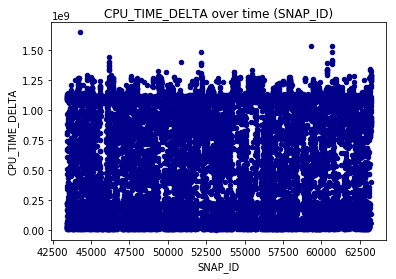

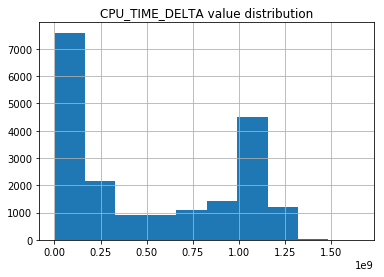

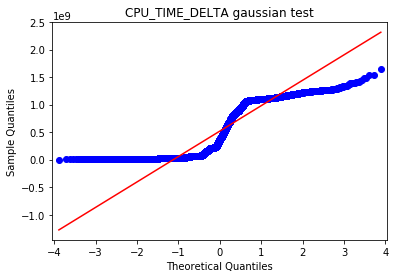

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=0.827, p=0.000
Sample does not look Gaussian (reject H0)


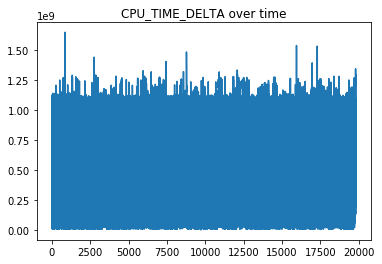

---------------------------------------------------------------


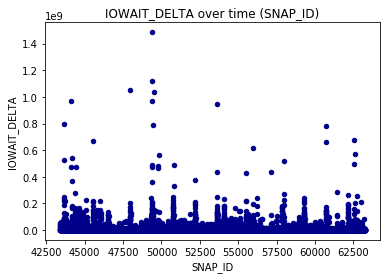

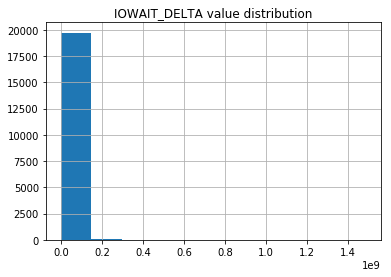

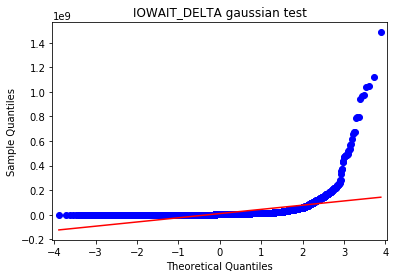

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=0.207, p=0.000
Sample does not look Gaussian (reject H0)


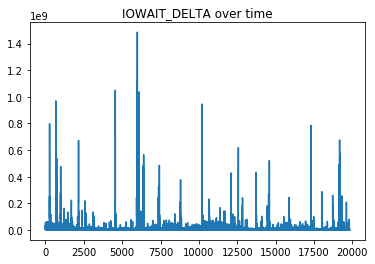

---------------------------------------------------------------


In [10]:
def shapiro_wilk(data):
    # normality test
    stat, p = sc.stats.shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

for label in y_label:
    
    df.plot.scatter(x='SNAP_ID',
                    y=label,
                    c='DarkBlue')
    plt.title(label + " over time (SNAP_ID)")
    plt.show()
    
    df[label].hist(bins=10)
    plt.title(label + ' value distribution')
    plt.show()
    
    qqplot(df[label], line='s')
    plt.title(label + ' gaussian test')
    plt.show()
    
    shapiro_wilk(data=df[label])
    
    df[label].plot.line()
    plt.title(label + ' over time')
    plt.show()
    print('---------------------------------------------------------------')

### Outlier Detection - Standard Deviation Method

Detection and transformation of outliers, categorized as more than 3 standard deviations away.

If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers.

The Gaussian distribution has the property that the standard deviation from the mean can be used to reliably summarize the percentage of values in the sample.

For example, within one standard deviation of the mean will cover 68% of the data.

So, if the mean is 50 and the standard deviation is 5, as in the test dataset above, then all data in the sample between 45 and 55 will account for about 68% of the data sample. We can cover more of the data sample if we expand the range as follows:

* 1 Standard Deviation from the Mean: 68%
* 2 Standard Deviations from the Mean: 95%
* 3 Standard Deviations from the Mean: 99.7%

A value that falls outside of 3 standard deviations is part of the distribution, but it is an unlikely or rare event at approximately 1 in 370 samples.

Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

More infor here: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Outlier detected for column [IOWAIT_DELTA] at location [0] with value [30637665.0]
Outlier detected for column [IOWAIT_DELTA] at location [7] with value [45906216.0]
Outlier detected for column [IOWAIT_DELTA] at location [8] with value [54738912.0]
Outlier detected for column [IOWAIT_DELTA] at location [9] with value [38384072.0]
Outlier detected for column [IOWAIT_DELTA] at location [15] with value [23097556.0]
Outlier detected for column [IOWAIT_DELTA] at location [19] with value [25811806.0]
Outlier detected for column [IOWAIT_DELTA] at location [20] with value [54155590.0]
Outlier detected for column [IOWAIT_DELTA] at location [21] with value [45285285.0]
Outlier detected for column [IOWAIT_DELTA] at location [27] with value [26206268.0]
Outlier detected for column [IOWAIT_DELTA] at location [28] with value [23831069.0]
Outlier detected for column [IOWAIT_DELTA] at location [32] with value [54160781.0]
Outlier detected for column [IOWAIT_DELTA] at location [33] with value [45329000

Outlier detected for column [IOWAIT_DELTA] at location [280] with value [24691307.0]
Outlier detected for column [IOWAIT_DELTA] at location [284] with value [219027741.0]
Outlier detected for column [IOWAIT_DELTA] at location [292] with value [42564981.0]
Outlier detected for column [IOWAIT_DELTA] at location [293] with value [35615606.0]
Outlier detected for column [IOWAIT_DELTA] at location [297] with value [39828311.0]
Outlier detected for column [IOWAIT_DELTA] at location [304] with value [31852770.0]
Outlier detected for column [IOWAIT_DELTA] at location [305] with value [33503446.0]
Outlier detected for column [IOWAIT_DELTA] at location [316] with value [23138767.0]
Outlier detected for column [IOWAIT_DELTA] at location [317] with value [38521031.0]
Outlier detected for column [IOWAIT_DELTA] at location [329] with value [45264203.0]
Outlier detected for column [IOWAIT_DELTA] at location [342] with value [52807177.0]
Outlier detected for column [IOWAIT_DELTA] at location [343] wit

Outlier detected for column [IOWAIT_DELTA] at location [797] with value [23259754.0]
Outlier detected for column [IOWAIT_DELTA] at location [810] with value [26992562.0]
Outlier detected for column [IOWAIT_DELTA] at location [818] with value [29430675.0]
Outlier detected for column [IOWAIT_DELTA] at location [819] with value [23372921.0]
Outlier detected for column [IOWAIT_DELTA] at location [822] with value [26413818.0]
Outlier detected for column [IOWAIT_DELTA] at location [830] with value [45850399.0]
Outlier detected for column [IOWAIT_DELTA] at location [831] with value [42564118.0]
Outlier detected for column [IOWAIT_DELTA] at location [835] with value [33775548.0]
Outlier detected for column [IOWAIT_DELTA] at location [843] with value [36307392.0]
Outlier detected for column [IOWAIT_DELTA] at location [855] with value [47909865.0]
Outlier detected for column [IOWAIT_DELTA] at location [856] with value [36331548.0]
Outlier detected for column [IOWAIT_DELTA] at location [867] with

Outlier detected for column [IOWAIT_DELTA] at location [2153] with value [147992385.0]
Outlier detected for column [IOWAIT_DELTA] at location [2154] with value [101894672.0]
Outlier detected for column [IOWAIT_DELTA] at location [2155] with value [71986776.0]
Outlier detected for column [IOWAIT_DELTA] at location [2156] with value [88668083.0]
Outlier detected for column [IOWAIT_DELTA] at location [2157] with value [212822765.0]
Outlier detected for column [IOWAIT_DELTA] at location [2158] with value [672456673.0]
Outlier detected for column [IOWAIT_DELTA] at location [2159] with value [144210745.0]
Outlier detected for column [IOWAIT_DELTA] at location [2160] with value [80170114.0]
Outlier detected for column [IOWAIT_DELTA] at location [2161] with value [125755675.0]
Outlier detected for column [IOWAIT_DELTA] at location [2162] with value [141088262.0]
Outlier detected for column [IOWAIT_DELTA] at location [2163] with value [93583977.0]
Outlier detected for column [IOWAIT_DELTA] at l

Outlier detected for column [IOWAIT_DELTA] at location [5943] with value [111070053.0]
Outlier detected for column [IOWAIT_DELTA] at location [5944] with value [80884501.0]
Outlier detected for column [IOWAIT_DELTA] at location [5945] with value [111737564.0]
Outlier detected for column [IOWAIT_DELTA] at location [5946] with value [116300331.0]
Outlier detected for column [IOWAIT_DELTA] at location [5947] with value [157460381.0]
Outlier detected for column [IOWAIT_DELTA] at location [5948] with value [159658448.0]
Outlier detected for column [IOWAIT_DELTA] at location [5949] with value [167731621.0]
Outlier detected for column [IOWAIT_DELTA] at location [5950] with value [112180376.0]
Outlier detected for column [IOWAIT_DELTA] at location [5951] with value [38991184.0]
Outlier detected for column [IOWAIT_DELTA] at location [5952] with value [57357758.0]
Outlier detected for column [IOWAIT_DELTA] at location [5953] with value [40784347.0]
Outlier detected for column [IOWAIT_DELTA] at l

Outlier detected for column [IOWAIT_DELTA] at location [7057] with value [36316316.0]
Outlier detected for column [IOWAIT_DELTA] at location [7069] with value [34890723.0]
Outlier detected for column [IOWAIT_DELTA] at location [7081] with value [24102560.0]
Outlier detected for column [IOWAIT_DELTA] at location [7092] with value [26094906.0]
Outlier detected for column [IOWAIT_DELTA] at location [7093] with value [31472828.0]
Outlier detected for column [IOWAIT_DELTA] at location [7104] with value [29615279.0]
Outlier detected for column [IOWAIT_DELTA] at location [7105] with value [31533347.0]
Outlier detected for column [IOWAIT_DELTA] at location [7128] with value [27649853.0]
Outlier detected for column [IOWAIT_DELTA] at location [7129] with value [23909568.0]
Outlier detected for column [IOWAIT_DELTA] at location [7140] with value [41009464.0]
Outlier detected for column [IOWAIT_DELTA] at location [7141] with value [36806127.0]
Outlier detected for column [IOWAIT_DELTA] at location

Outlier detected for column [IOWAIT_DELTA] at location [8092] with value [28387128.0]
Outlier detected for column [IOWAIT_DELTA] at location [8102] with value [24253031.0]
Outlier detected for column [IOWAIT_DELTA] at location [8103] with value [52040555.0]
Outlier detected for column [IOWAIT_DELTA] at location [8104] with value [42387252.0]
Outlier detected for column [IOWAIT_DELTA] at location [8115] with value [28743419.0]
Outlier detected for column [IOWAIT_DELTA] at location [8127] with value [35067942.0]
Outlier detected for column [IOWAIT_DELTA] at location [8139] with value [40838935.0]
Outlier detected for column [IOWAIT_DELTA] at location [8152] with value [44432631.0]
Outlier detected for column [IOWAIT_DELTA] at location [8153] with value [36075919.0]
Outlier detected for column [IOWAIT_DELTA] at location [8164] with value [25870067.0]
Outlier detected for column [IOWAIT_DELTA] at location [8177] with value [29615194.0]
Outlier detected for column [IOWAIT_DELTA] at location

Outlier detected for column [IOWAIT_DELTA] at location [8857] with value [25741451.0]
Outlier detected for column [IOWAIT_DELTA] at location [8858] with value [44331780.0]
Outlier detected for column [IOWAIT_DELTA] at location [8859] with value [90908621.0]
Outlier detected for column [IOWAIT_DELTA] at location [8860] with value [44219118.0]
Outlier detected for column [IOWAIT_DELTA] at location [8861] with value [28290352.0]
Outlier detected for column [IOWAIT_DELTA] at location [9139] with value [45772156.0]
Outlier detected for column [IOWAIT_DELTA] at location [9180] with value [25340371.0]
Outlier detected for column [IOWAIT_DELTA] at location [9263] with value [54418068.0]
Outlier detected for column [IOWAIT_DELTA] at location [9405] with value [25623263.0]
Outlier detected for column [IOWAIT_DELTA] at location [9510] with value [26212352.0]
Outlier detected for column [IOWAIT_DELTA] at location [9538] with value [34170705.0]
Outlier detected for column [IOWAIT_DELTA] at location

Outlier detected for column [IOWAIT_DELTA] at location [10367] with value [27460482.0]
Outlier detected for column [IOWAIT_DELTA] at location [10368] with value [23402525.0]
Outlier detected for column [IOWAIT_DELTA] at location [10372] with value [67194480.0]
Outlier detected for column [IOWAIT_DELTA] at location [10373] with value [53410191.0]
Outlier detected for column [IOWAIT_DELTA] at location [10379] with value [30146515.0]
Outlier detected for column [IOWAIT_DELTA] at location [10380] with value [27482405.0]
Outlier detected for column [IOWAIT_DELTA] at location [10384] with value [65270275.0]
Outlier detected for column [IOWAIT_DELTA] at location [10385] with value [54531017.0]
Outlier detected for column [IOWAIT_DELTA] at location [10386] with value [35410482.0]
Outlier detected for column [IOWAIT_DELTA] at location [10392] with value [31576584.0]
Outlier detected for column [IOWAIT_DELTA] at location [10396] with value [52076390.0]
Outlier detected for column [IOWAIT_DELTA] 

Outlier detected for column [IOWAIT_DELTA] at location [10641] with value [42149190.0]
Outlier detected for column [IOWAIT_DELTA] at location [10645] with value [24771139.0]
Outlier detected for column [IOWAIT_DELTA] at location [10646] with value [117152111.0]
Outlier detected for column [IOWAIT_DELTA] at location [10648] with value [24060189.0]
Outlier detected for column [IOWAIT_DELTA] at location [10649] with value [34185930.0]
Outlier detected for column [IOWAIT_DELTA] at location [10653] with value [58637278.0]
Outlier detected for column [IOWAIT_DELTA] at location [10654] with value [60275428.0]
Outlier detected for column [IOWAIT_DELTA] at location [10655] with value [41764003.0]
Outlier detected for column [IOWAIT_DELTA] at location [10658] with value [39114269.0]
Outlier detected for column [IOWAIT_DELTA] at location [10661] with value [39936288.0]
Outlier detected for column [IOWAIT_DELTA] at location [10662] with value [25668874.0]
Outlier detected for column [IOWAIT_DELTA]

Outlier detected for column [IOWAIT_DELTA] at location [11166] with value [24401155.0]
Outlier detected for column [IOWAIT_DELTA] at location [11167] with value [26174951.0]
Outlier detected for column [IOWAIT_DELTA] at location [11171] with value [57171299.0]
Outlier detected for column [IOWAIT_DELTA] at location [11172] with value [46995440.0]
Outlier detected for column [IOWAIT_DELTA] at location [11183] with value [58333307.0]
Outlier detected for column [IOWAIT_DELTA] at location [11184] with value [46138180.0]
Outlier detected for column [IOWAIT_DELTA] at location [11185] with value [23598525.0]
Outlier detected for column [IOWAIT_DELTA] at location [11191] with value [23111548.0]
Outlier detected for column [IOWAIT_DELTA] at location [11195] with value [51223055.0]
Outlier detected for column [IOWAIT_DELTA] at location [11196] with value [50731775.0]
Outlier detected for column [IOWAIT_DELTA] at location [11197] with value [24603434.0]
Outlier detected for column [IOWAIT_DELTA] 

Outlier detected for column [IOWAIT_DELTA] at location [11543] with value [40013219.0]
Outlier detected for column [IOWAIT_DELTA] at location [11550] with value [24255768.0]
Outlier detected for column [IOWAIT_DELTA] at location [11554] with value [44569305.0]
Outlier detected for column [IOWAIT_DELTA] at location [11555] with value [47628649.0]
Outlier detected for column [IOWAIT_DELTA] at location [11556] with value [26298153.0]
Outlier detected for column [IOWAIT_DELTA] at location [11562] with value [25060439.0]
Outlier detected for column [IOWAIT_DELTA] at location [11566] with value [39585329.0]
Outlier detected for column [IOWAIT_DELTA] at location [11567] with value [51561919.0]
Outlier detected for column [IOWAIT_DELTA] at location [11568] with value [32889608.0]
Outlier detected for column [IOWAIT_DELTA] at location [11578] with value [29564541.0]
Outlier detected for column [IOWAIT_DELTA] at location [11579] with value [54139273.0]
Outlier detected for column [IOWAIT_DELTA] 

Outlier detected for column [IOWAIT_DELTA] at location [12294] with value [32221842.0]
Outlier detected for column [IOWAIT_DELTA] at location [12305] with value [31046988.0]
Outlier detected for column [IOWAIT_DELTA] at location [12306] with value [26713470.0]
Outlier detected for column [IOWAIT_DELTA] at location [12317] with value [33075505.0]
Outlier detected for column [IOWAIT_DELTA] at location [12318] with value [25431129.0]
Outlier detected for column [IOWAIT_DELTA] at location [12327] with value [26620744.0]
Outlier detected for column [IOWAIT_DELTA] at location [12328] with value [98904022.0]
Outlier detected for column [IOWAIT_DELTA] at location [12329] with value [73022183.0]
Outlier detected for column [IOWAIT_DELTA] at location [12330] with value [55124843.0]
Outlier detected for column [IOWAIT_DELTA] at location [12331] with value [37493886.0]
Outlier detected for column [IOWAIT_DELTA] at location [12365] with value [40038029.0]
Outlier detected for column [IOWAIT_DELTA] 

Outlier detected for column [IOWAIT_DELTA] at location [15403] with value [39893151.0]
Outlier detected for column [IOWAIT_DELTA] at location [15415] with value [38855679.0]
Outlier detected for column [IOWAIT_DELTA] at location [15416] with value [28795980.0]
Outlier detected for column [IOWAIT_DELTA] at location [15439] with value [32650371.0]
Outlier detected for column [IOWAIT_DELTA] at location [15451] with value [35743952.0]
Outlier detected for column [IOWAIT_DELTA] at location [15452] with value [25585886.0]
Outlier detected for column [IOWAIT_DELTA] at location [15463] with value [33412594.0]
Outlier detected for column [IOWAIT_DELTA] at location [15464] with value [25661157.0]
Outlier detected for column [IOWAIT_DELTA] at location [15475] with value [29040849.0]
Outlier detected for column [IOWAIT_DELTA] at location [15487] with value [38447137.0]
Outlier detected for column [IOWAIT_DELTA] at location [15488] with value [24958105.0]
Outlier detected for column [IOWAIT_DELTA] 

Outlier detected for column [IOWAIT_DELTA] at location [15888] with value [137125420.0]
Outlier detected for column [IOWAIT_DELTA] at location [15889] with value [104900706.0]
Outlier detected for column [IOWAIT_DELTA] at location [15890] with value [100476922.0]
Outlier detected for column [IOWAIT_DELTA] at location [15891] with value [55673988.0]
Outlier detected for column [IOWAIT_DELTA] at location [15892] with value [58166902.0]
Outlier detected for column [IOWAIT_DELTA] at location [15904] with value [47229563.0]
Outlier detected for column [IOWAIT_DELTA] at location [15923] with value [30781164.0]
Outlier detected for column [IOWAIT_DELTA] at location [15935] with value [23260798.0]
Outlier detected for column [IOWAIT_DELTA] at location [15943] with value [47975942.0]
Outlier detected for column [IOWAIT_DELTA] at location [15960] with value [45172398.0]
Outlier detected for column [IOWAIT_DELTA] at location [15961] with value [39435955.0]
Outlier detected for column [IOWAIT_DELT

Outlier detected for column [IOWAIT_DELTA] at location [19180] with value [199946685.0]
Outlier detected for column [IOWAIT_DELTA] at location [19191] with value [79376370.0]
Outlier detected for column [IOWAIT_DELTA] at location [19227] with value [49959071.0]
Outlier detected for column [IOWAIT_DELTA] at location [19317] with value [143907168.0]
Outlier detected for column [IOWAIT_DELTA] at location [19318] with value [74813016.0]
Outlier detected for column [IOWAIT_DELTA] at location [19322] with value [255478893.0]
Outlier detected for column [IOWAIT_DELTA] at location [19323] with value [24258174.0]
Outlier detected for column [IOWAIT_DELTA] at location [19335] with value [40713072.0]
Outlier detected for column [IOWAIT_DELTA] at location [19384] with value [24635163.0]
Outlier detected for column [IOWAIT_DELTA] at location [19396] with value [25562076.0]
Outlier detected for column [IOWAIT_DELTA] at location [19432] with value [29956477.0]
Outlier detected for column [IOWAIT_DELT

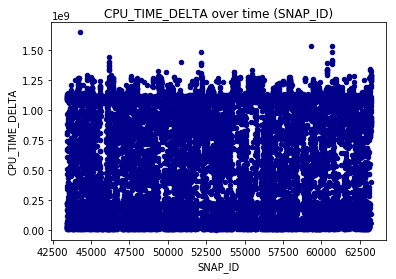

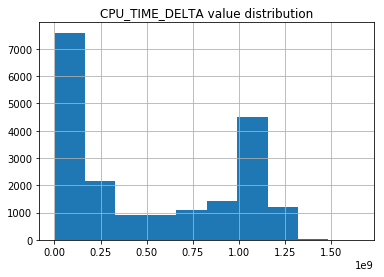

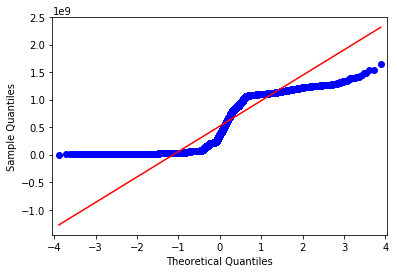

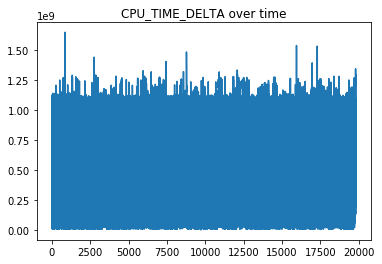

---------------------------------------------------------------


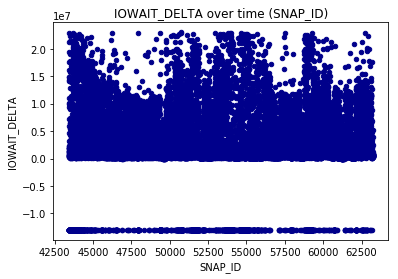

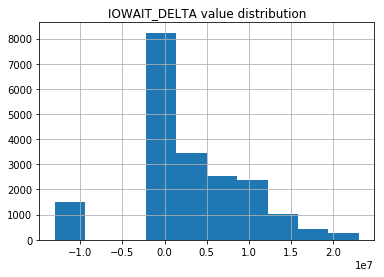

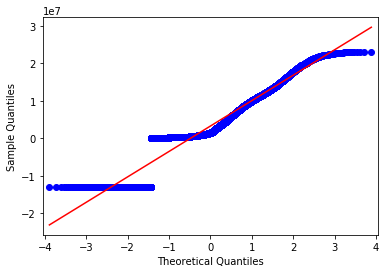

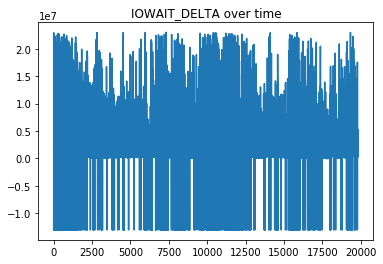

---------------------------------------------------------------


In [11]:
def detect_and_transform_outliers_zscore(df, threshold=3):
    """
    Iterates over input dataframe and transforms outliers (greater then 3 std threshold) into mean value
    
    :param: (Pandas 2D Matrix) Input dataframe
    :param: (Integer) Input standard deviation threshold - 3 equates to the .99% threshold
    """
    for col in df.columns:
        mean = np.mean(df[col])
        std = np.std(df[col])
        
        counter = 0
        for val in df[col]:
            z_score = (val - mean) / std
            if np.abs(z_score) > threshold:
                df[col].iloc[counter] = mean
                print('Outlier detected for column [' + col + '] at location [' + str(counter) + '] with value [' + str(val) + ']')
            counter += 1
                
    return df

def detect_and_transform_outliers_iqr(df):
    """
    Iterates over input dataframe and transforms outliers (greater then 3 std threshold) into mean value
    
    :param: (Pandas 2D Matrix) Input dataframe
    :param: (Integer) Input standard deviation threshold - 3 equates to the .99% threshold
    """
    for col in df.columns:
        quartile_1, quartile_3 = np.percentile(df.values, [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        
        counter = 0
        for val in df[col]:
            if (val > upper_bound) or (val < lower_bound):
                df[col].iloc[counter] = lower_bound
                print('Outlier detected for column [' + col + '] at location [' + str(counter) + '] with value [' + str(val) + ']')
            counter += 1
                
    return df

df[[y_label[0]]] = detect_and_transform_outliers_zscore(df=df[[y_label[0]]])
df[[y_label[1]]] = detect_and_transform_outliers_iqr(df=df[[y_label[1]]])

for label in y_label:
    
    df.plot.scatter(x='SNAP_ID',
                    y=label,
                    c='DarkBlue')
    plt.title(label + " over time (SNAP_ID)")
    plt.show()
    
    df[label].hist(bins=10)
    plt.title(label + ' value distribution')
    plt.show()
    
    qqplot(df[label], line='s')
    plt.show()
    
    df[label].plot.line()
    plt.title(label + ' over time')
    plt.show()
    print('---------------------------------------------------------------')

### Normalization

Relavent Sources:

* http://jmlr.csail.mit.edu/papers/volume3/guyon03a/guyon03a.pdf
* https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a normalization preprocessing technique for data distribution that can closely approximate minimum and maximum observable values per column:

<i>"Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data. If your time series is trending up or down, estimating these expected values may be difficult and normalization may not be the best method to use on your problem."</i>

Normalization formula is stated as follows: $$y=(x-min)/(max-min)$$

### Standardization

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a standardization preprocessing technique for data distributions that observe a Gaussian spread, with a mean of 0 and a standard deviation of 1 (approximately close to these values):

<i>"Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. You can still standardize your time series data if this expectation is not met, but you may not get reliable results."</i>

Standardization formula is stated as follows: $$y=(x-mean)/StandardDeviation$$
Mean defined as: $$mean=sum(x)/count(x)$$
Standard Deviation defined as: $$StandardDeviation=sqrt(sum((x-mean)^2)/count(x))$$

In [12]:
# MINMAX SCALER
train, test = train_test_split(df, test_size=0.5)
trainheaders = train.columns
testheaders = test.columns
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)
train = pd.DataFrame(train, columns=trainheaders)
test = pd.DataFrame(test, columns=testheaders)
df = train.append(test, ignore_index=True)

print(df.shape)
print(df.head())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(19831, 511)
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FETCHES_TOTAL  FETCHES_DELTA  \
0  0.144205    6.347719e-02      0.488779       0.341005       0.158269   
1  0.798699    6.303635e-02      0.724805       0.844868       0.263104   
2  0.340059    6.060863e-02      0.130299       0.499967       0.089096   
3  0.847221    6.380774e-10      0.471386       0.782225       0.041538   
4  0.145314    6.347719e-02      0.511737       0.340892       0.154094   

   END_OF_FETCH_COUNT_TOTAL  END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  \
0                  0.387292                  0.277188     0.327930   
1                  0.538876                  0.467543     0.847810   
2                  0.567914                  0.179845     0.475886   
3                  0.357648                  0.046004     0.014903   
4                  0.387375                  0.269529     0.326178   

   SORTS_DELTA  EXECUTIONS_TOTAL                 ...                  \
0     0.248148          0.392613           

### Split Train Test

Splits dataset into training and validation subsets

In [13]:
y_df = df[y_label]
X_df = df
print("Label " + str(y_label) + " shape: " + str(y_df.shape))
print("Feature matrix shape: " + str(X_df.shape))
print(X_df.head())

Label ['CPU_TIME_DELTA', 'IOWAIT_DELTA'] shape: (19831, 2)
Feature matrix shape: (19831, 511)
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FETCHES_TOTAL  FETCHES_DELTA  \
0  0.144205    6.347719e-02      0.488779       0.341005       0.158269   
1  0.798699    6.303635e-02      0.724805       0.844868       0.263104   
2  0.340059    6.060863e-02      0.130299       0.499967       0.089096   
3  0.847221    6.380774e-10      0.471386       0.782225       0.041538   
4  0.145314    6.347719e-02      0.511737       0.340892       0.154094   

   END_OF_FETCH_COUNT_TOTAL  END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  \
0                  0.387292                  0.277188     0.327930   
1                  0.538876                  0.467543     0.847810   
2                  0.567914                  0.179845     0.475886   
3                  0.357648                  0.046004     0.014903   
4                  0.387375                  0.269529     0.326178   

   SORTS_DELTA  EXECUTIONS_TOTAL  

### Lag and Autocorrelation Analysis

This section checks for potential autocorrelation within the presented time series. Three seperate plots are layed out as follows:

* Plot 1 - Lag plot denoting correlation between time lag 0 and time lag 1.
* Plot 2 - Auto correlation plot denoting time series correlation over a number of lag values
* Plot 3 - Auto correlation plot denoting time series correlation up till lag value 100. This achieves a much more closer look towards the first 100 lag correlations for the time series, achieving a more detailed plot.
Relavent sources:

* http://pandasplotting.blogspot.com/2012/06/autocorrelation-plot.html
* https://pandas.pydata.org/pandas-docs/stable/visualization.html
* https://machinelearningmastery.com/time-series-data-visualization-with-python/

Label - [CPU_TIME_DELTA]


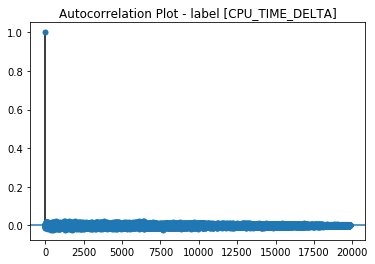

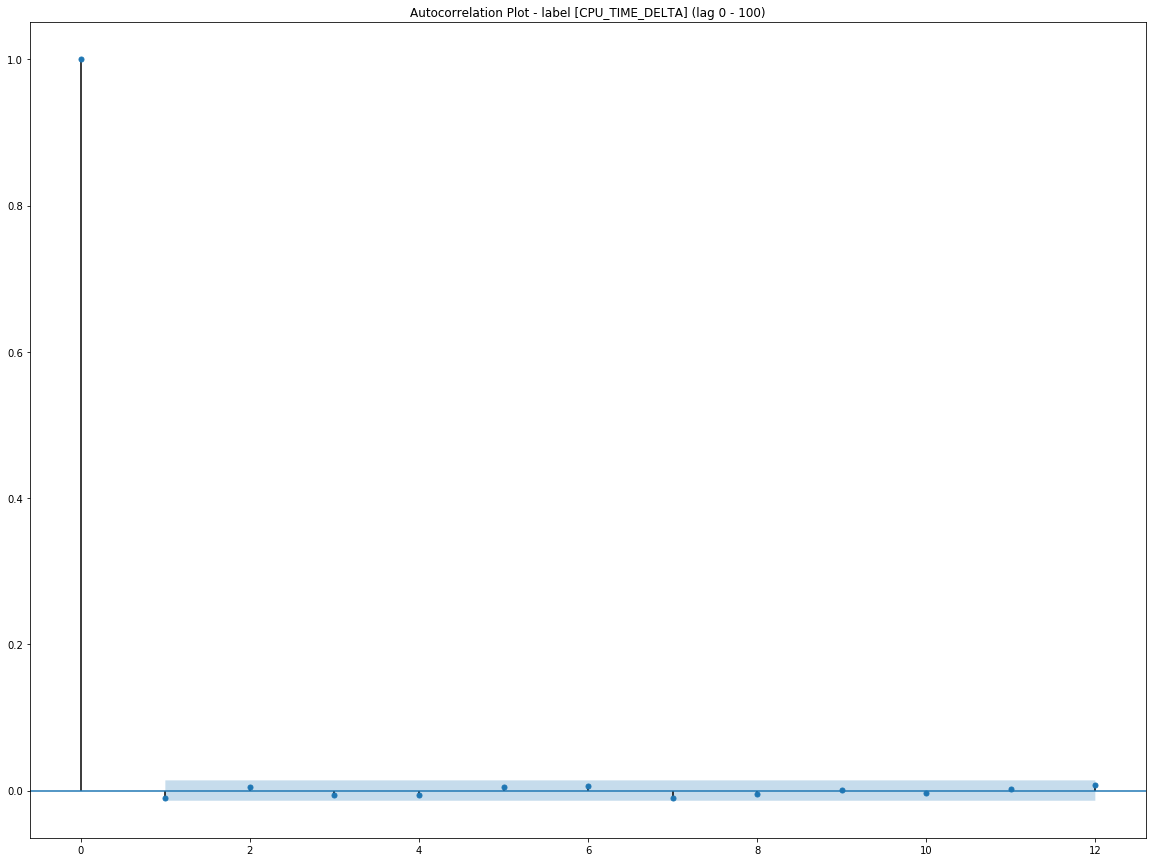

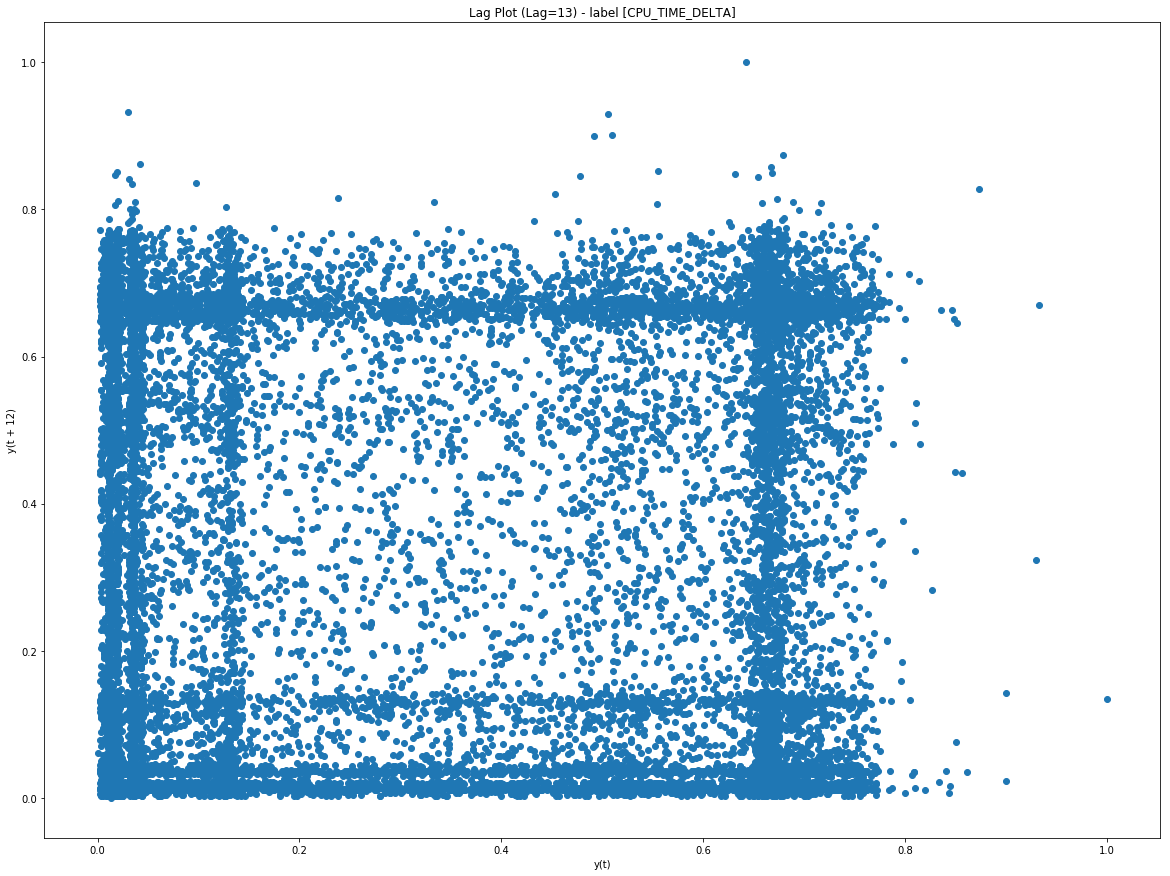

Label - [IOWAIT_DELTA]


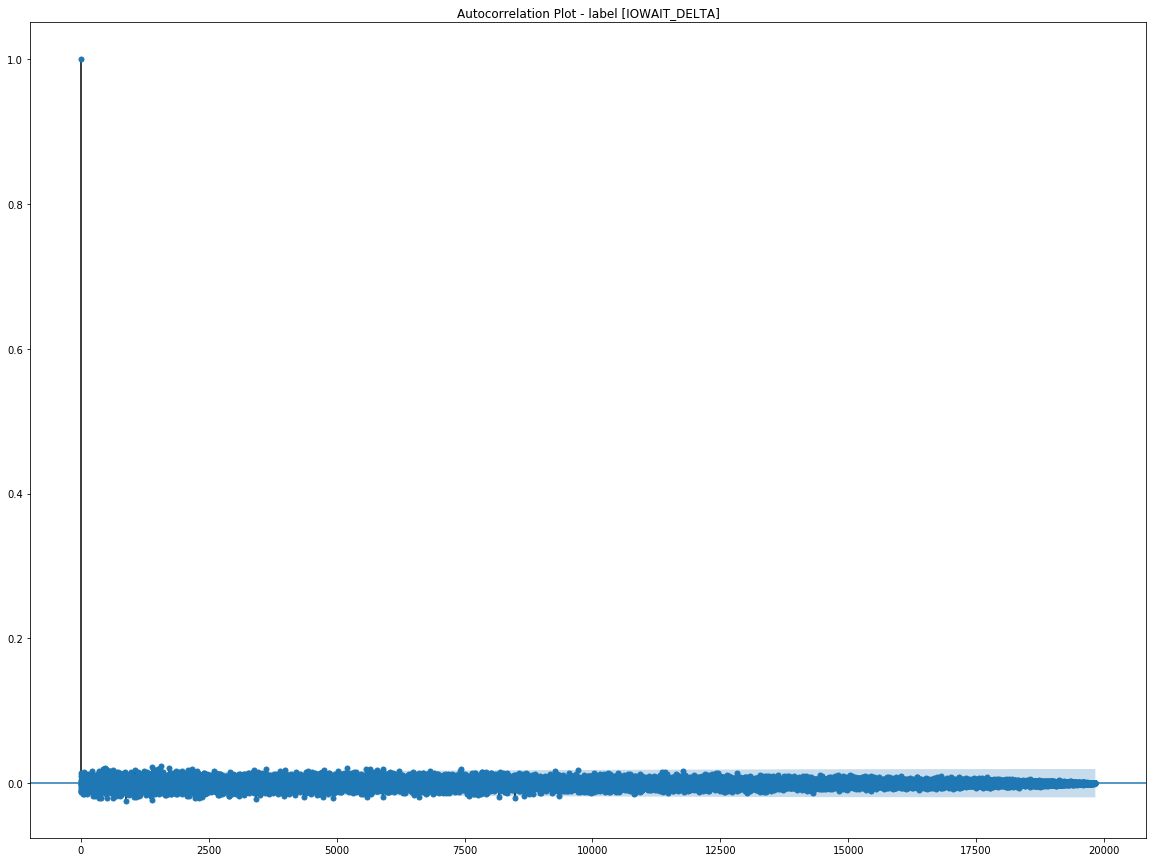

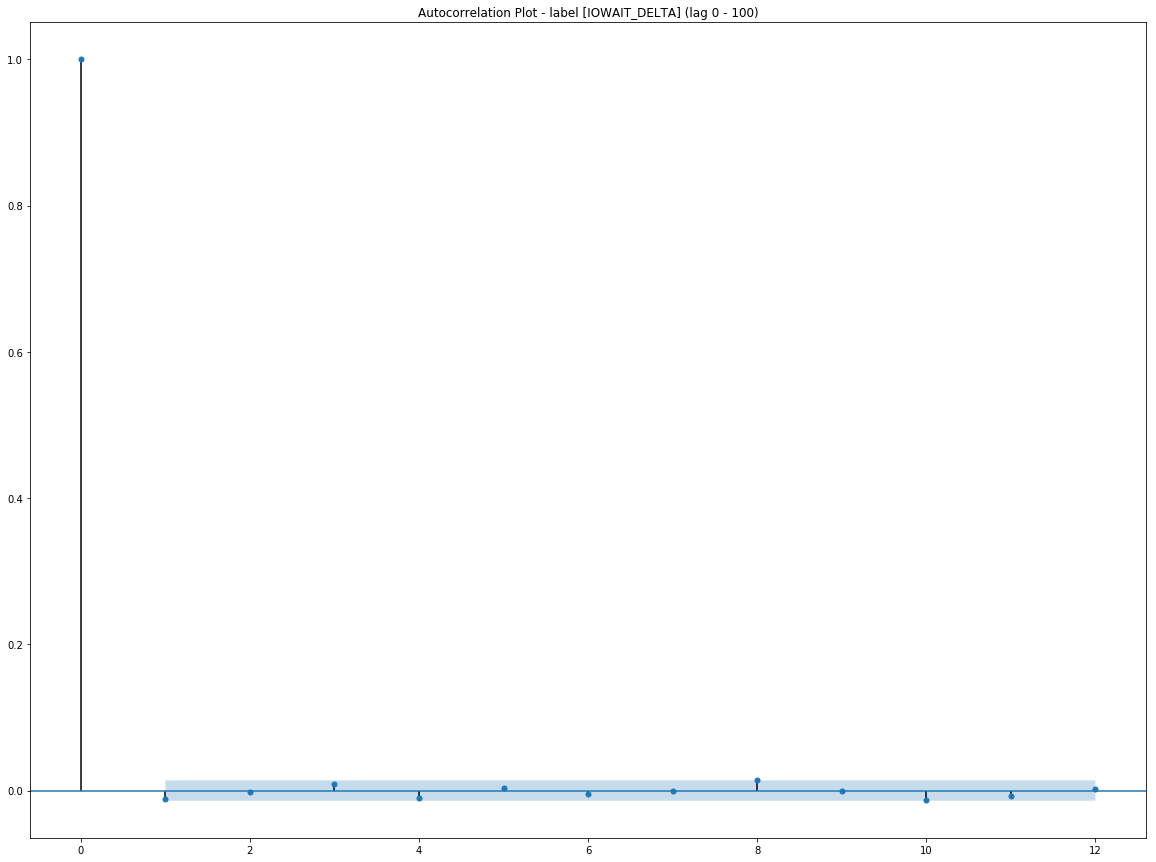

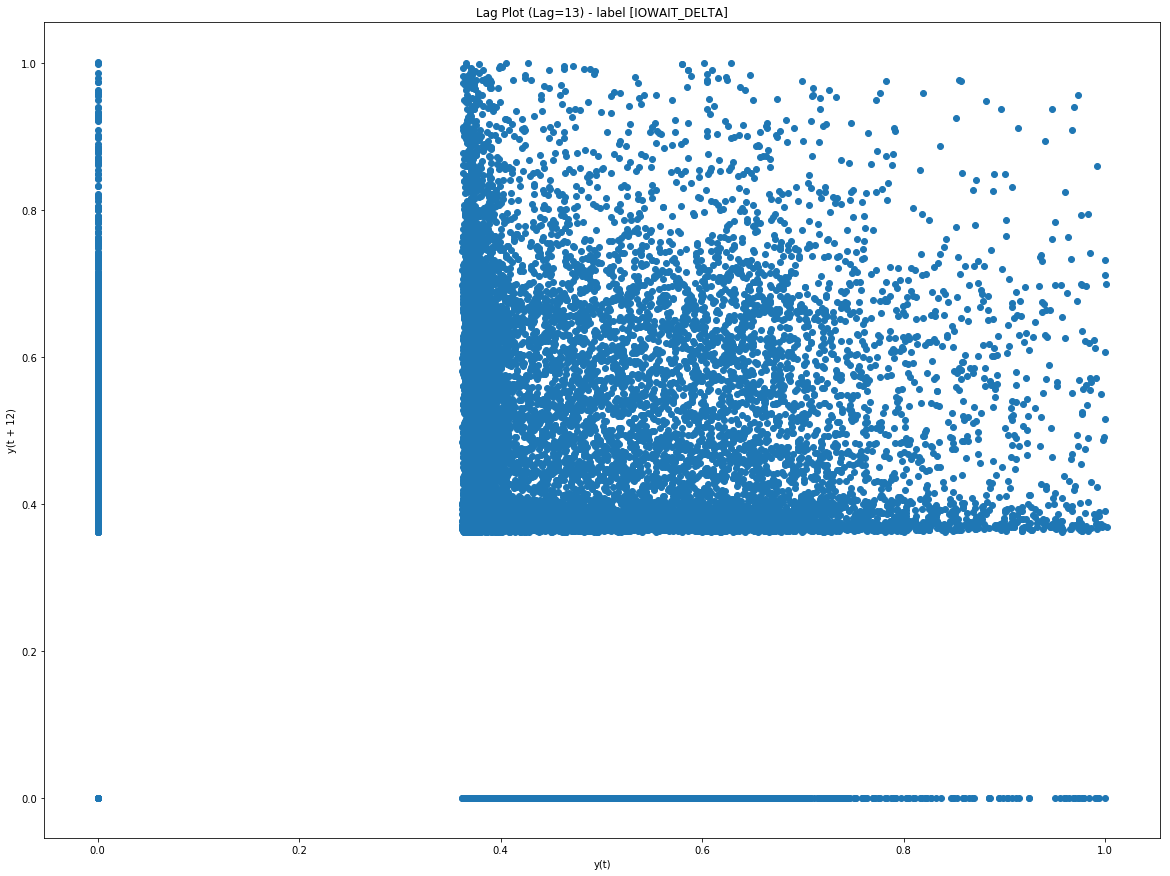

In [14]:
def qualify_lag(data, labels, lag):
    for label in labels:
        print('Label - [' + label + ']')
        plot_acf(data[label])
        plt.rcParams['figure.figsize'] = [20, 15]
        plt.title('Autocorrelation Plot - label [' + label + ']')
        plt.show()
        plot_acf(data[label], lags=lag)
        plt.rcParams['figure.figsize'] = [20, 15]
        plt.title('Autocorrelation Plot - label [' + label + '] (lag 0 - 100)')
        plt.show()
        lag_plot(data[label], lag=lag)
        plt.rcParams['figure.figsize'] = [20, 15]
        plt.title('Lag Plot (Lag=13) - label [' + label + ']')
        plt.show()

qualify_lag(data=df,
            labels=y_label,
            lag=lag)

### Discrete Training

This section converts the established features from the continuous domain into the discrete domain. Continous values will be converted into discrete, and used to train the model using such values (Utilizes bucket function).

https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/

In [15]:
class BinClass:
    """
    Takes data column, and scales them into discrete buckets. Parameter 'n' denotes number of buckets. This class needs
    to be defined before the LSTM class, since it is referenced during the prediction stage. Since Keras models output a
    continuous output (even when trained on discrete data), the 'BinClass' is required by the LSTM class.
    """
    
    @staticmethod
    def __bucket_val(val, avg):
        """
        Receives threshold value and buckets the val according to the passed threshold
        """
        return np.where(val > avg, 1, 0)

    @staticmethod
    def discretize_value(X, threshold):
        """
        param: X - Input data
        """
        try:
            myfunc_vec = np.vectorize(lambda x: BinClass.__bucket_val(x, threshold))
            return myfunc_vec(X)
        except:
            return BinClass.__bucket_val(X, threshold)

cpu_avg = y_df[y_label[0]].mean()
y_df_cpu = pd.DataFrame(BinClass.discretize_value(y_df[[y_label[0]]].values, cpu_avg), columns=[y_label[0]])
print('CPU y:')
print(np.unique(y_df_cpu.values))
print('Number of 0s: ' + str(np.count_nonzero(y_df_cpu == 0)))
print('Number of 1s: ' + str(np.count_nonzero(y_df_cpu == 1)))

io_avg = y_df[y_label[1]].mean()
y_df_io = pd.DataFrame(BinClass.discretize_value(y_df[[y_label[1]]].values, io_avg), columns=[y_label[1]])
print('I/O y:')
print(np.unique(y_df_io.values))
print('Number of 0s: ' + str(np.count_nonzero(y_df_io == 0)))
print('Number of 1s: ' + str(np.count_nonzero(y_df_io == 1)))

CPU y:
[0 1]
Number of 0s: 10804
Number of 1s: 9027
I/O y:
[0 1]
Number of 0s: 11673
Number of 1s: 8158


### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

Features and Labels are separated into seperate dataframes at this point.

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    n_out += 1
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Frame as supervised learning set
X_df = series_to_supervised(X_df, lag, 0)
y_df = series_to_supervised(y_df, 0, lag)

print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print('\n-------------\nLabels')
print(y_df.columns)
print(y_df.shape)


-------------
Features
Index(['var1(t-12)', 'var2(t-12)', 'var3(t-12)', 'var4(t-12)', 'var5(t-12)',
       'var6(t-12)', 'var7(t-12)', 'var8(t-12)', 'var9(t-12)', 'var10(t-12)',
       ...
       'var502(t)', 'var503(t)', 'var504(t)', 'var505(t)', 'var506(t)',
       'var507(t)', 'var508(t)', 'var509(t)', 'var510(t)', 'var511(t)'],
      dtype='object', length=6643)
(19819, 6643)

-------------
Labels
Index(['var1(t)', 'var2(t)', 'var1(t+1)', 'var2(t+1)', 'var1(t+2)',
       'var2(t+2)', 'var1(t+3)', 'var2(t+3)', 'var1(t+4)', 'var2(t+4)',
       'var1(t+5)', 'var2(t+5)', 'var1(t+6)', 'var2(t+6)', 'var1(t+7)',
       'var2(t+7)', 'var1(t+8)', 'var2(t+8)', 'var1(t+9)', 'var2(t+9)',
       'var1(t+10)', 'var2(t+10)', 'var1(t+11)', 'var2(t+11)', 'var1(t+12)',
       'var2(t+12)'],
      dtype='object')
(19819, 26)


### Test Split Train / Validation / Test

Split main feature/label matrix/vector into 2 subsets. 
* First subset will be used for training the model
* The other subset is split into two further subsets:
    - Model Validation
    - Model Testing
    
The training test itself is further reshaped, so as to satisfy the format required by LSTMS

X_train shape [(9909, 6643)] Type - <class 'numpy.ndarray'>
y_train shape [(9909, 26)] Type - <class 'numpy.ndarray'>
X_validate shape [(4955, 6643)] Type - <class 'numpy.ndarray'>
y_validate shape [(4955, 26)] Type - <class 'numpy.ndarray'>
X_test shape [(4955, 6643)] Type - <class 'numpy.ndarray'>
y_test shape [(4955, 26)] Type - <class 'numpy.ndarray'>


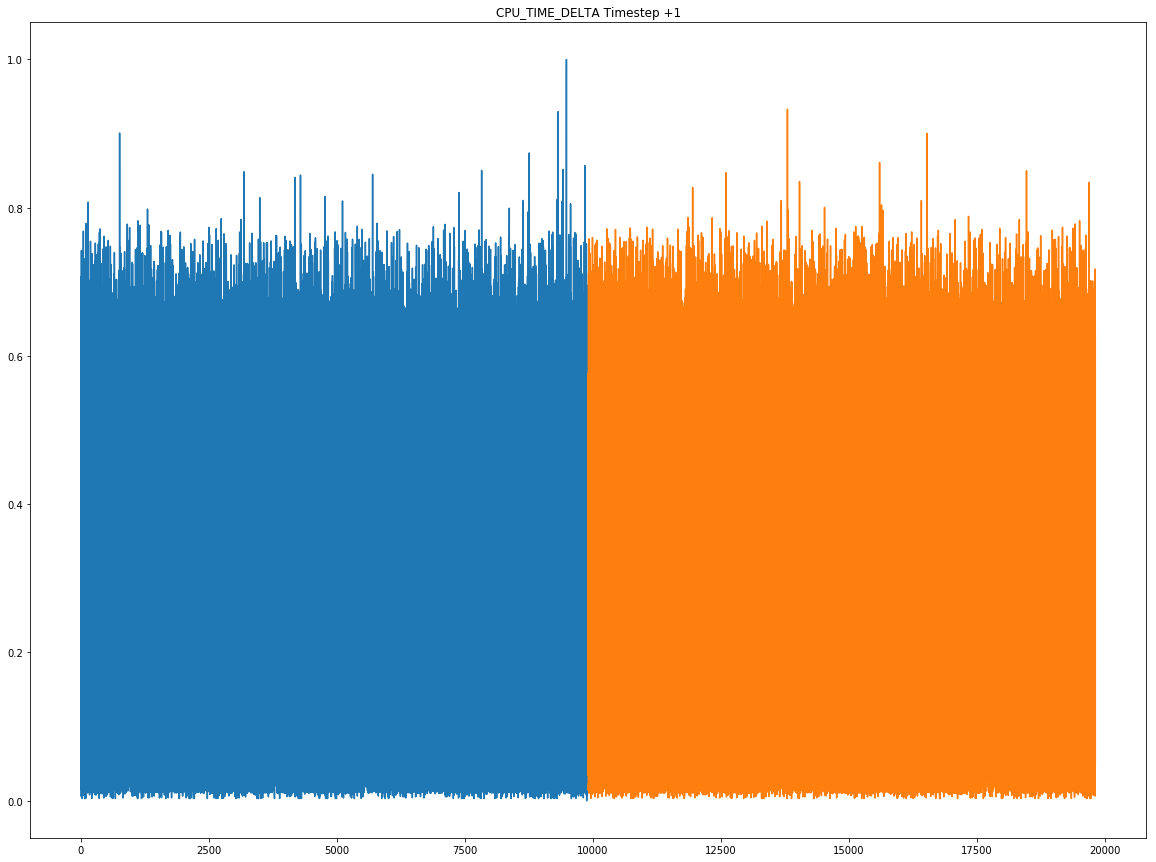

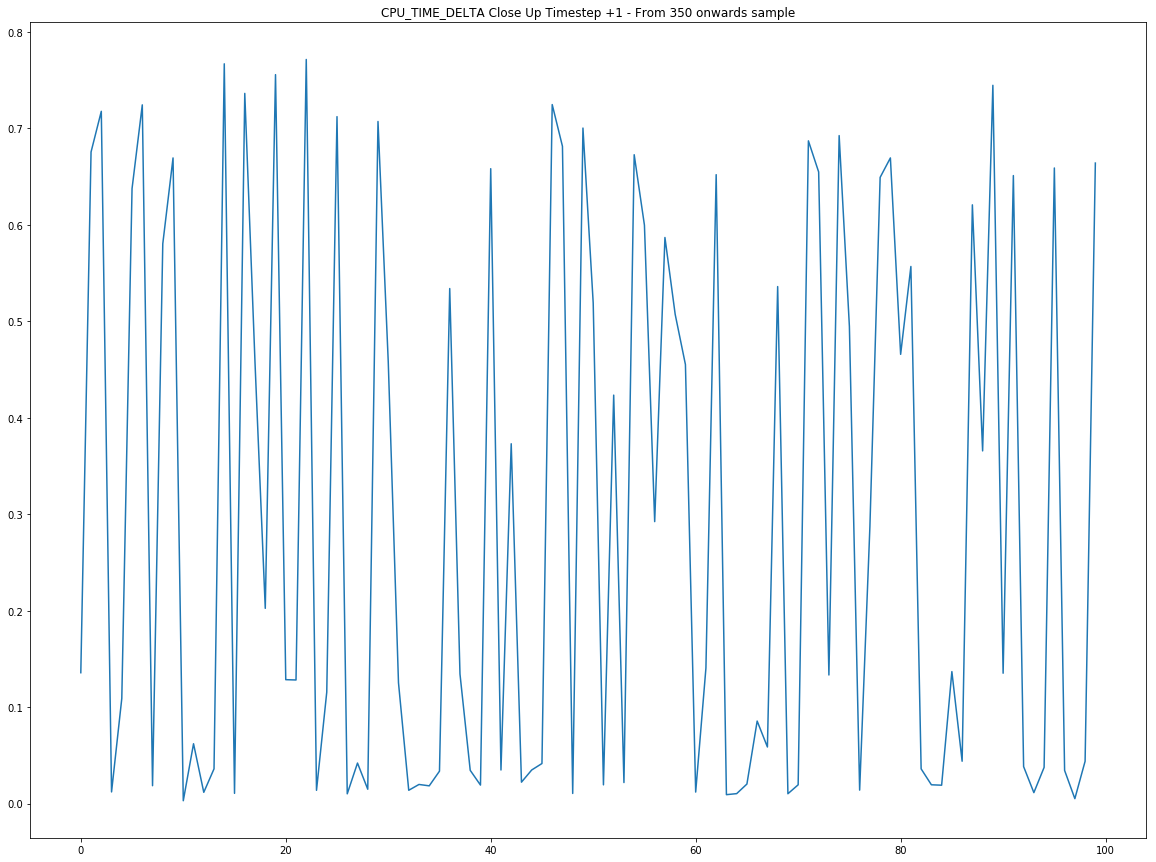

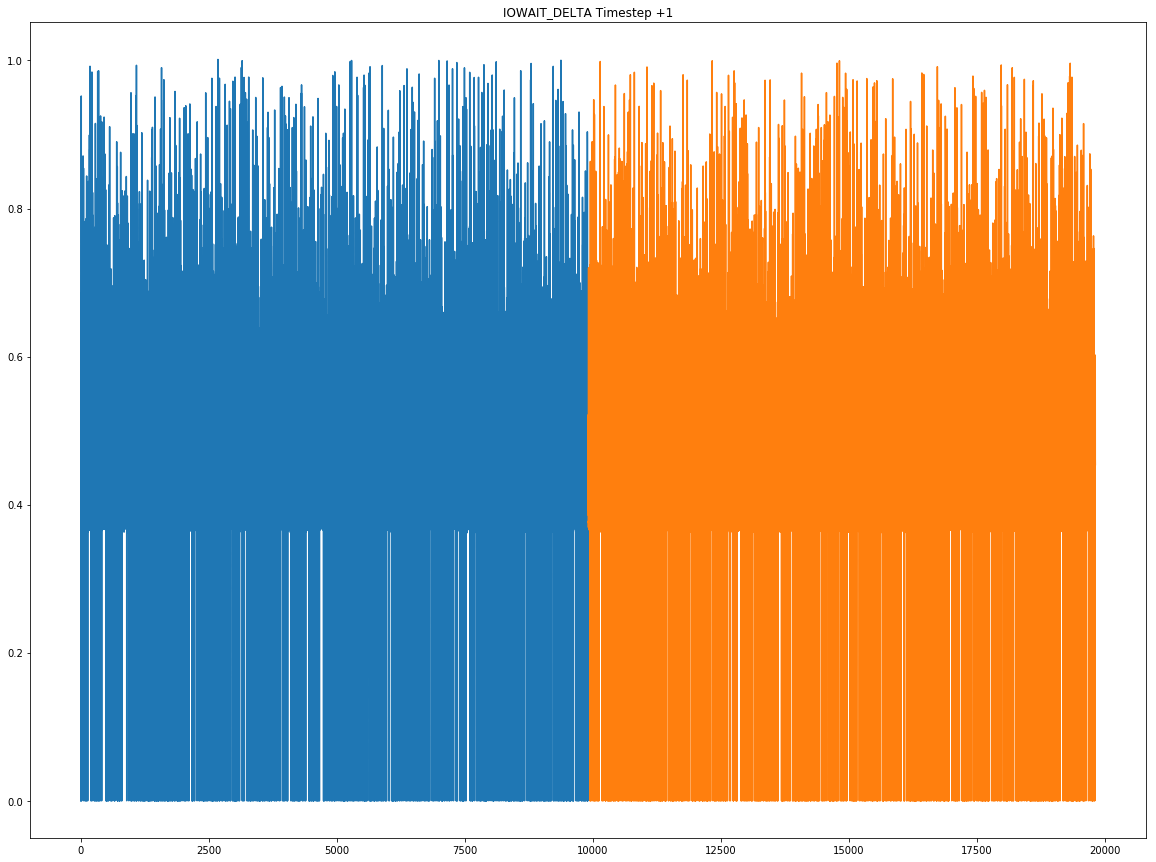

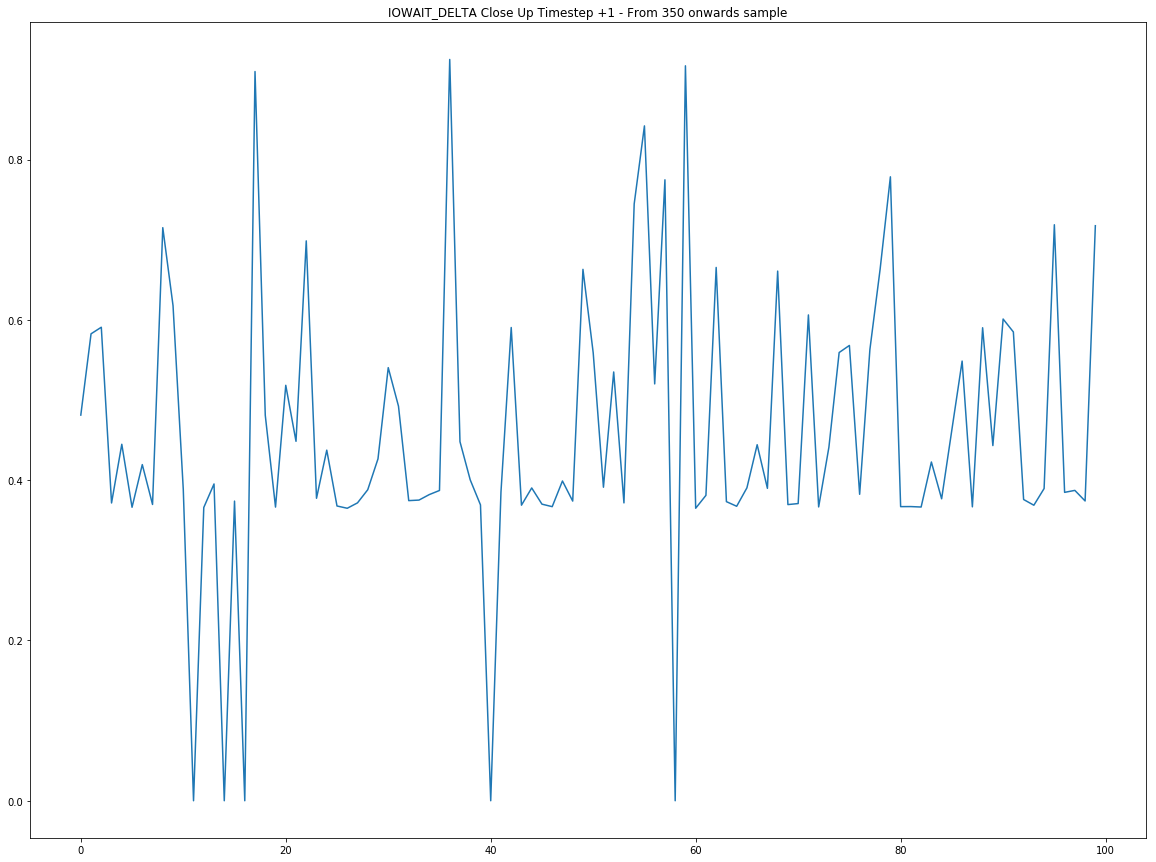

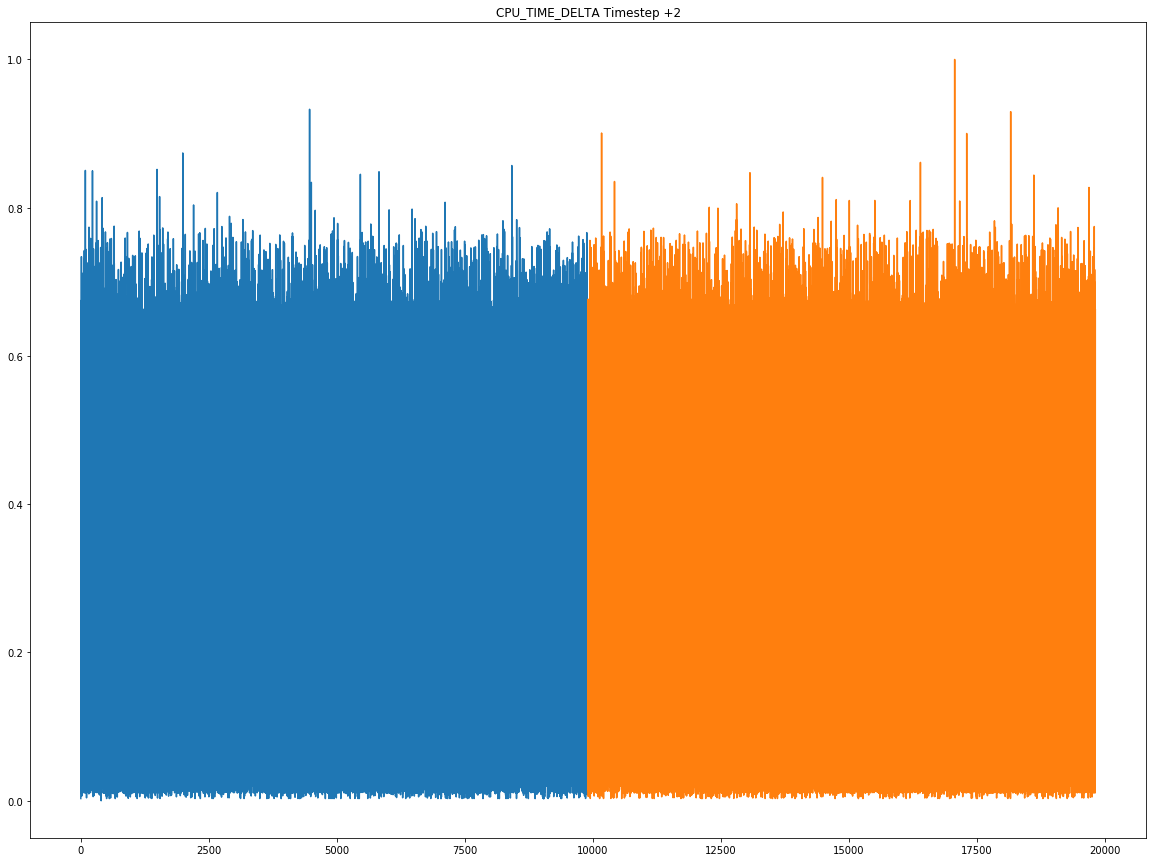

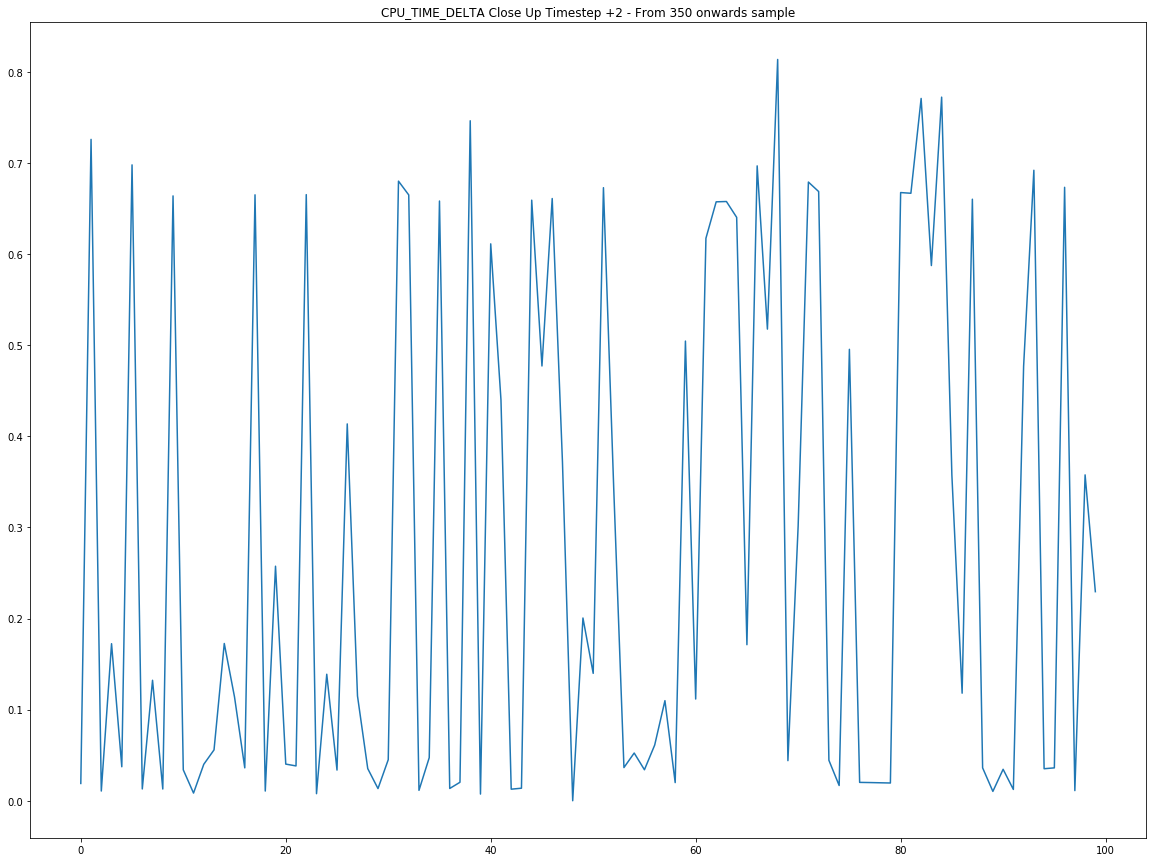

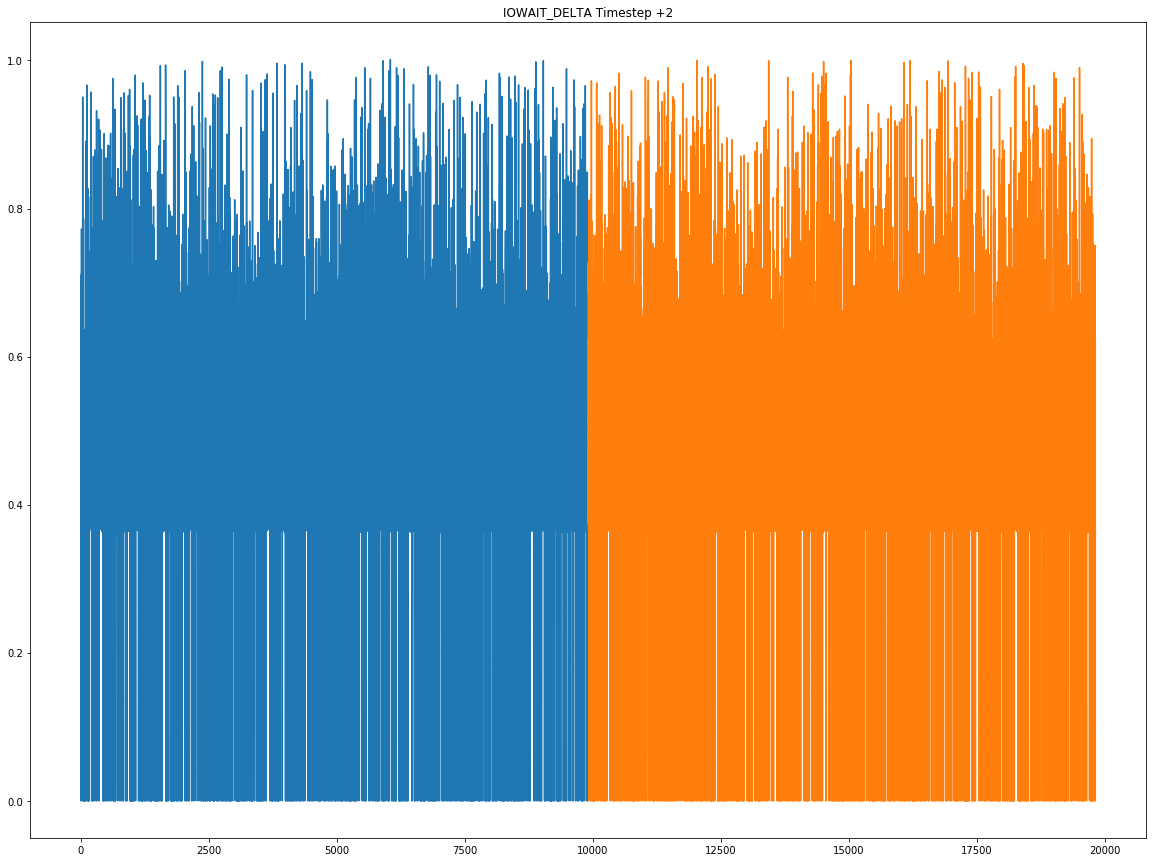

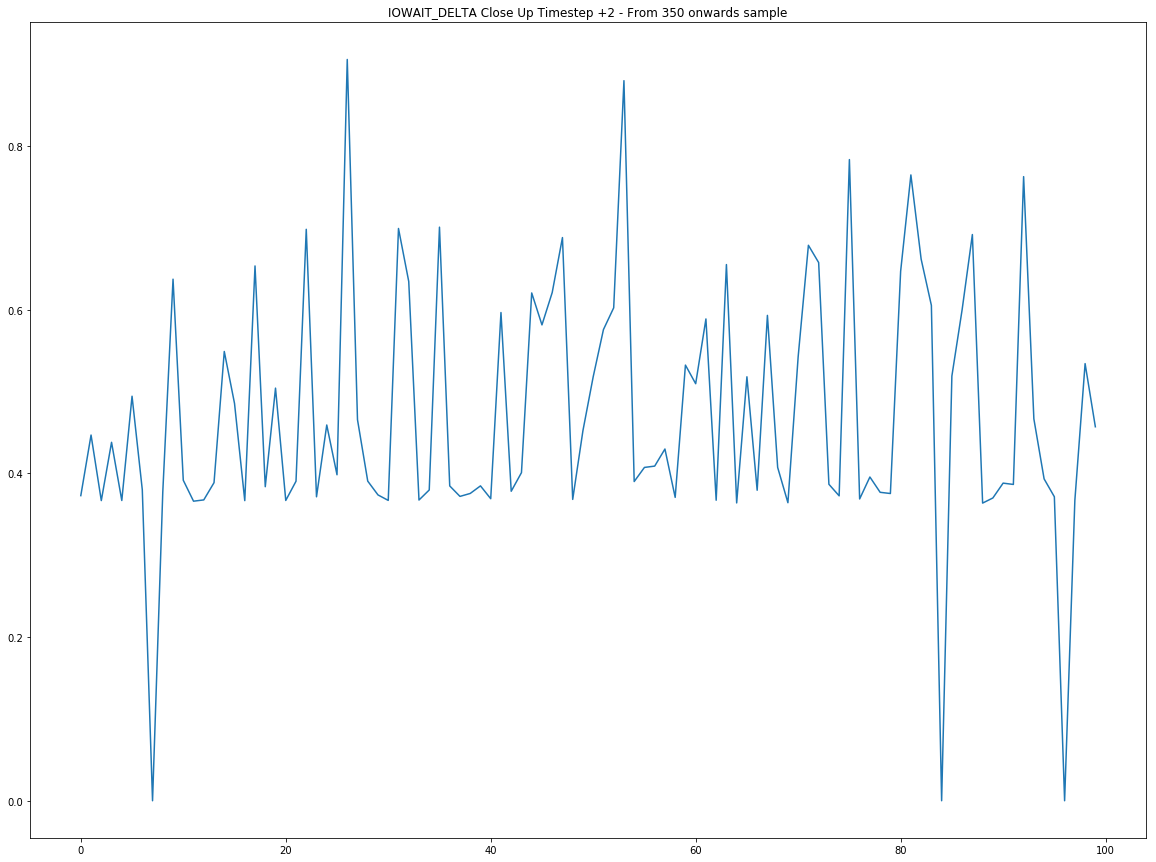

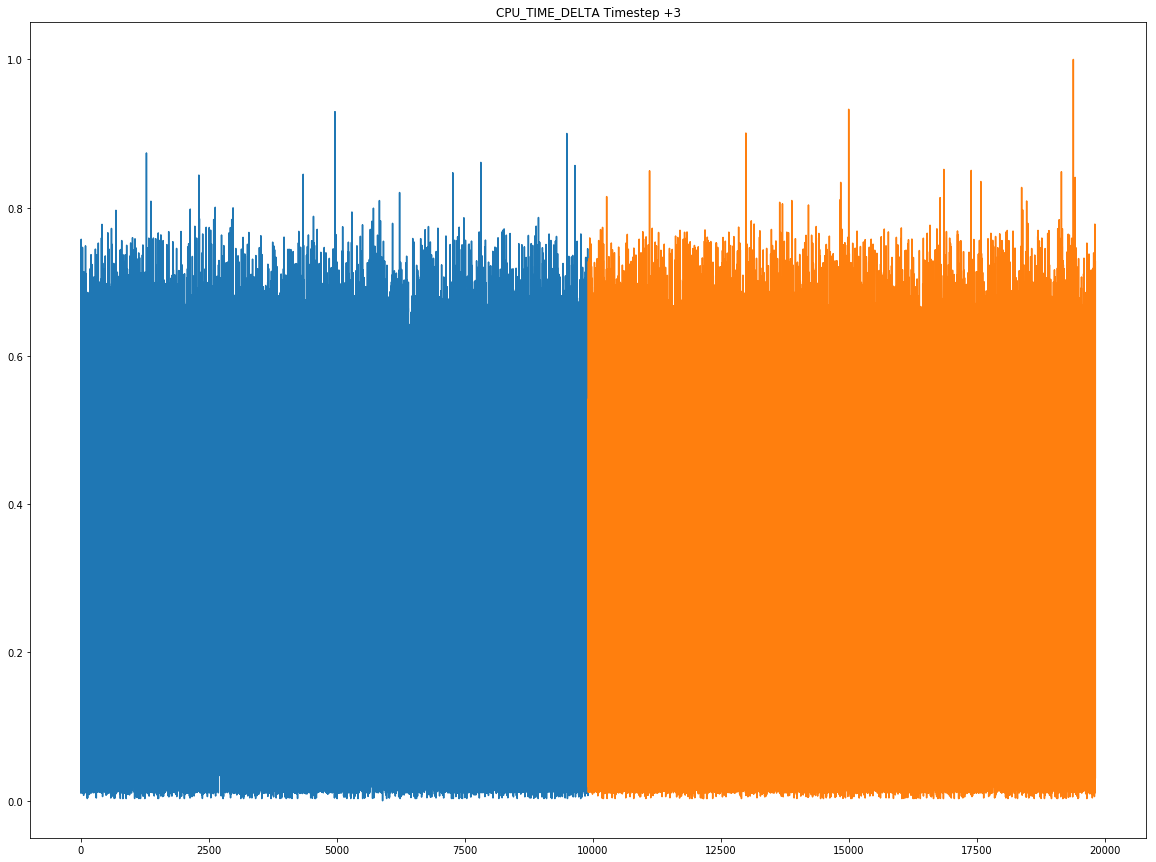

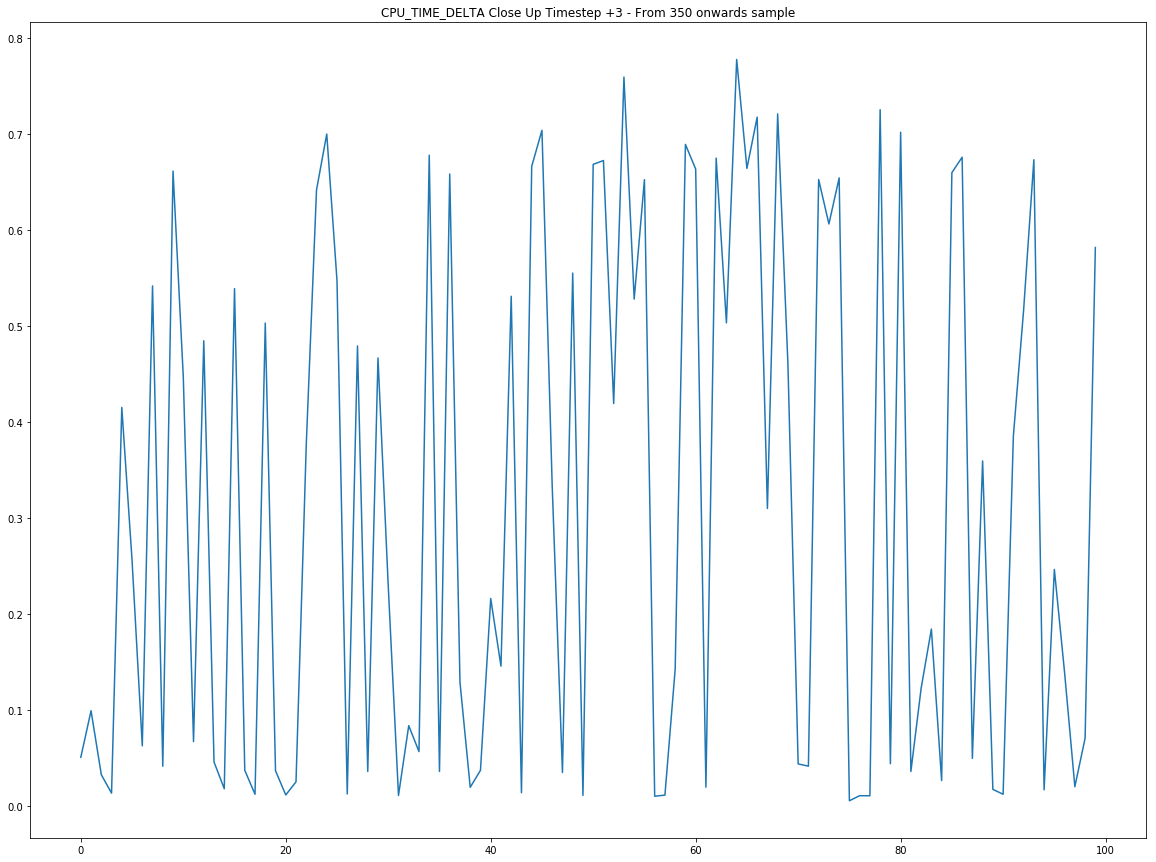

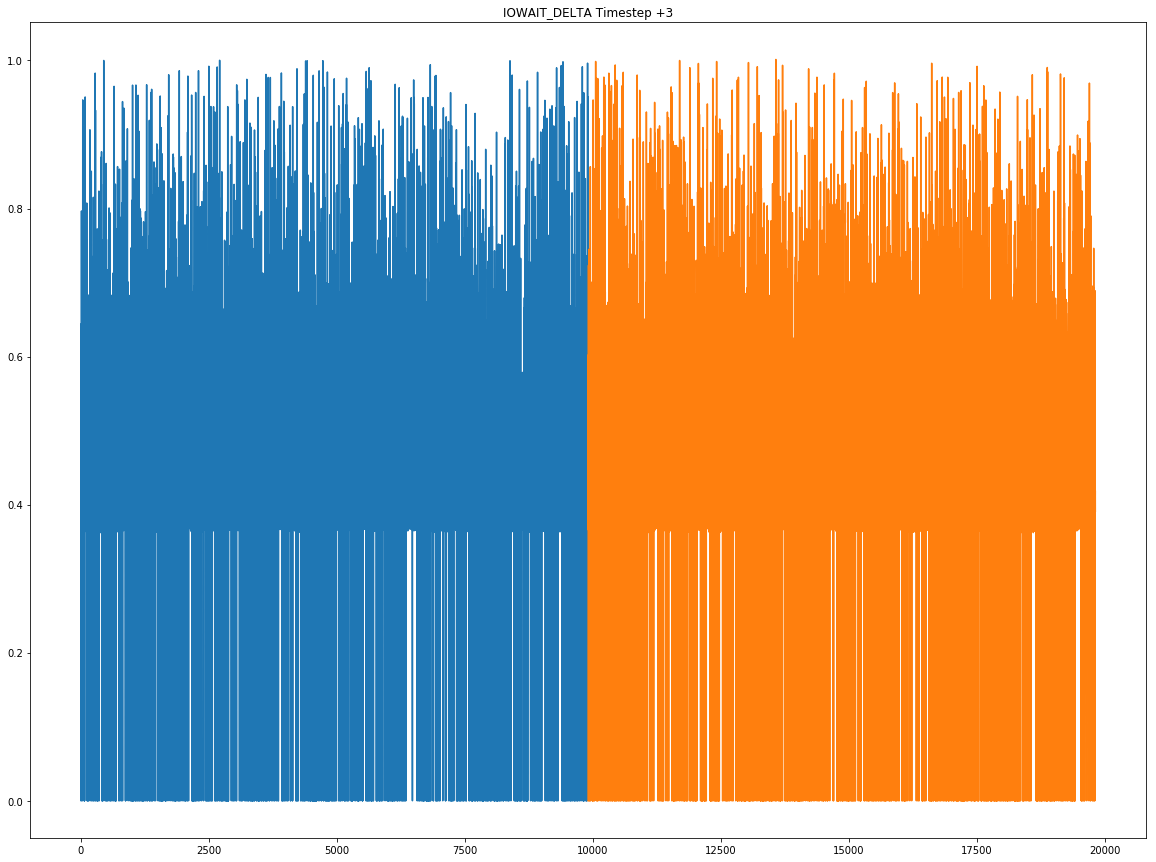

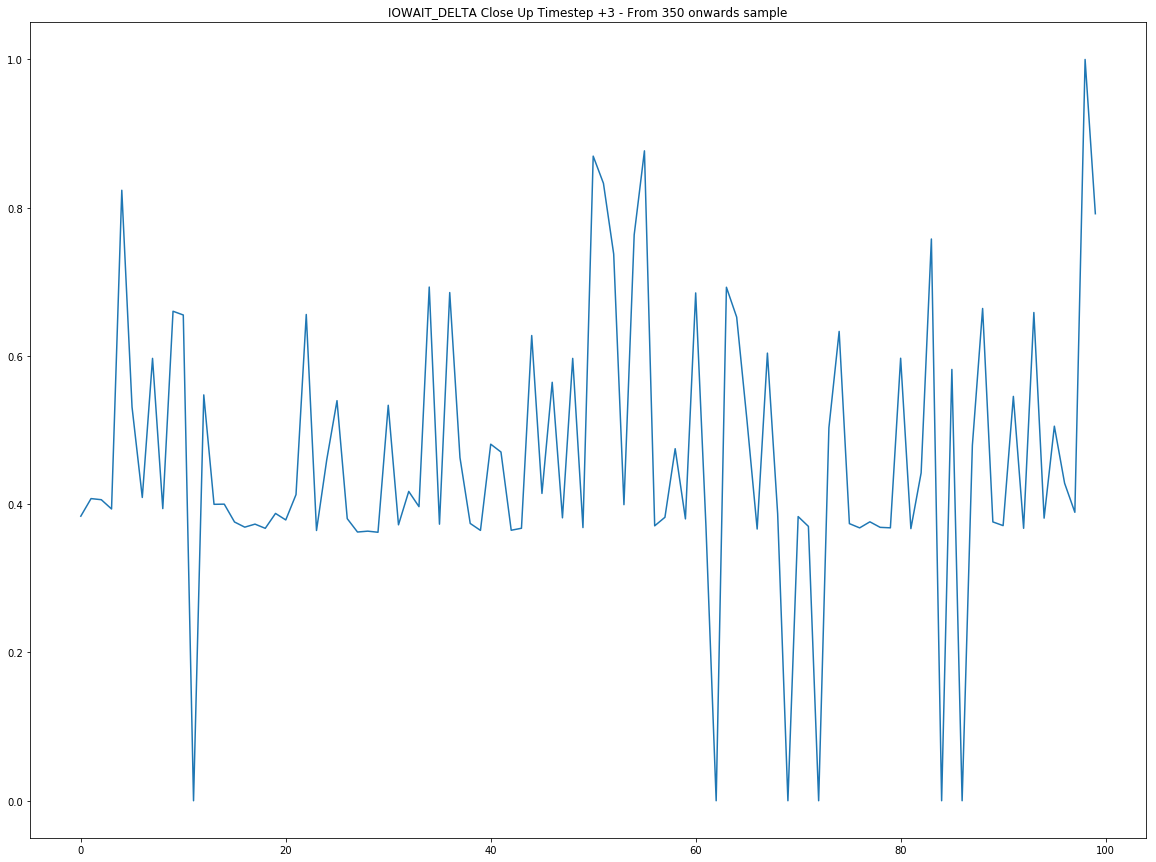

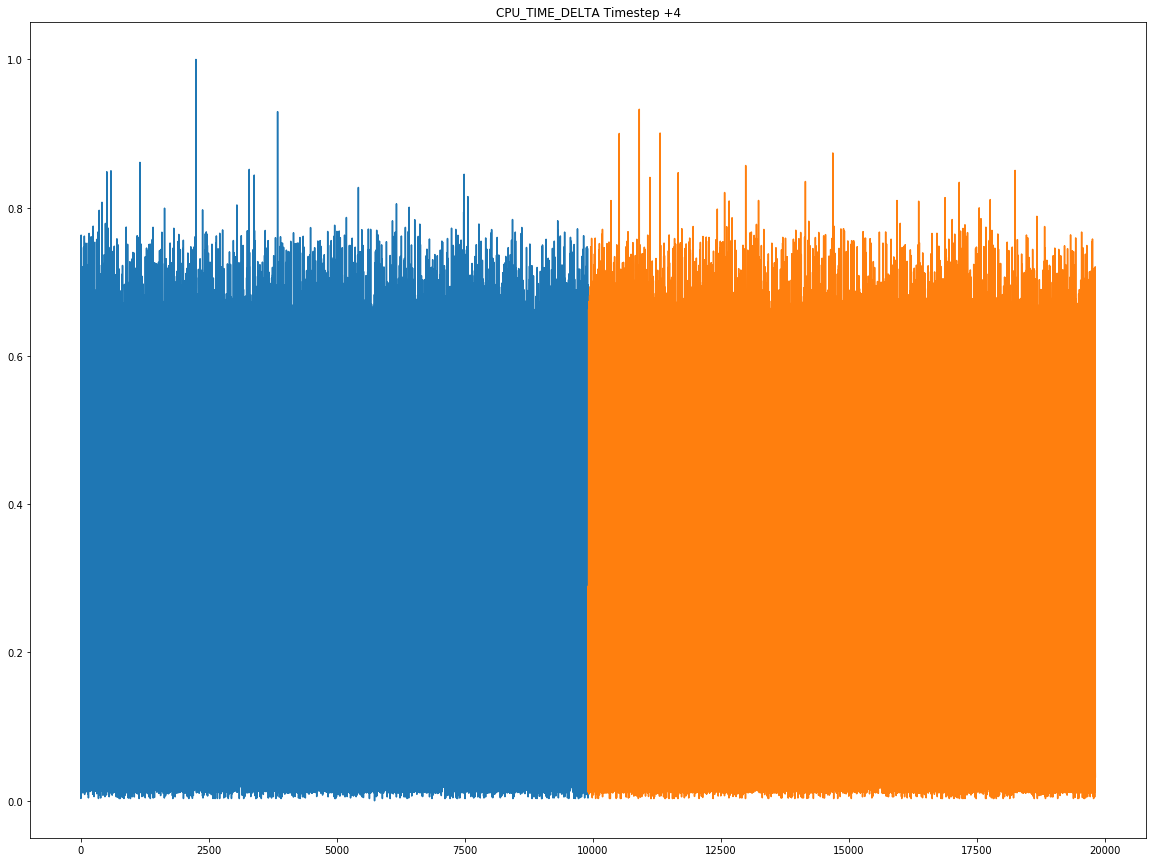

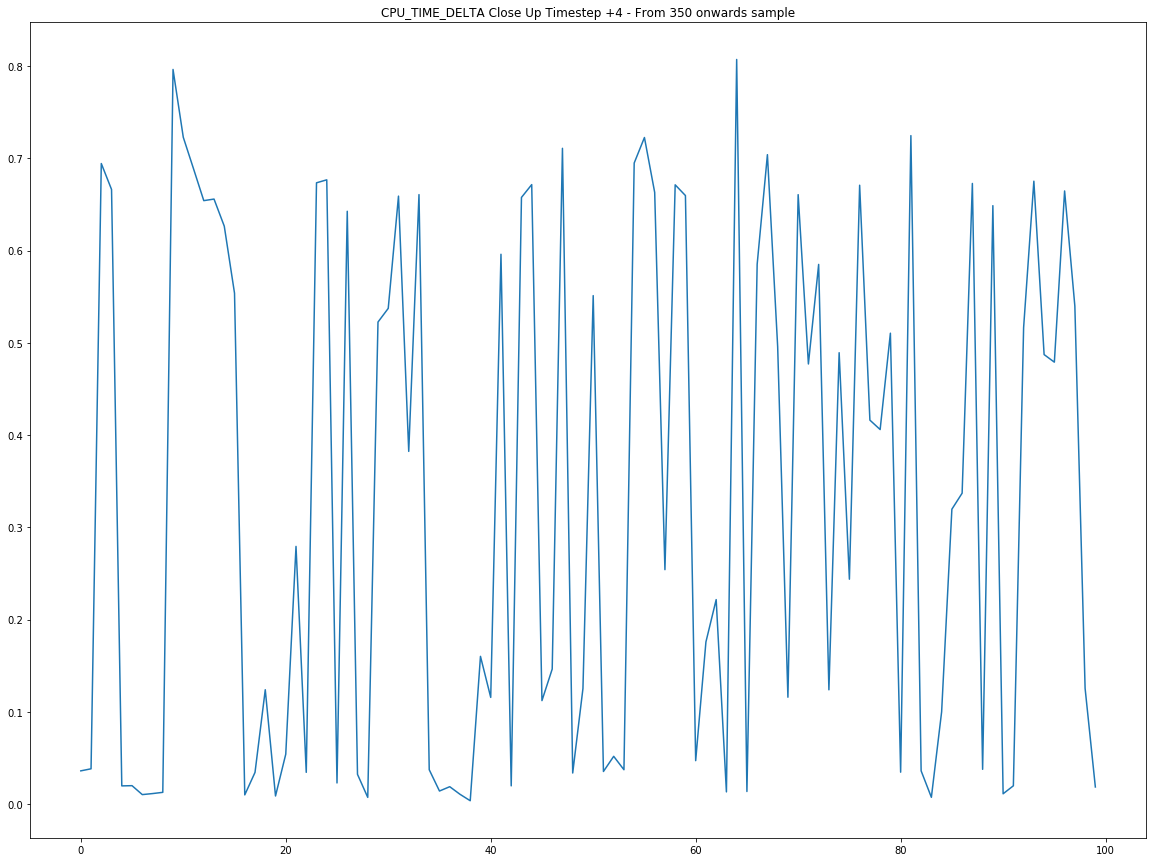

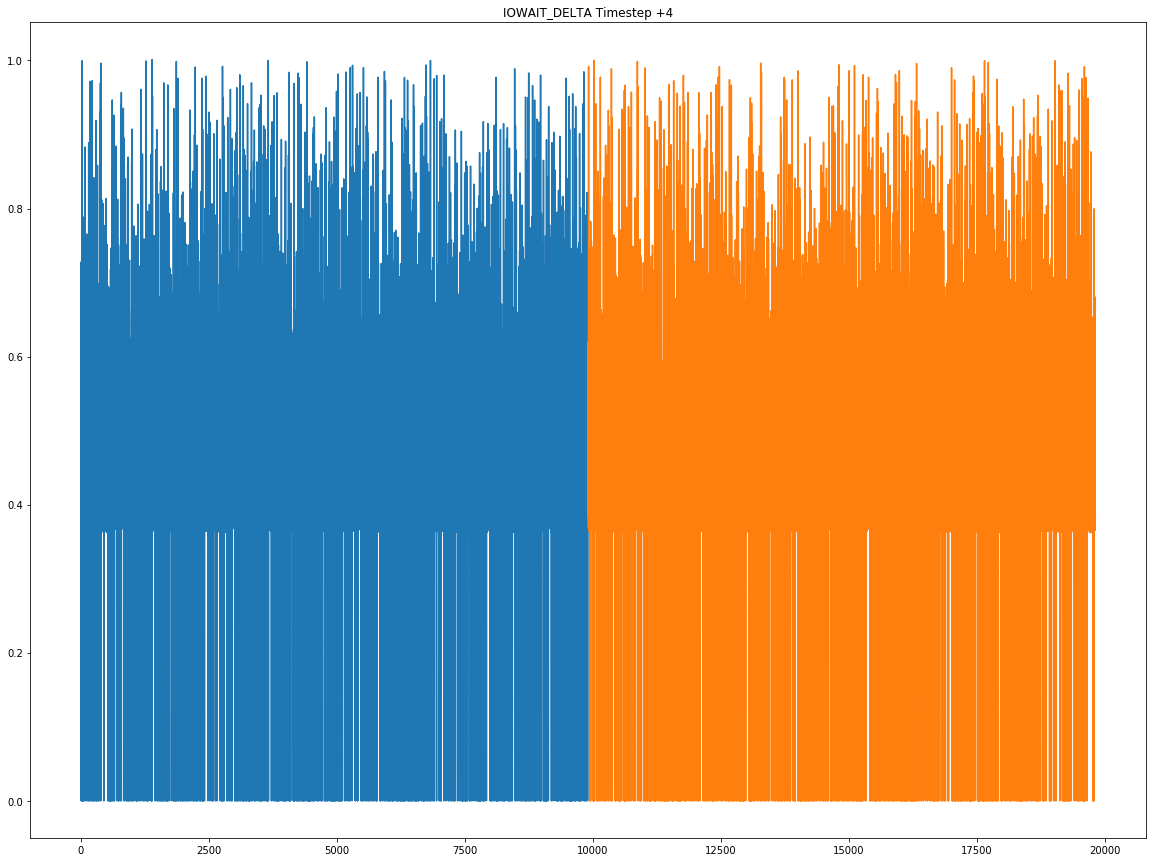

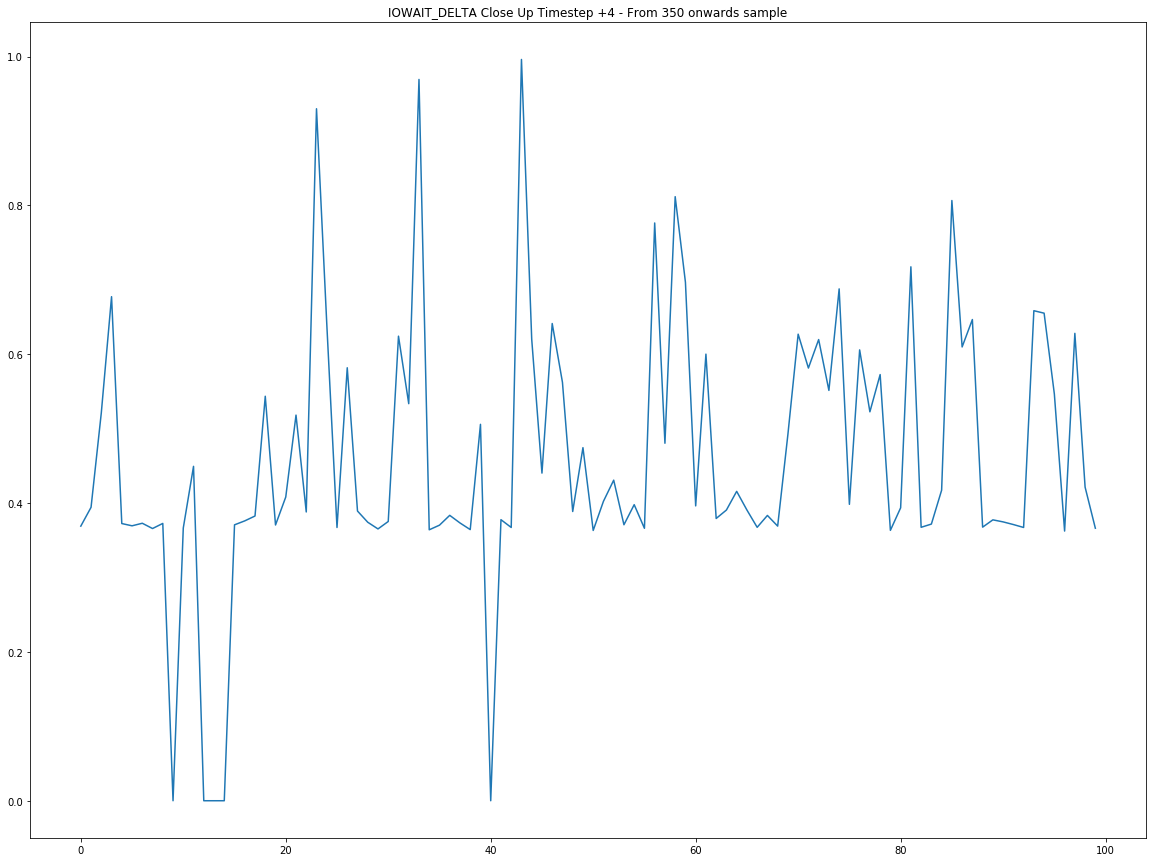

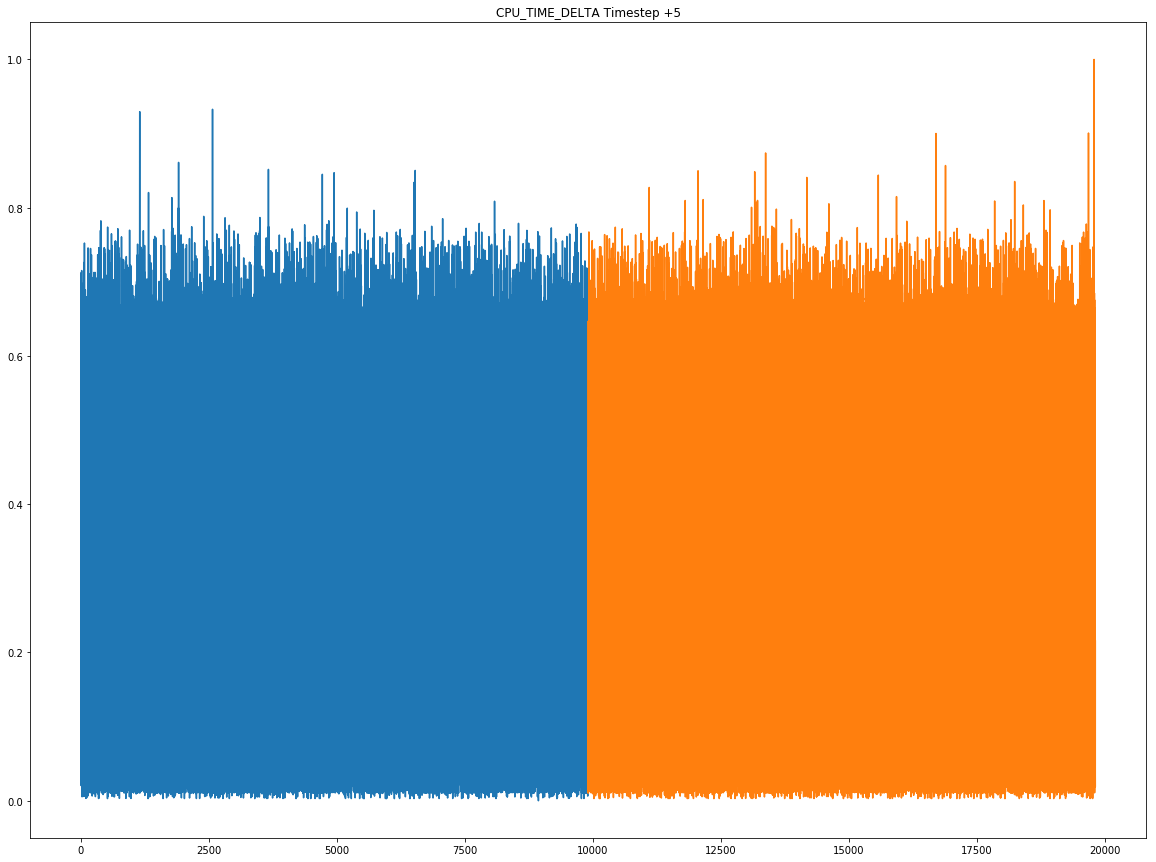

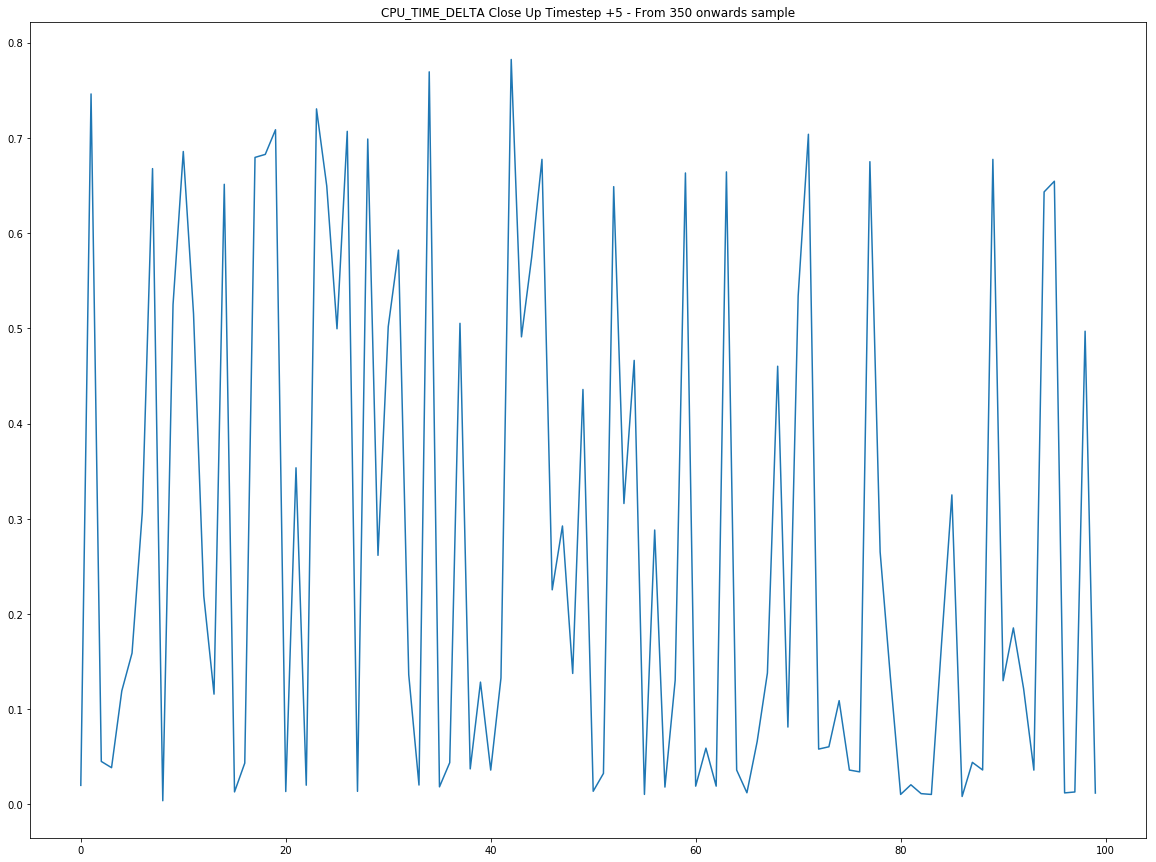

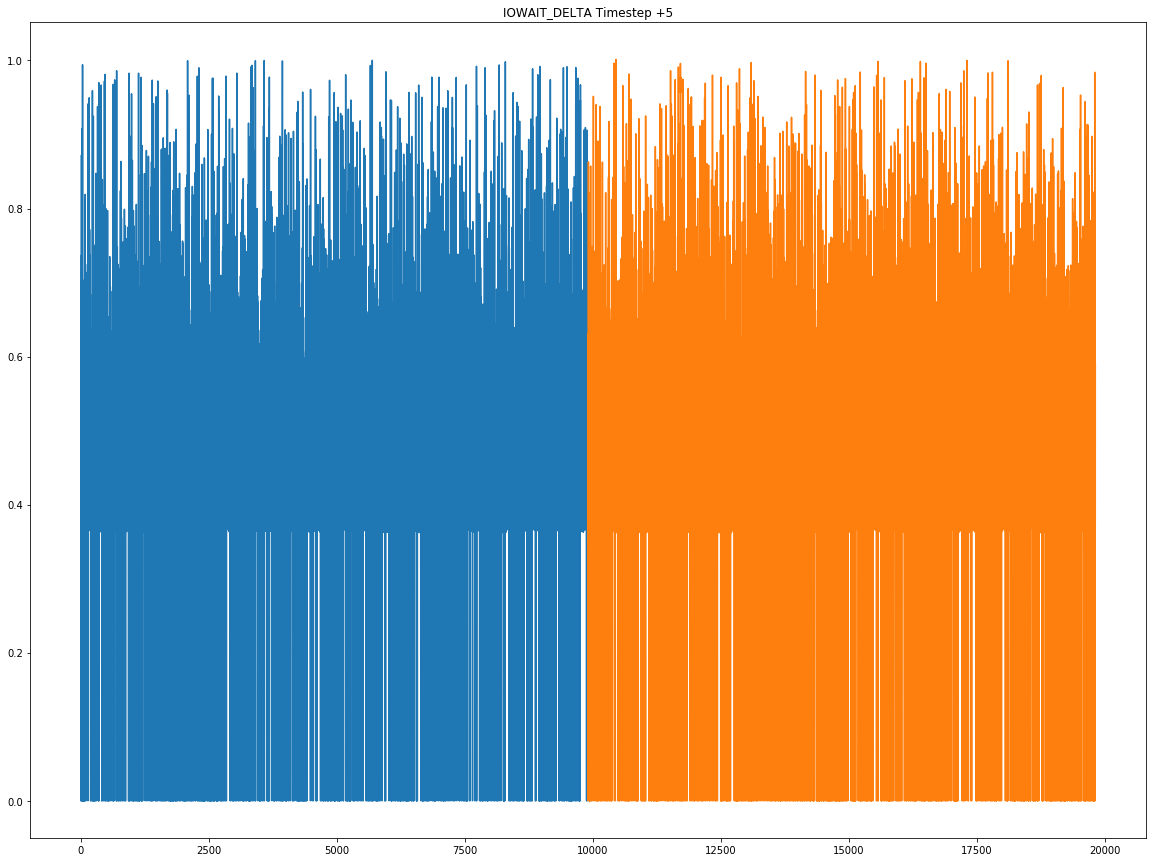

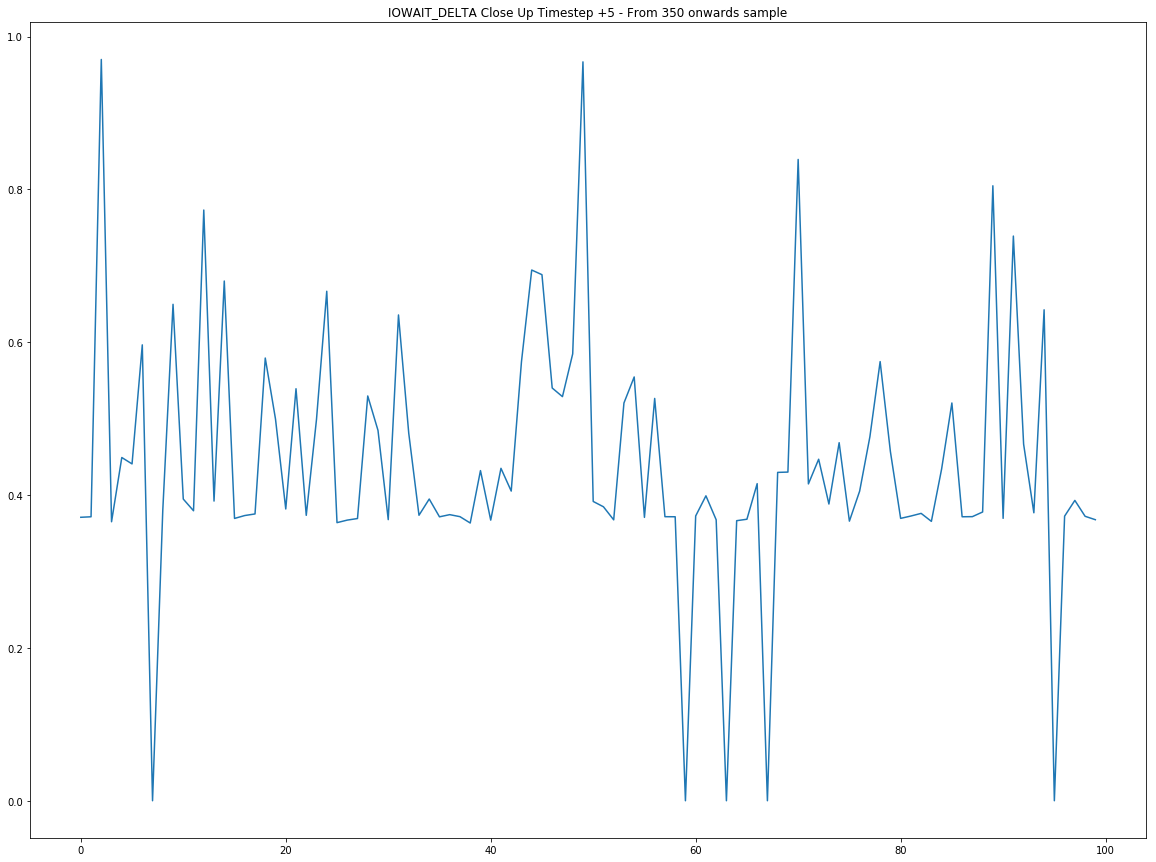

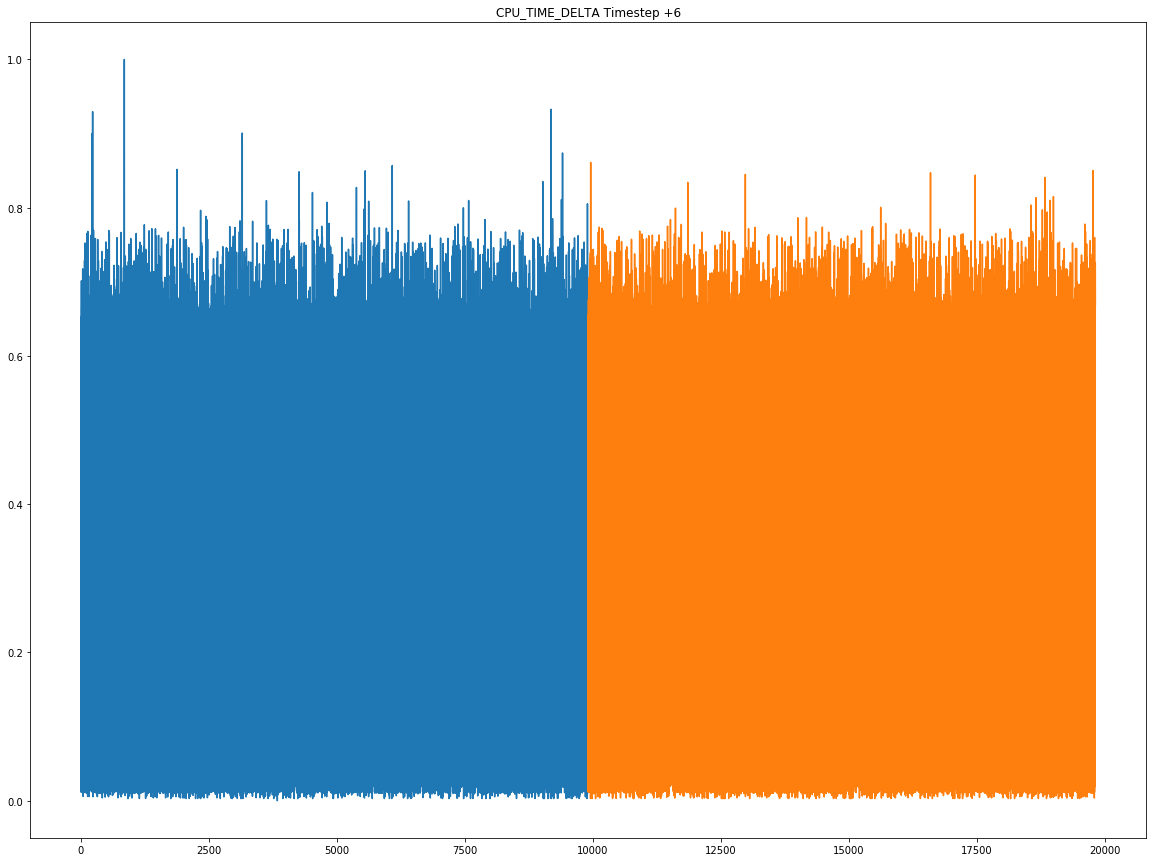

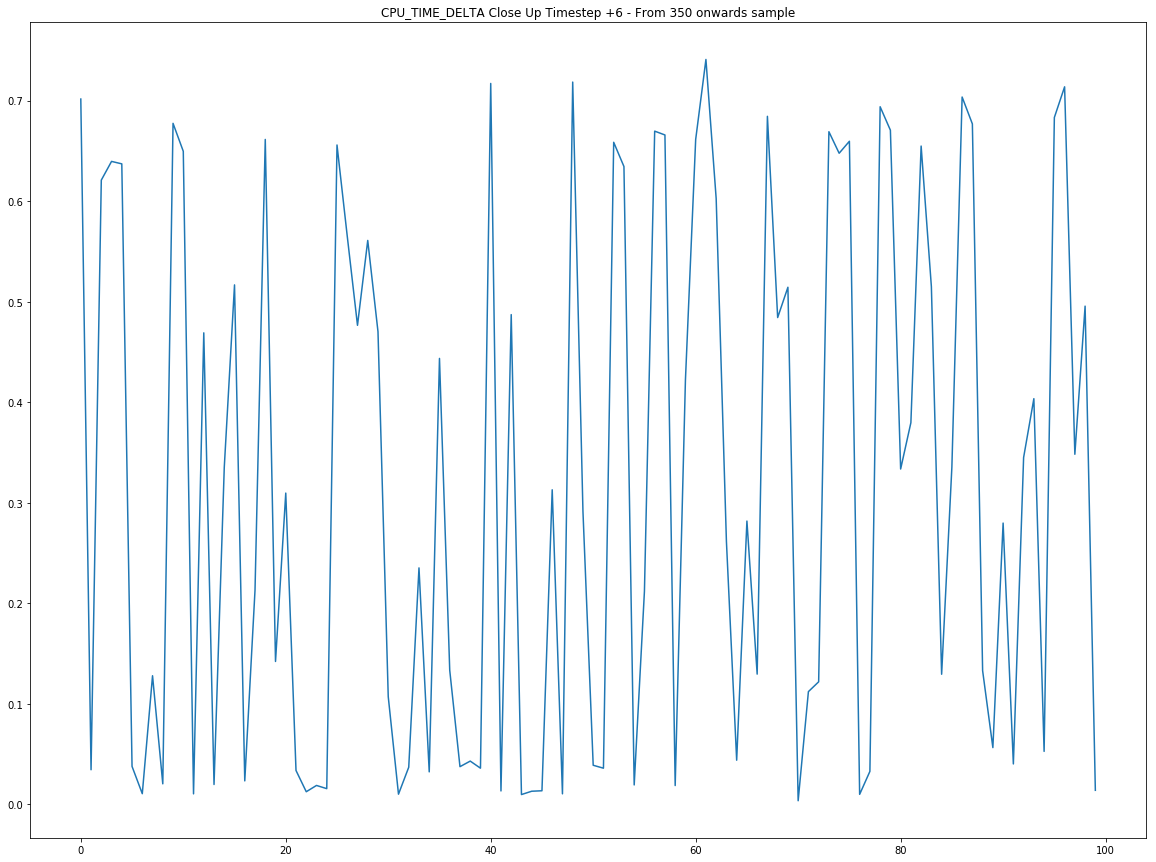

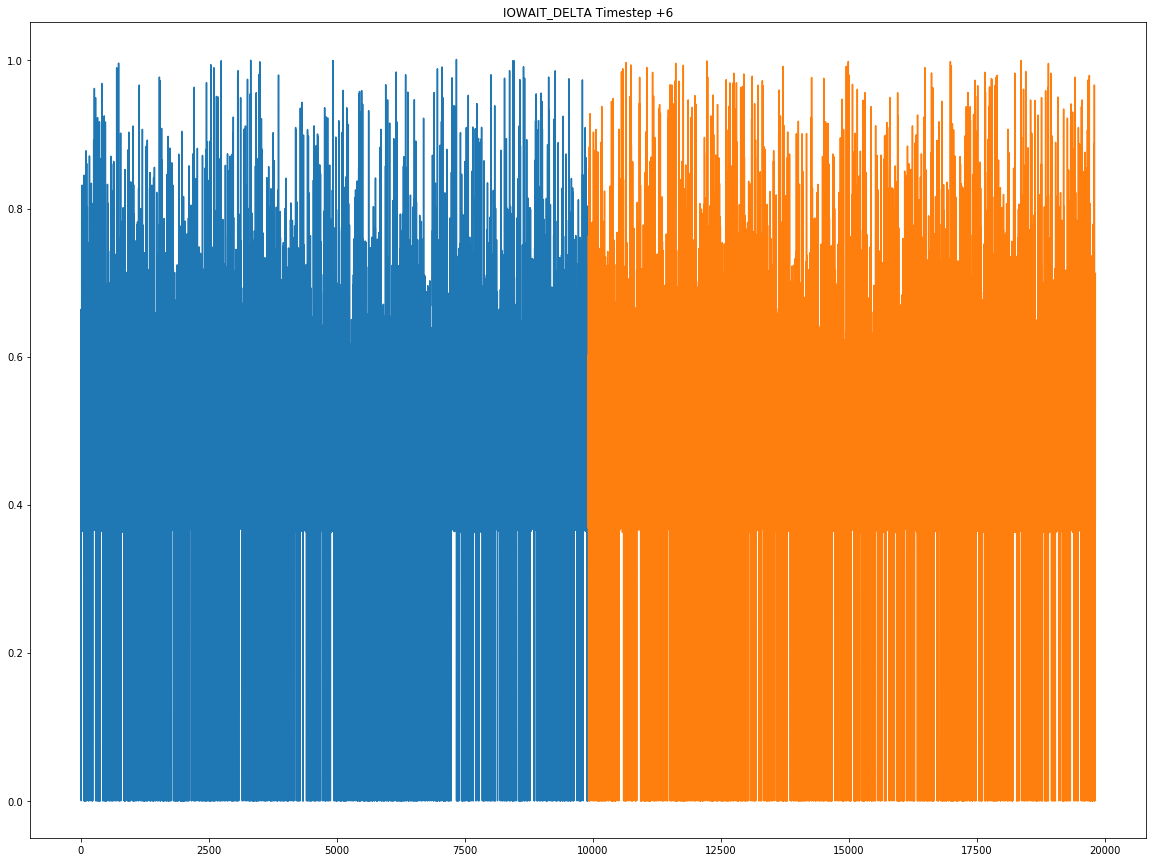

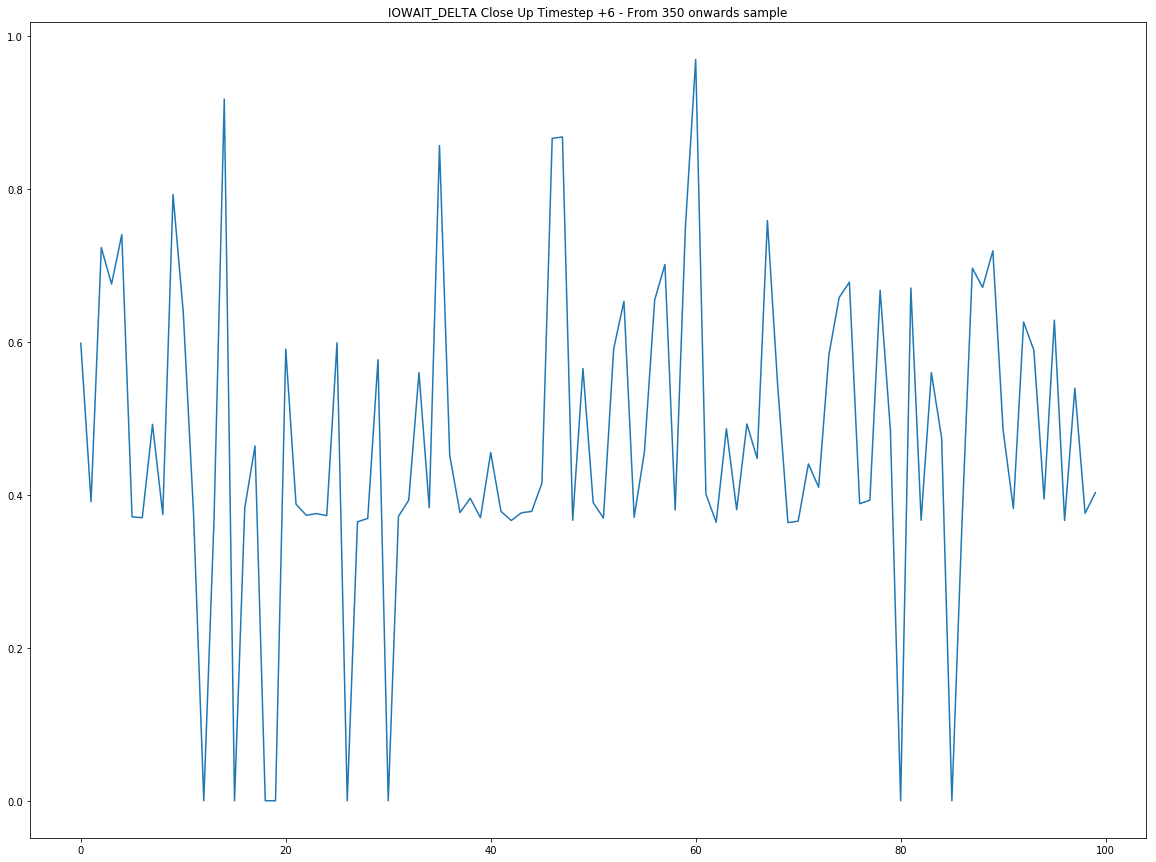

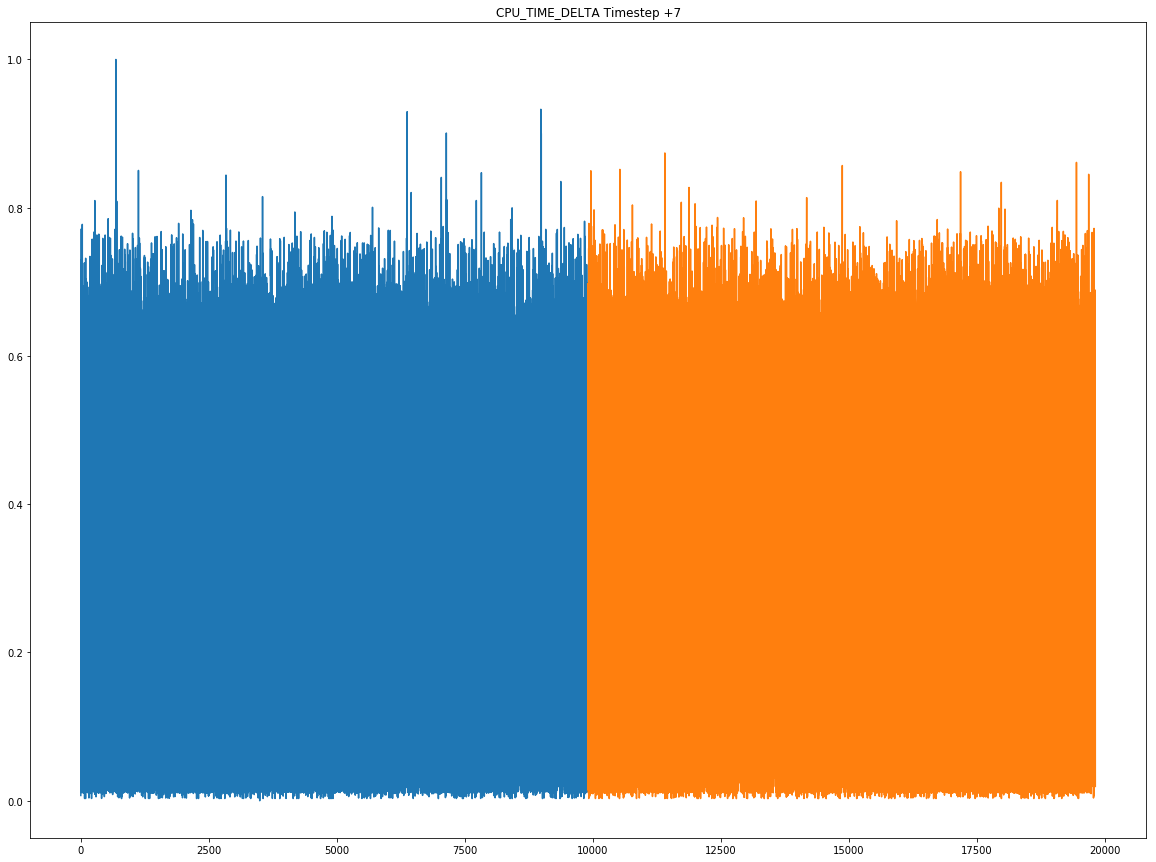

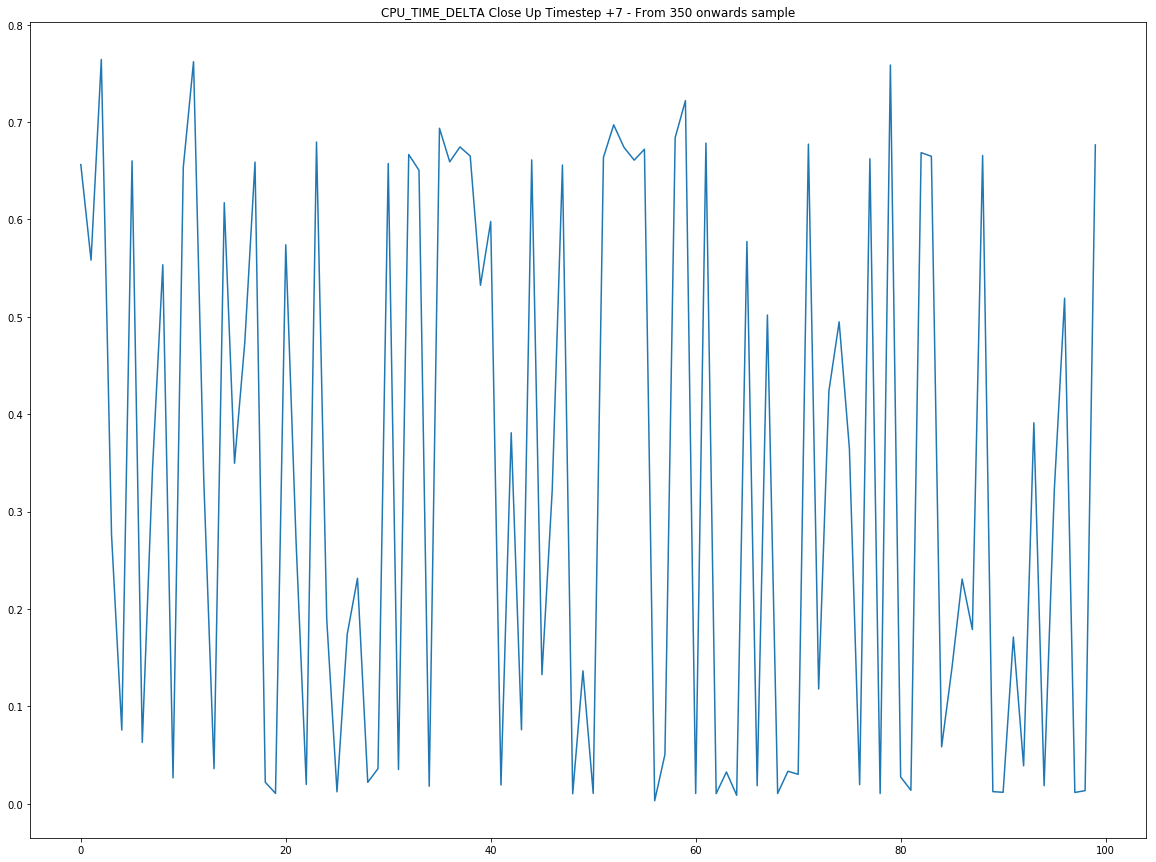

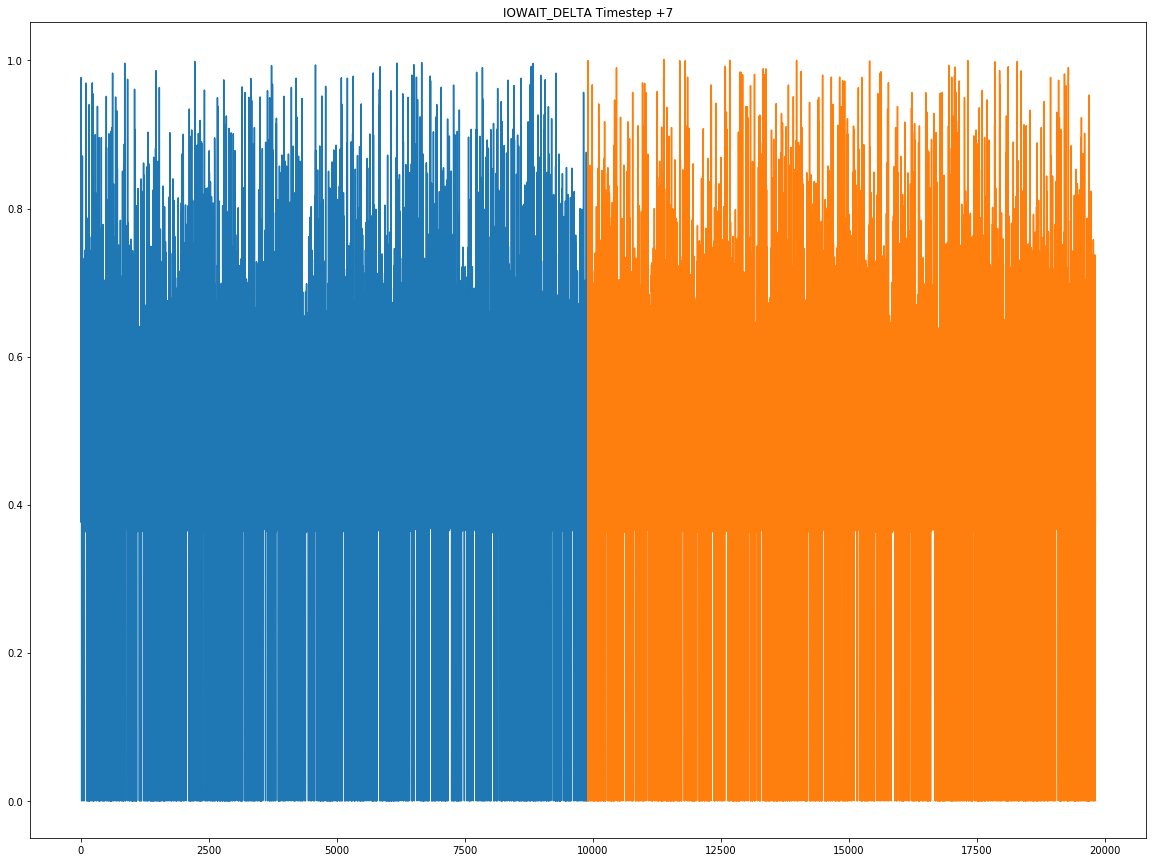

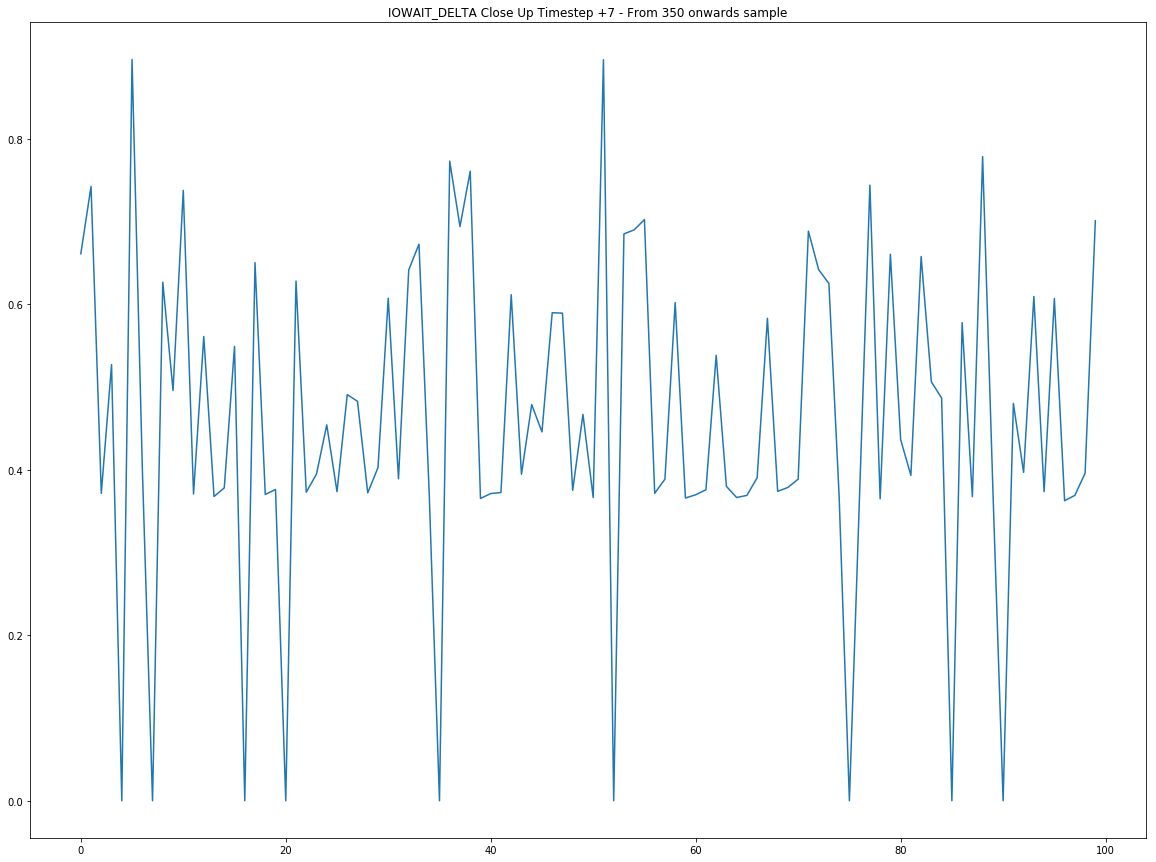

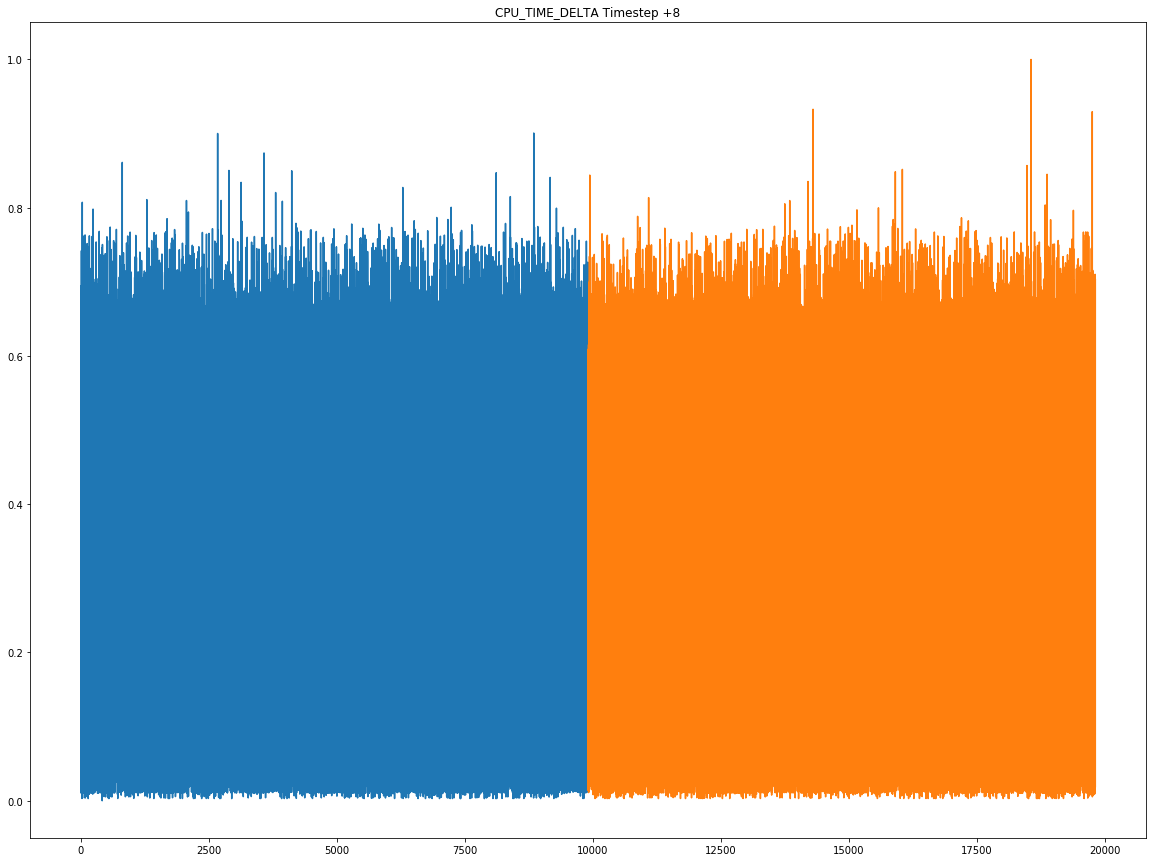

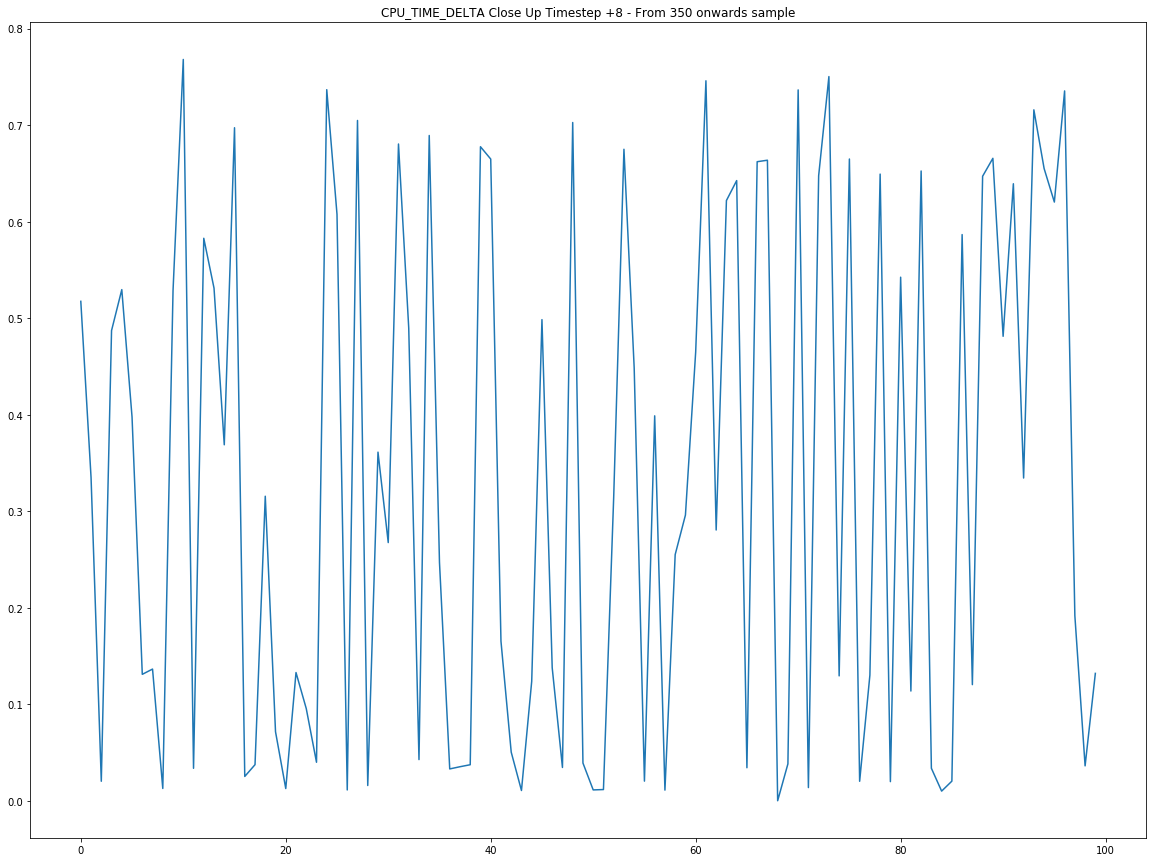

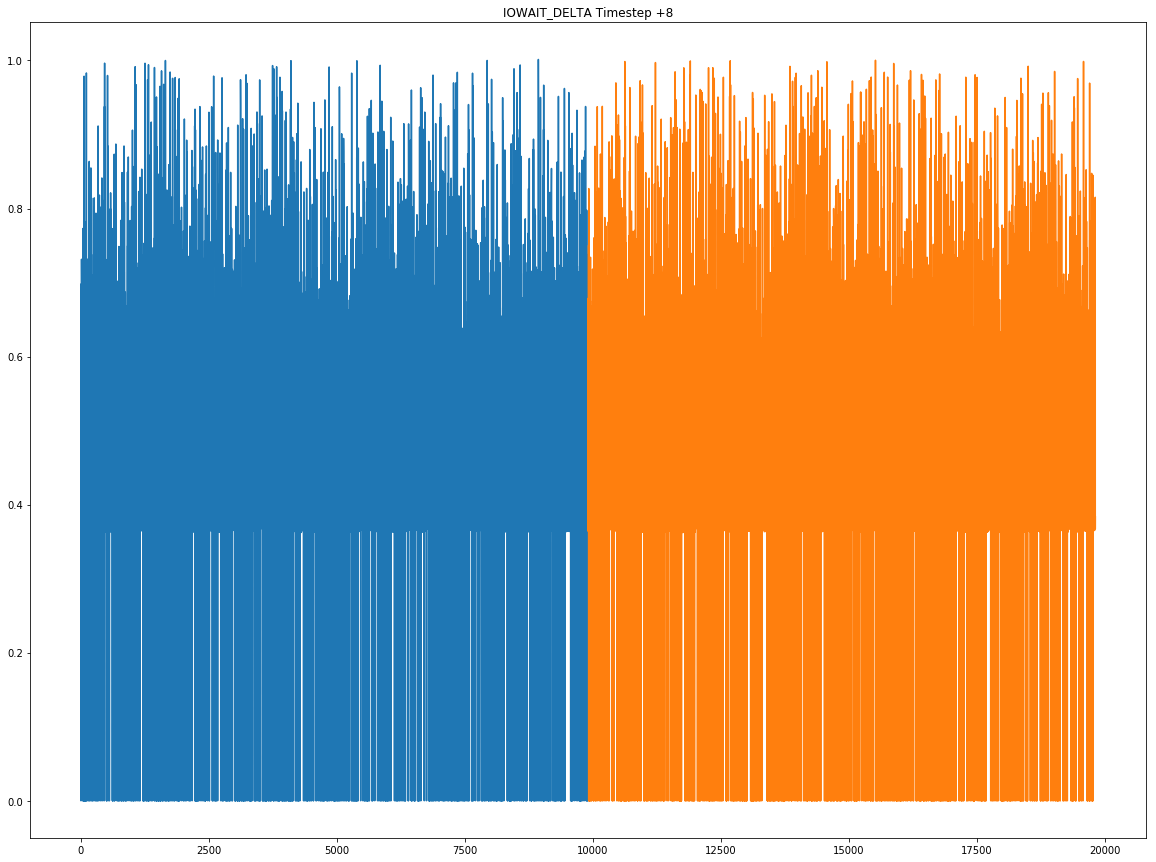

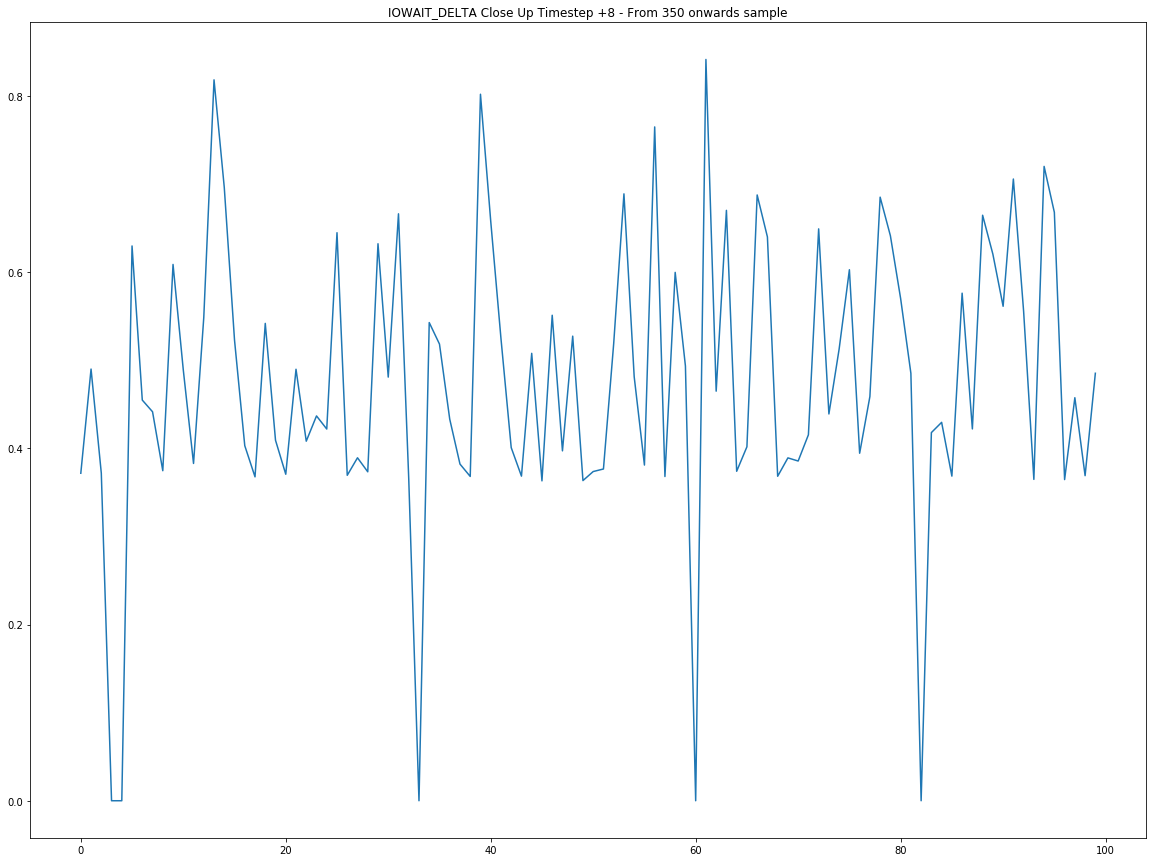

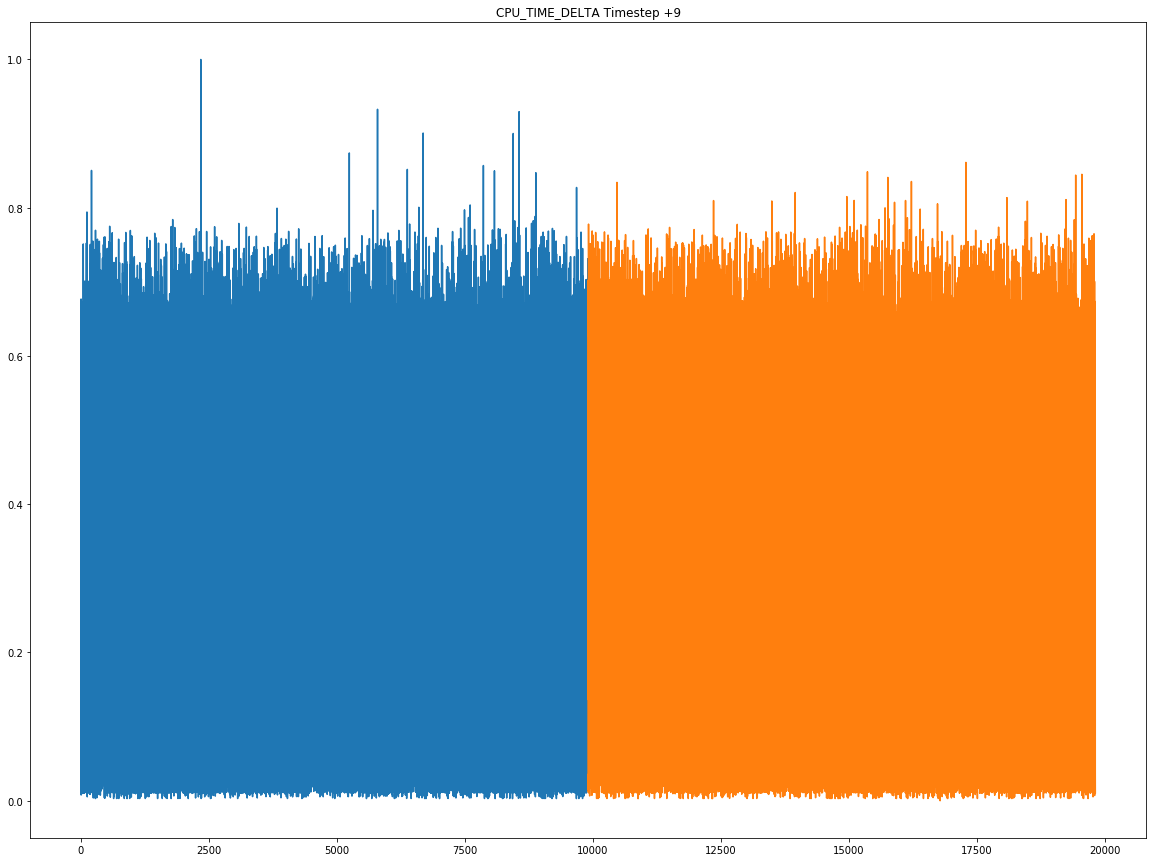

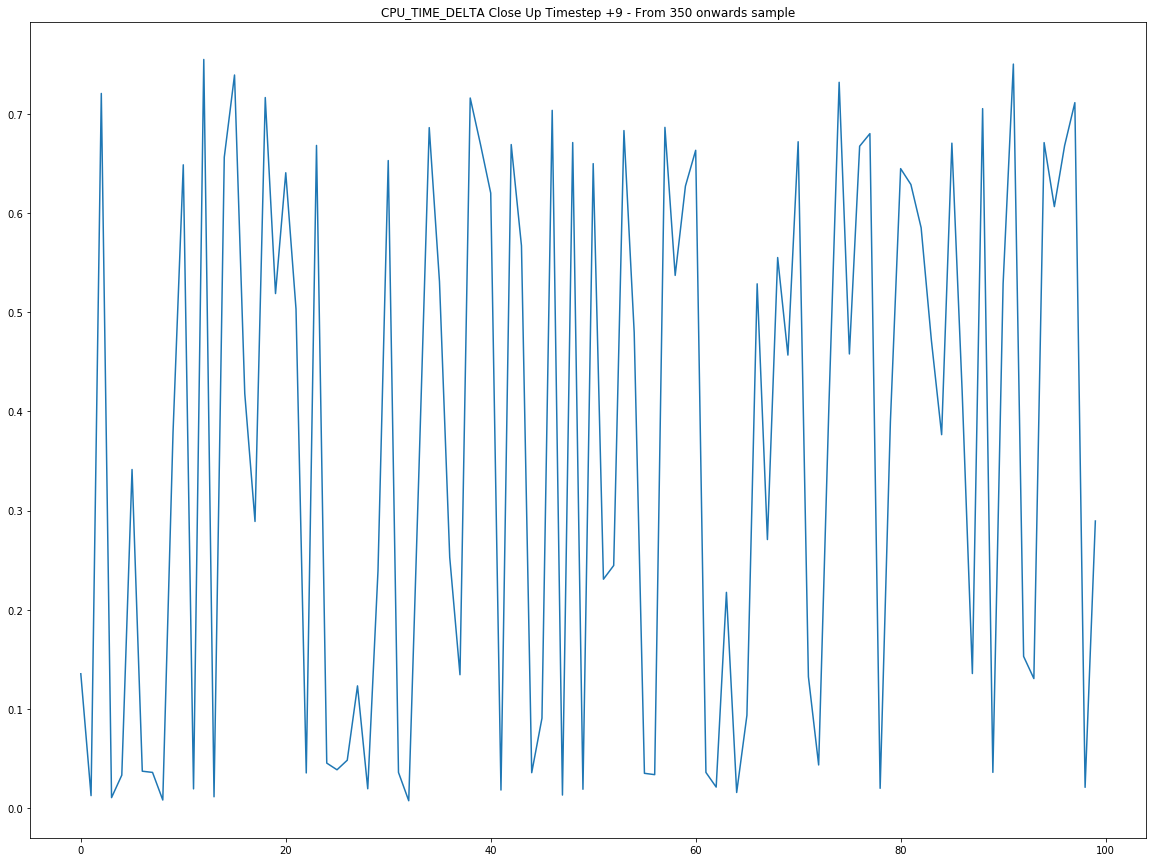

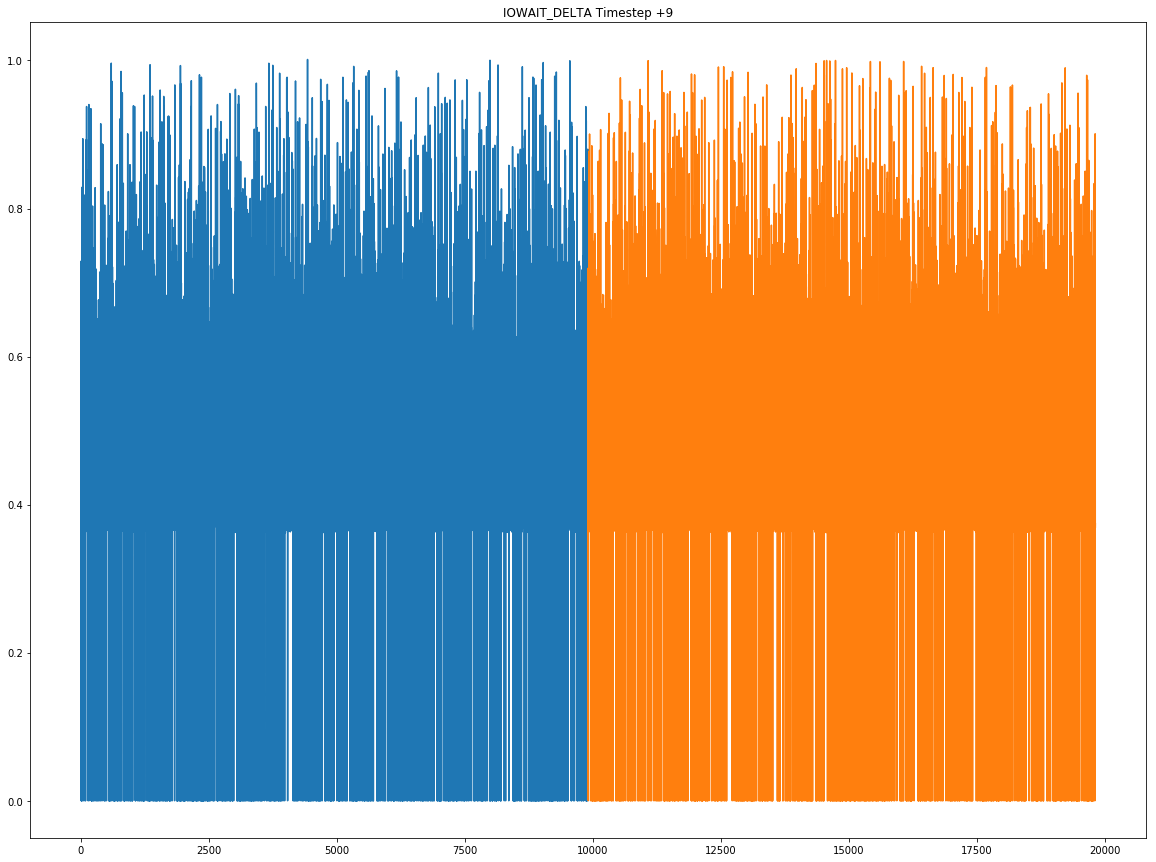

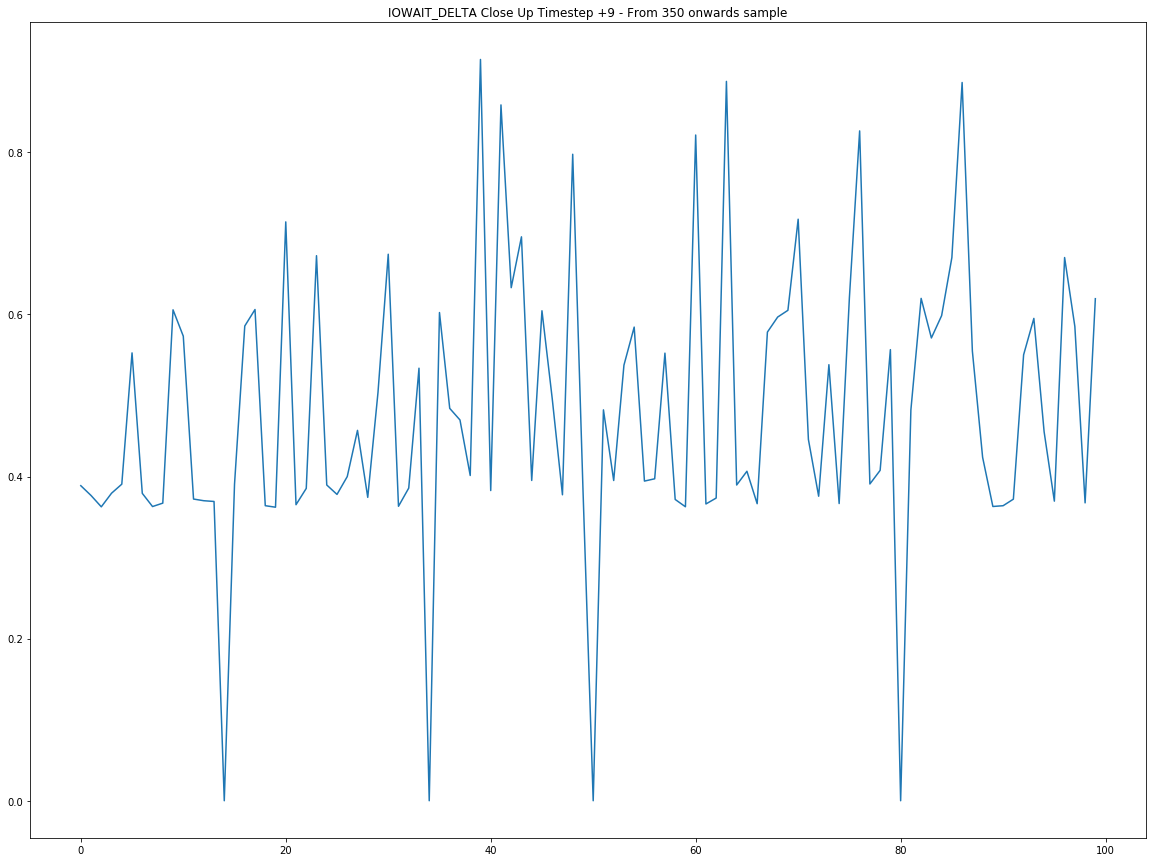

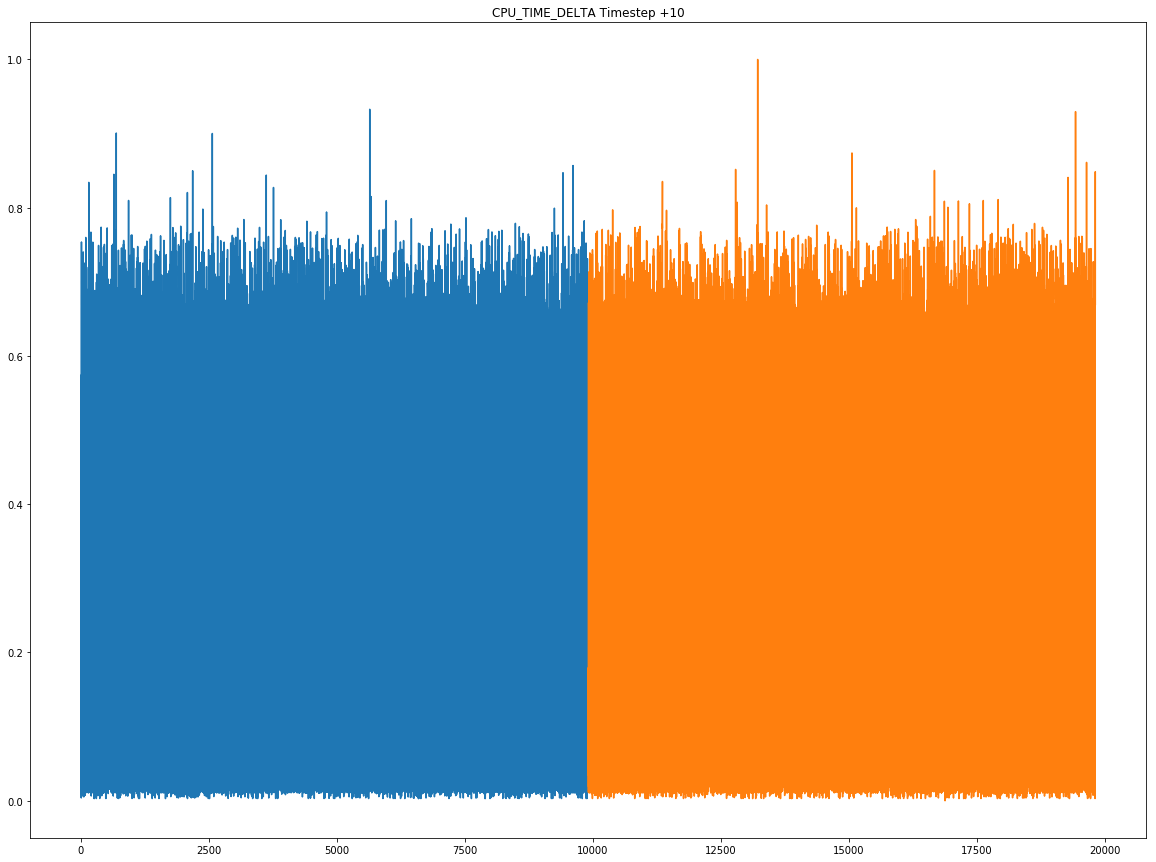

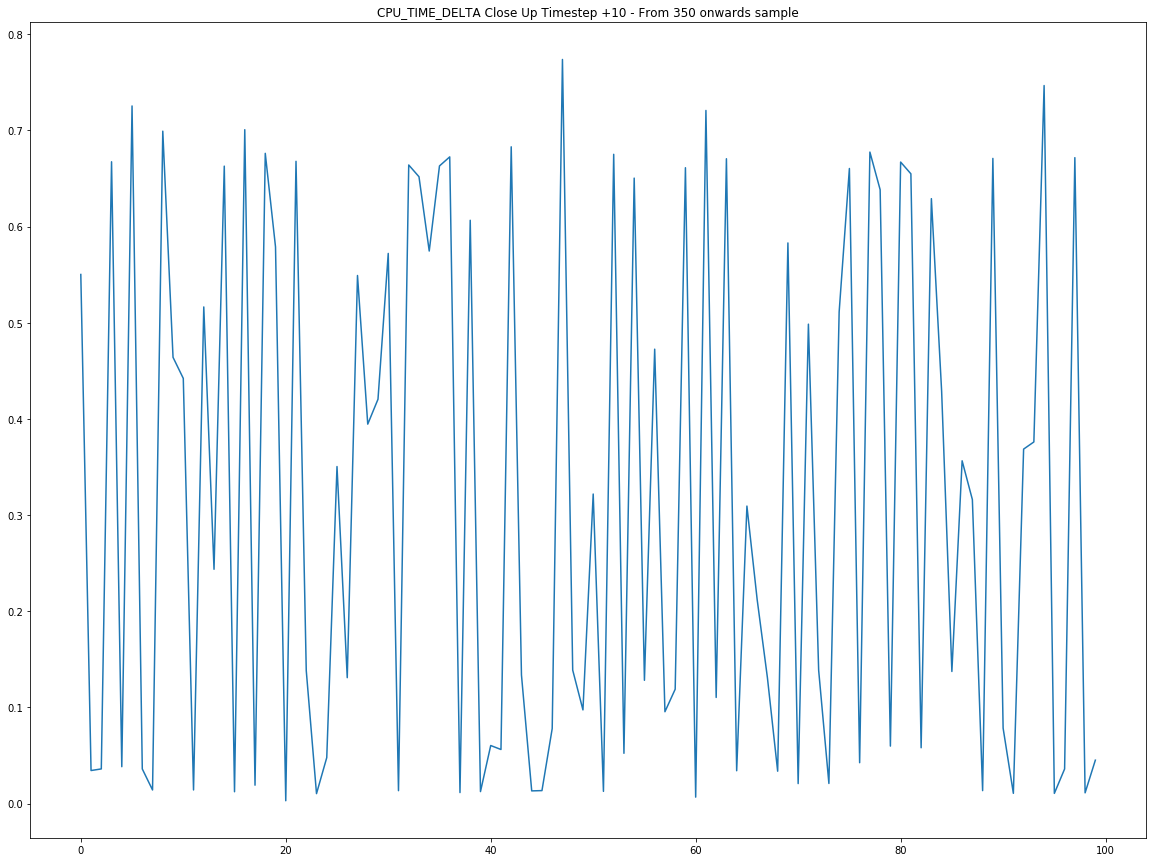

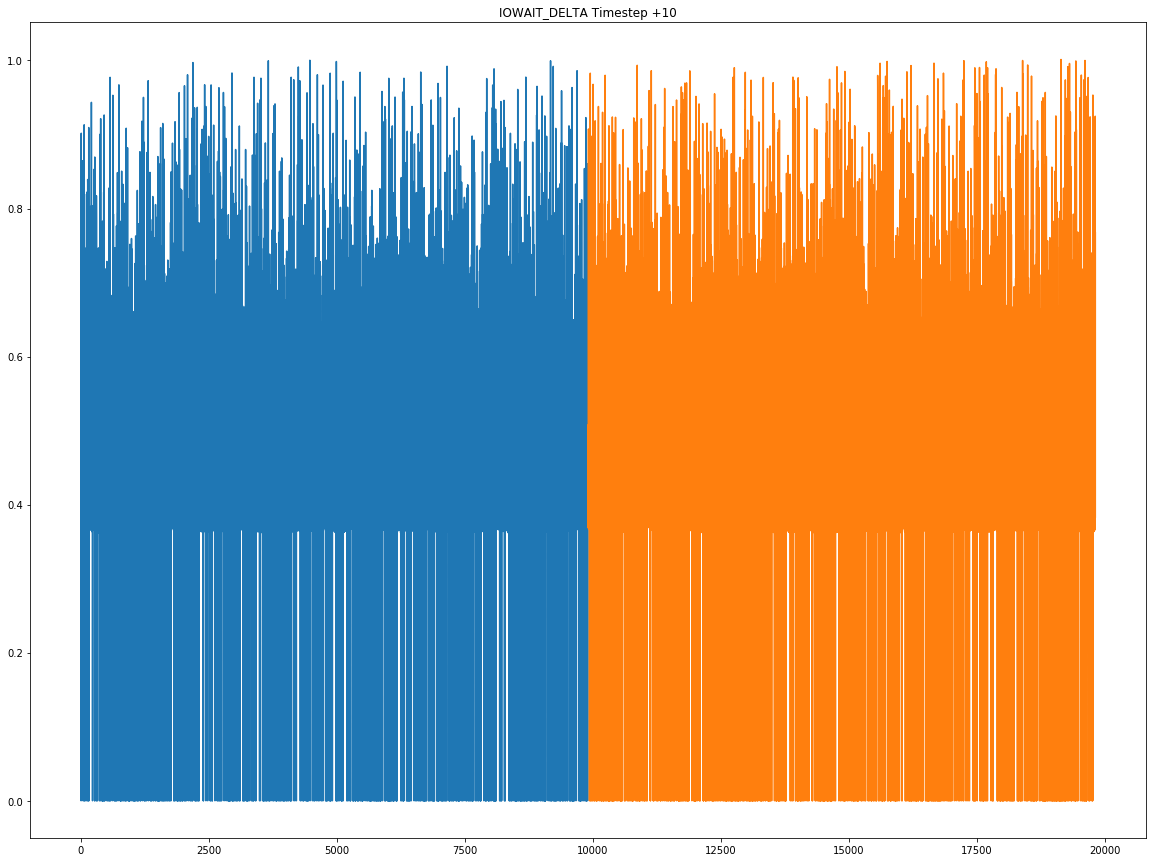

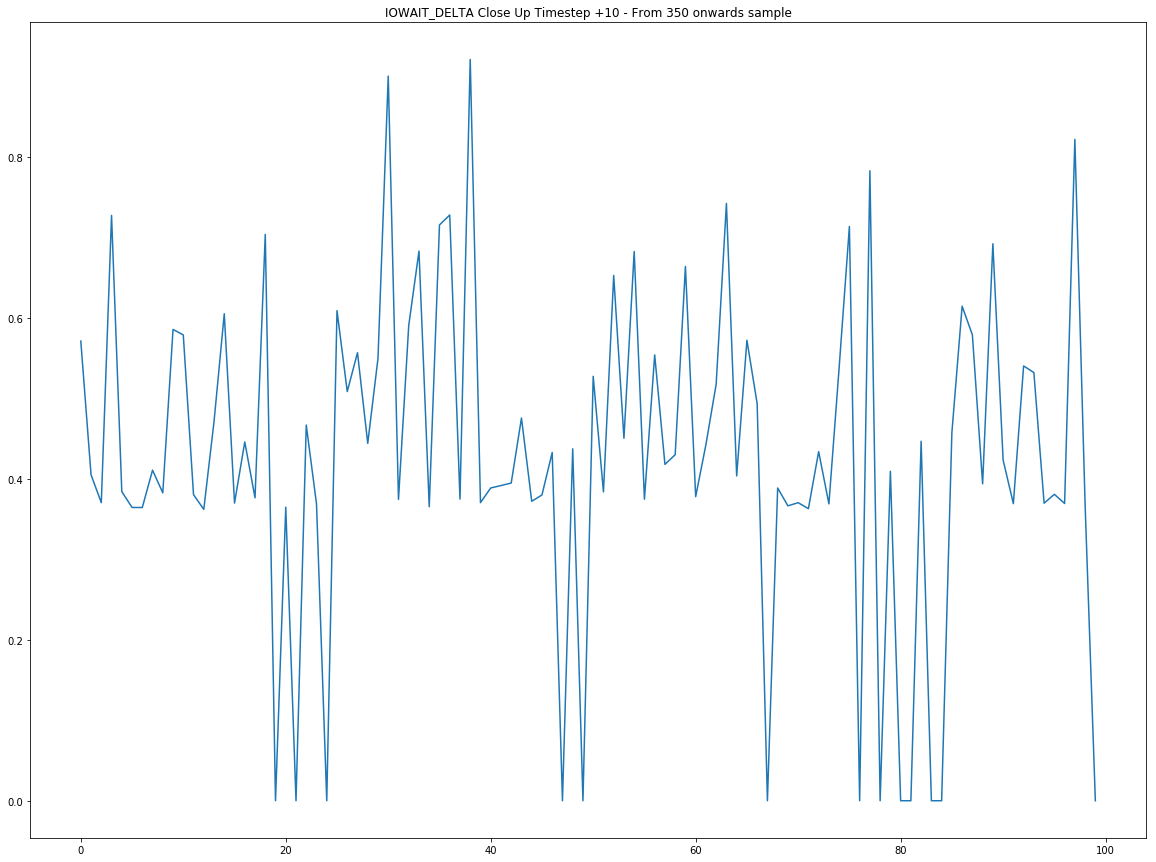

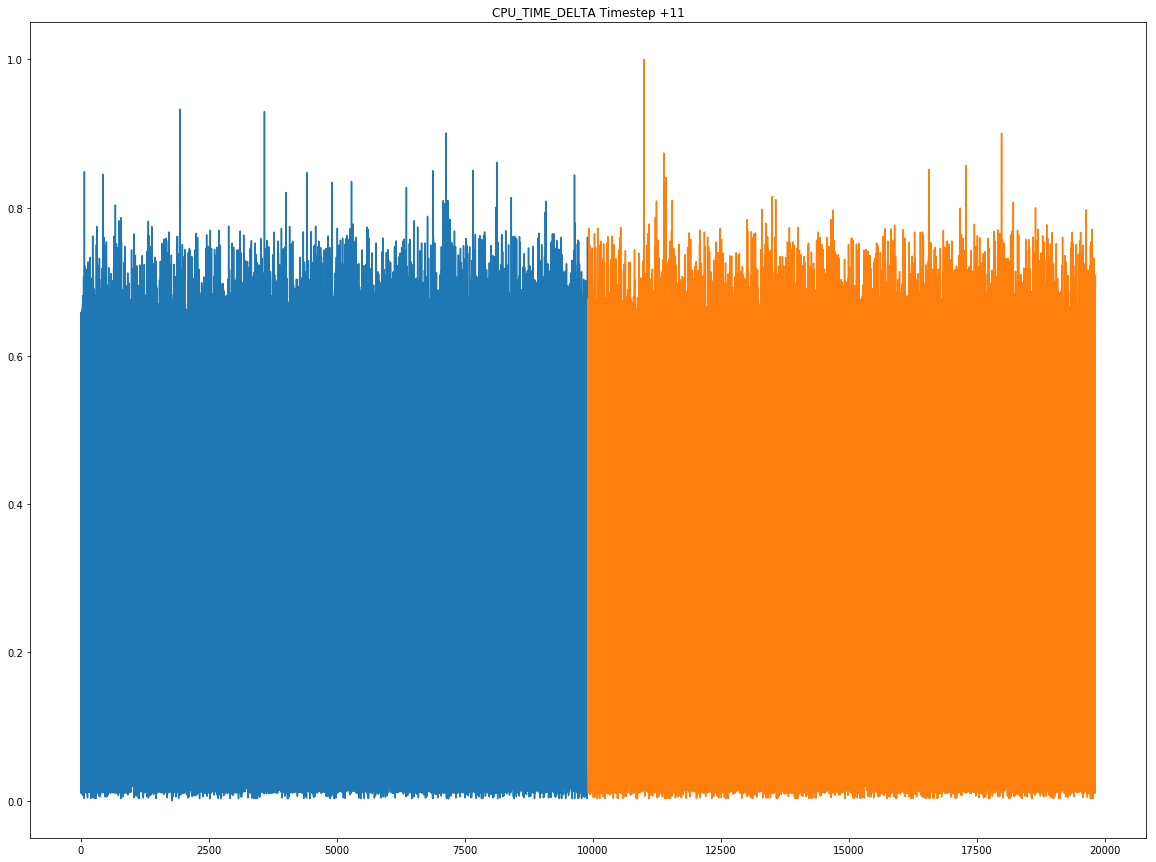

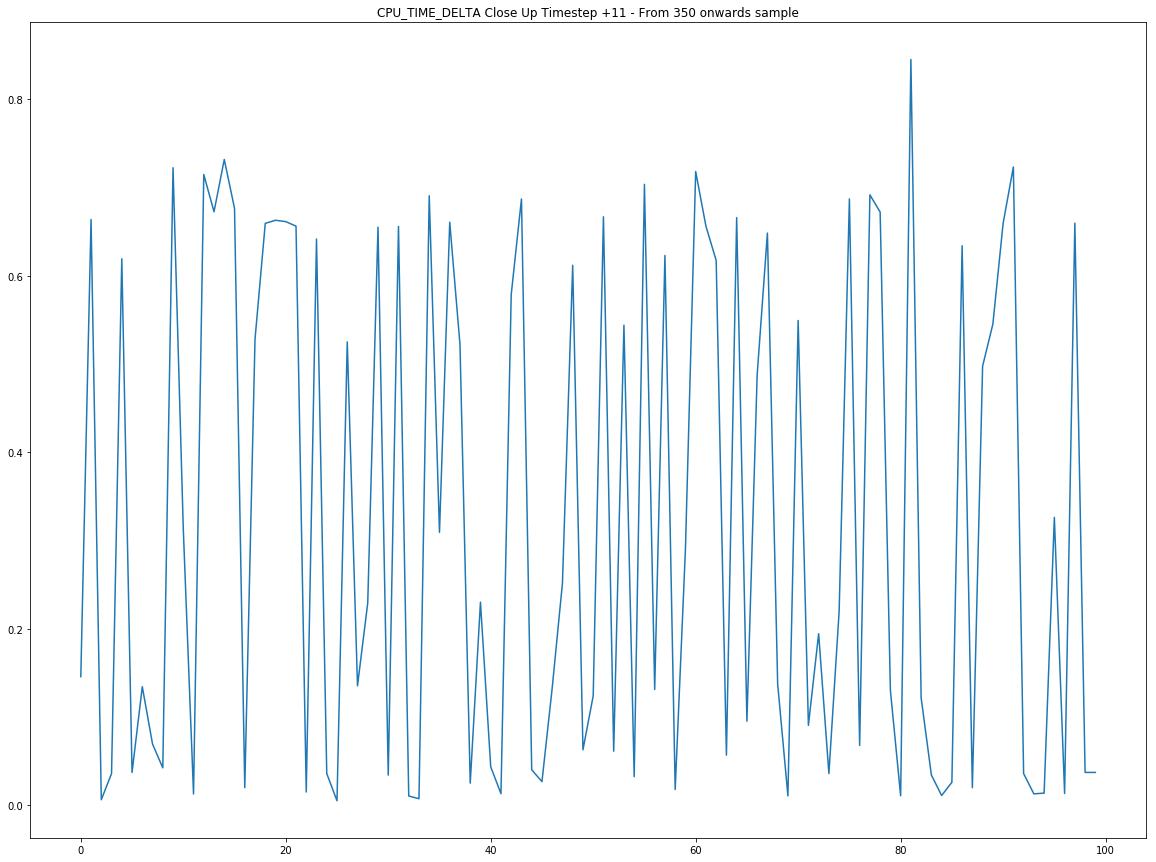

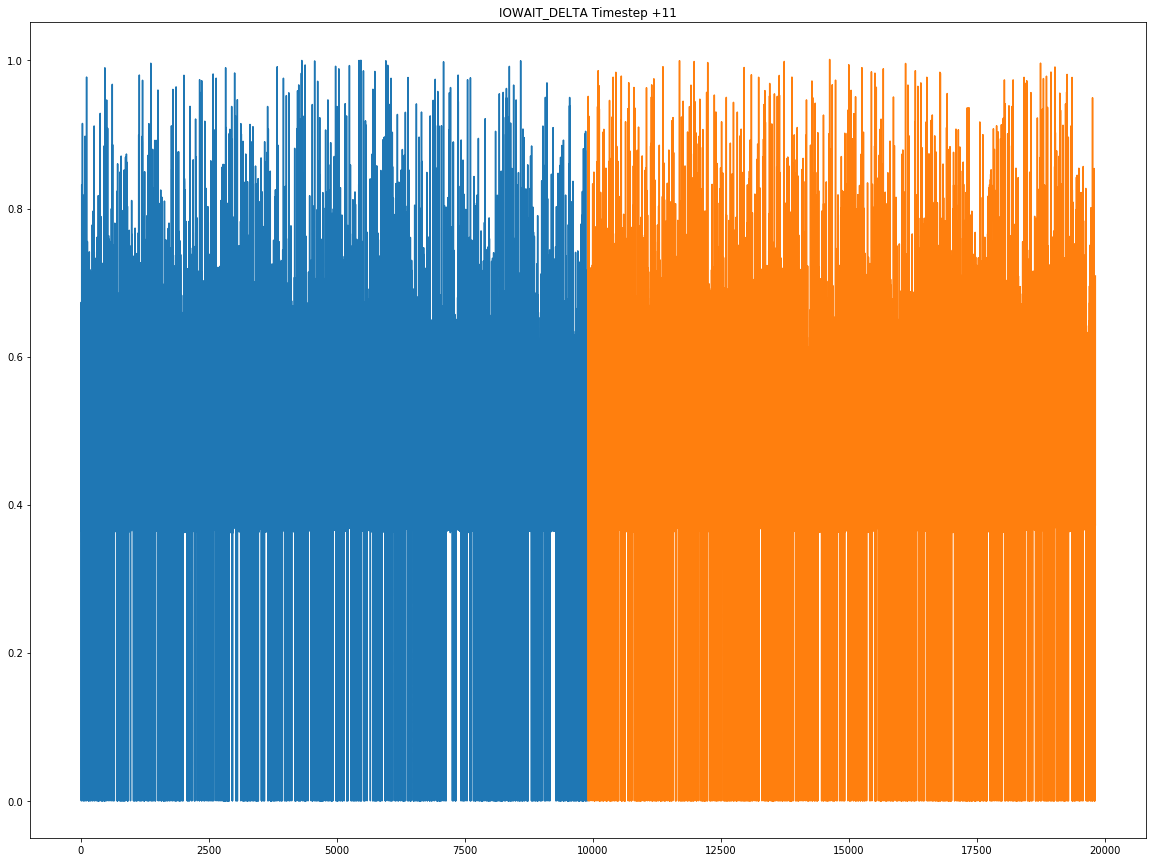

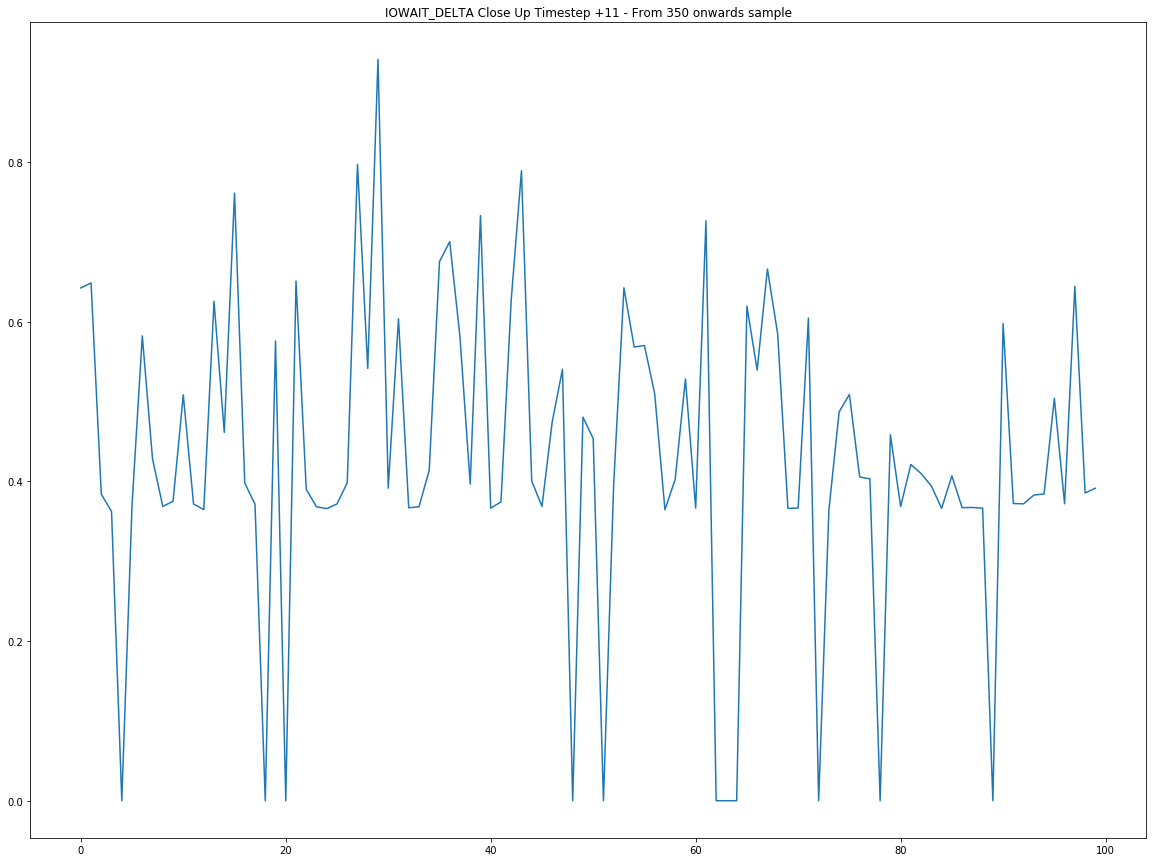

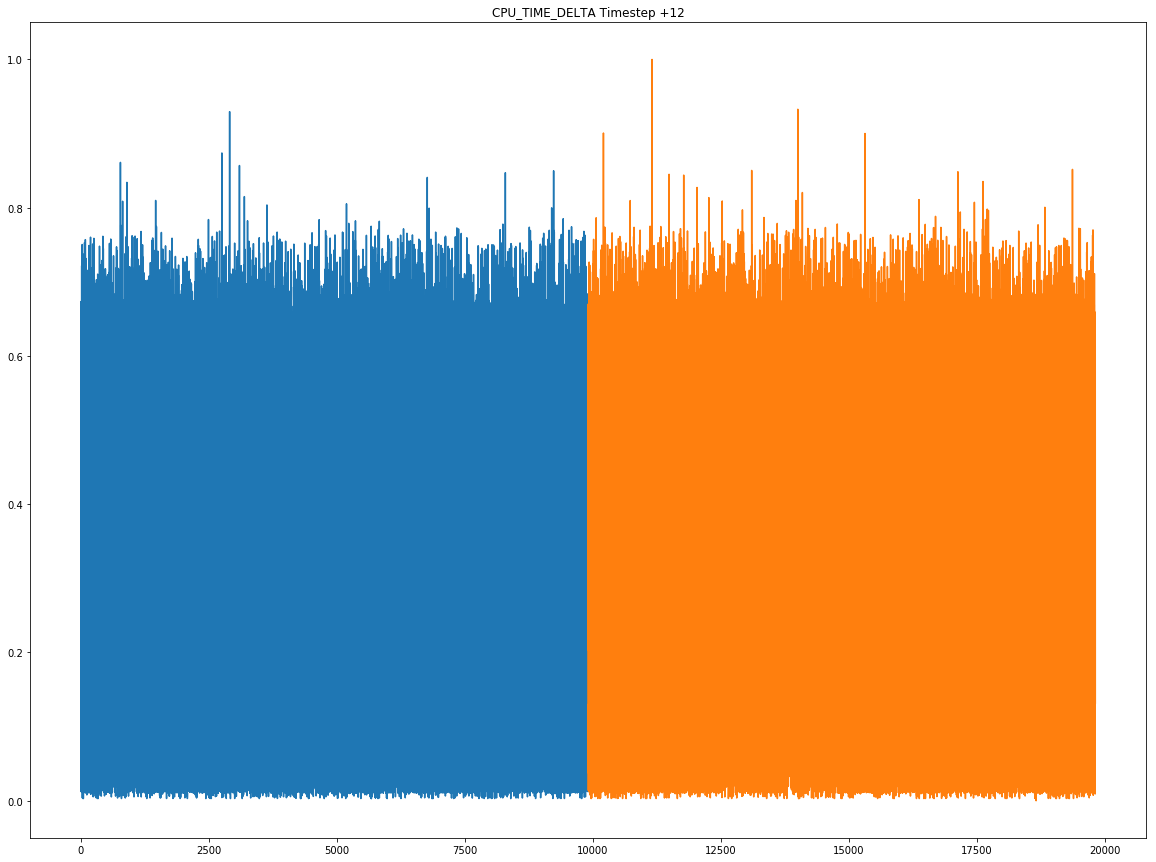

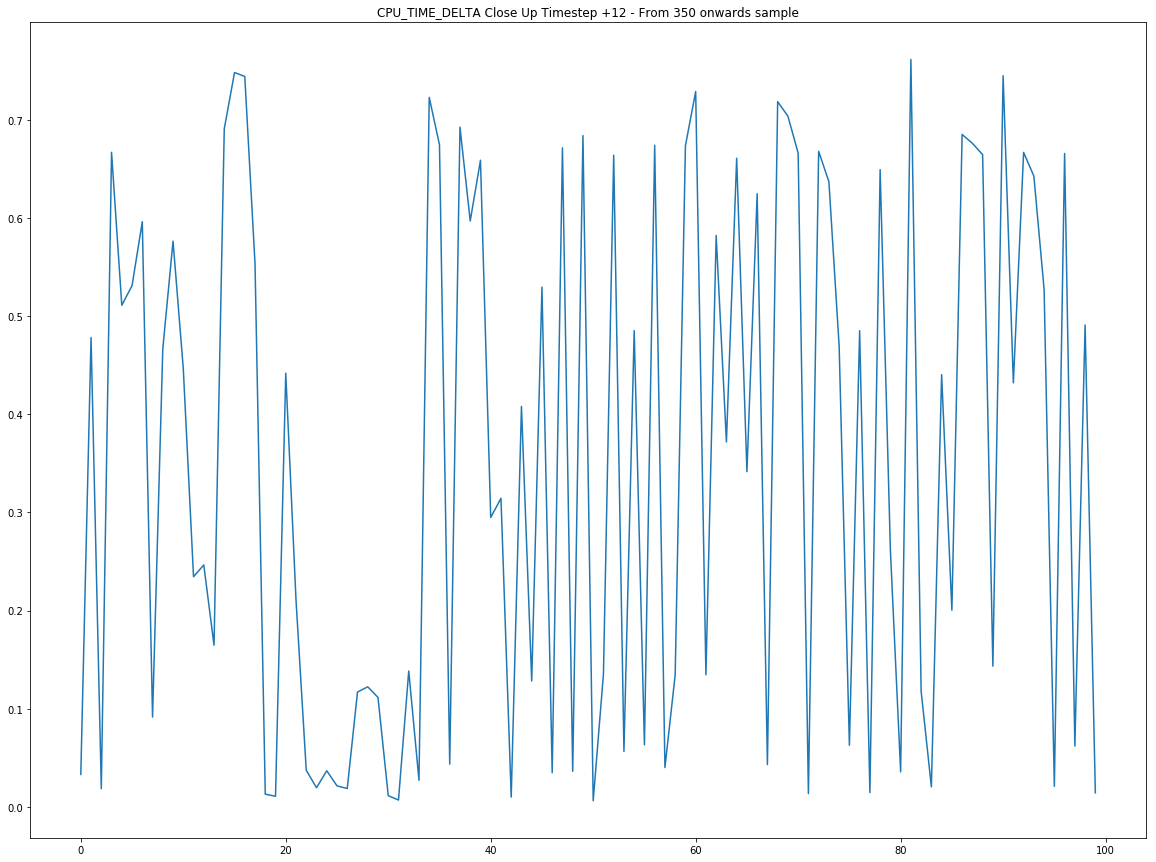

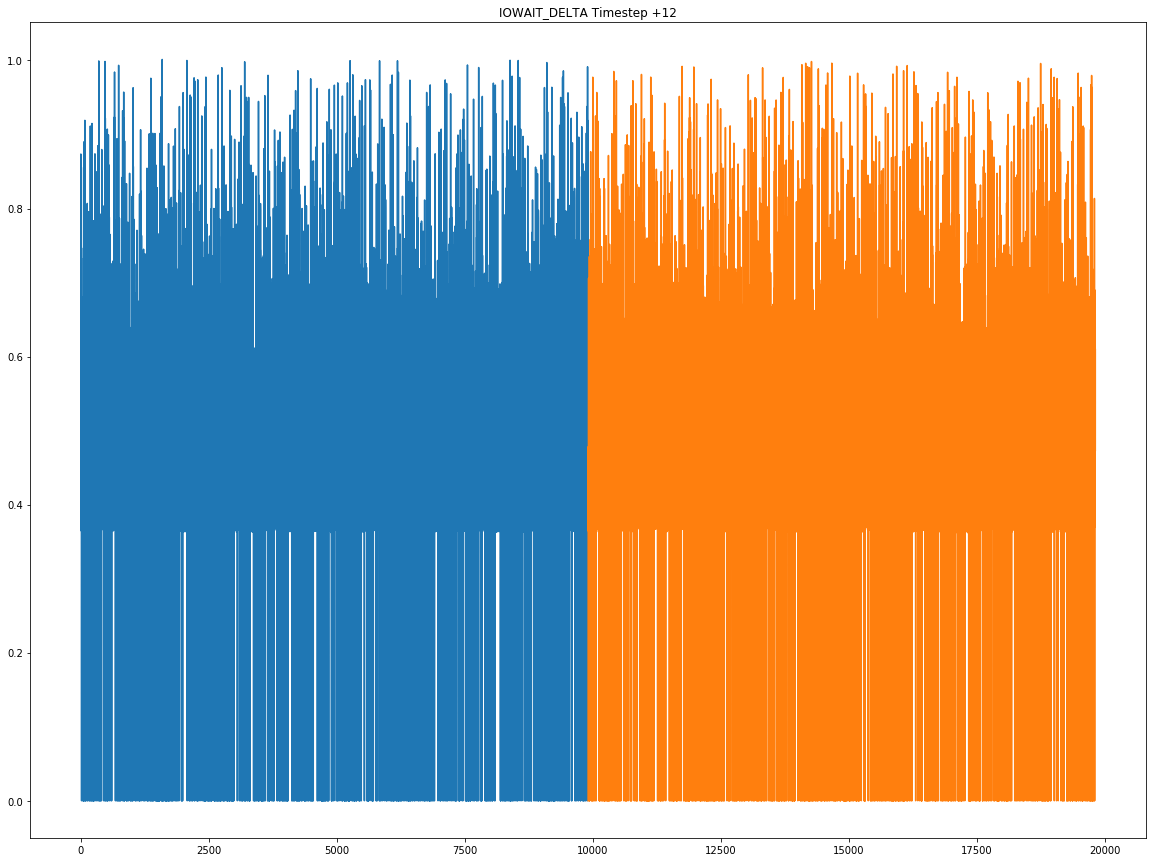

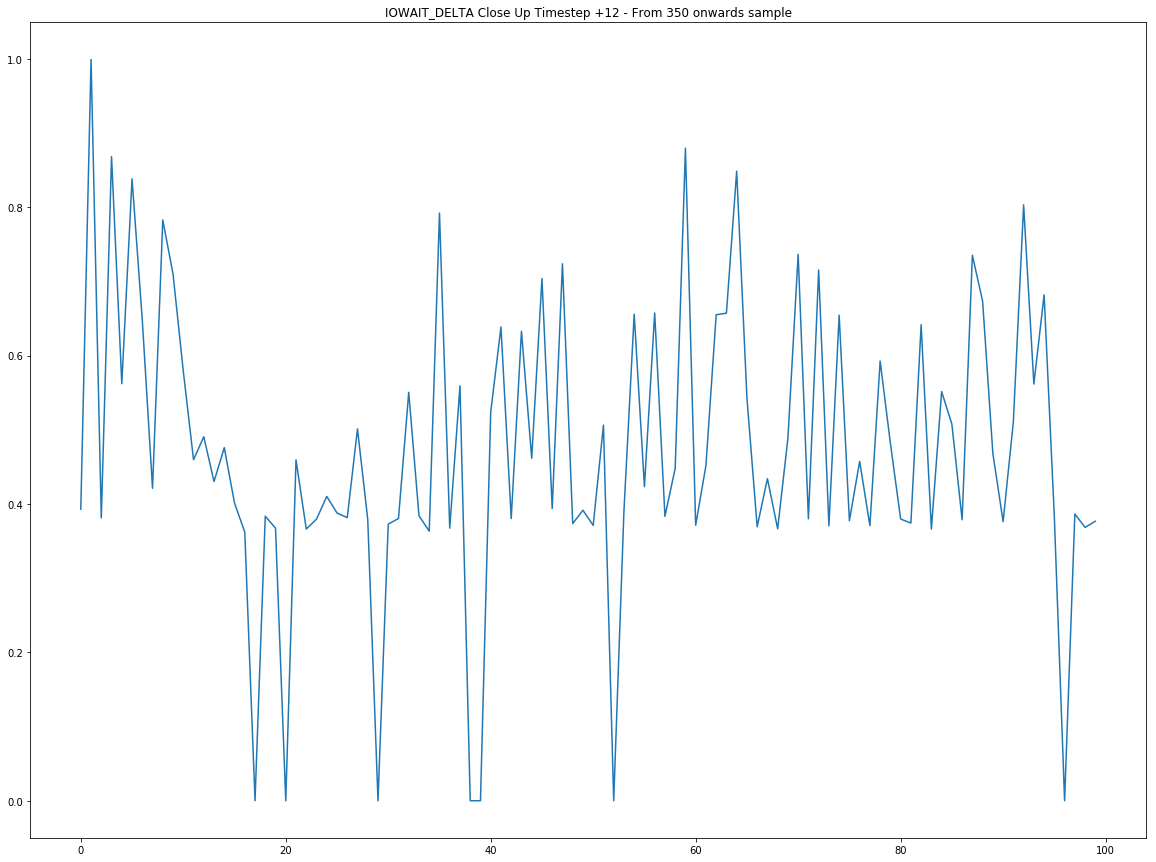

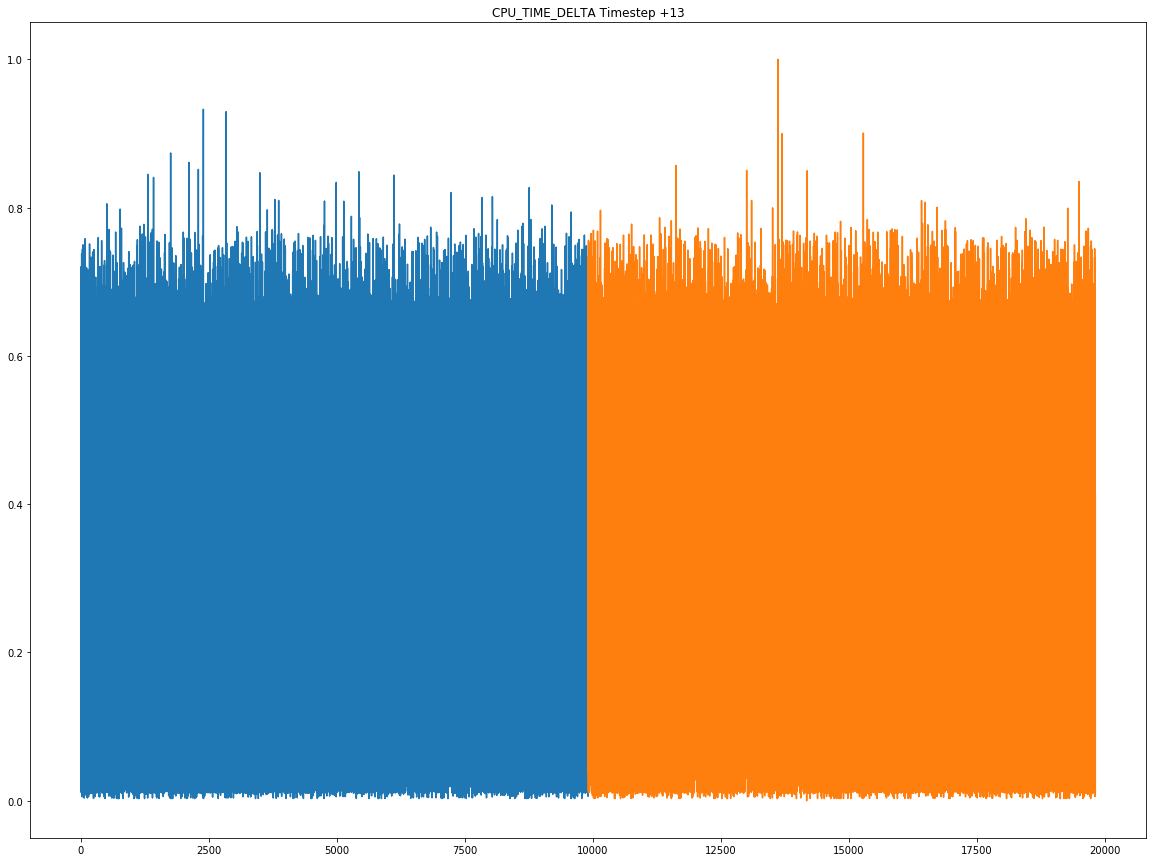

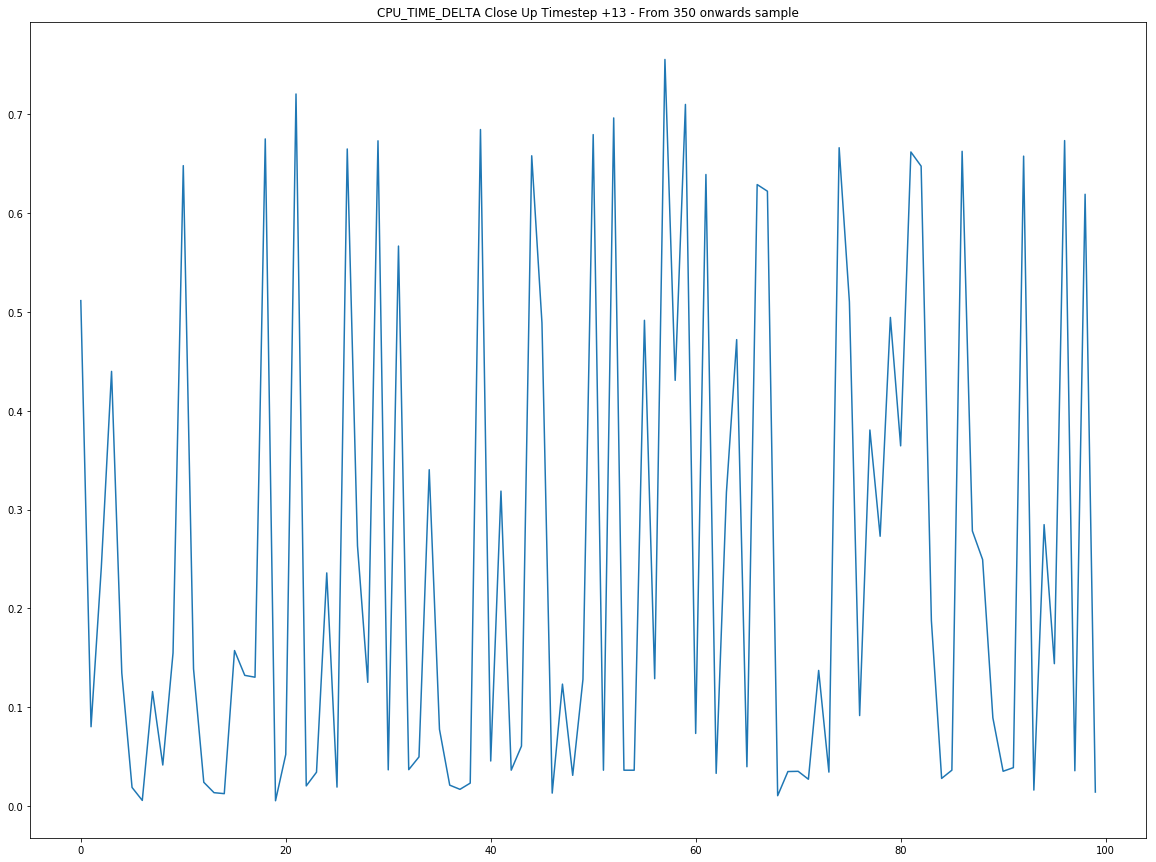

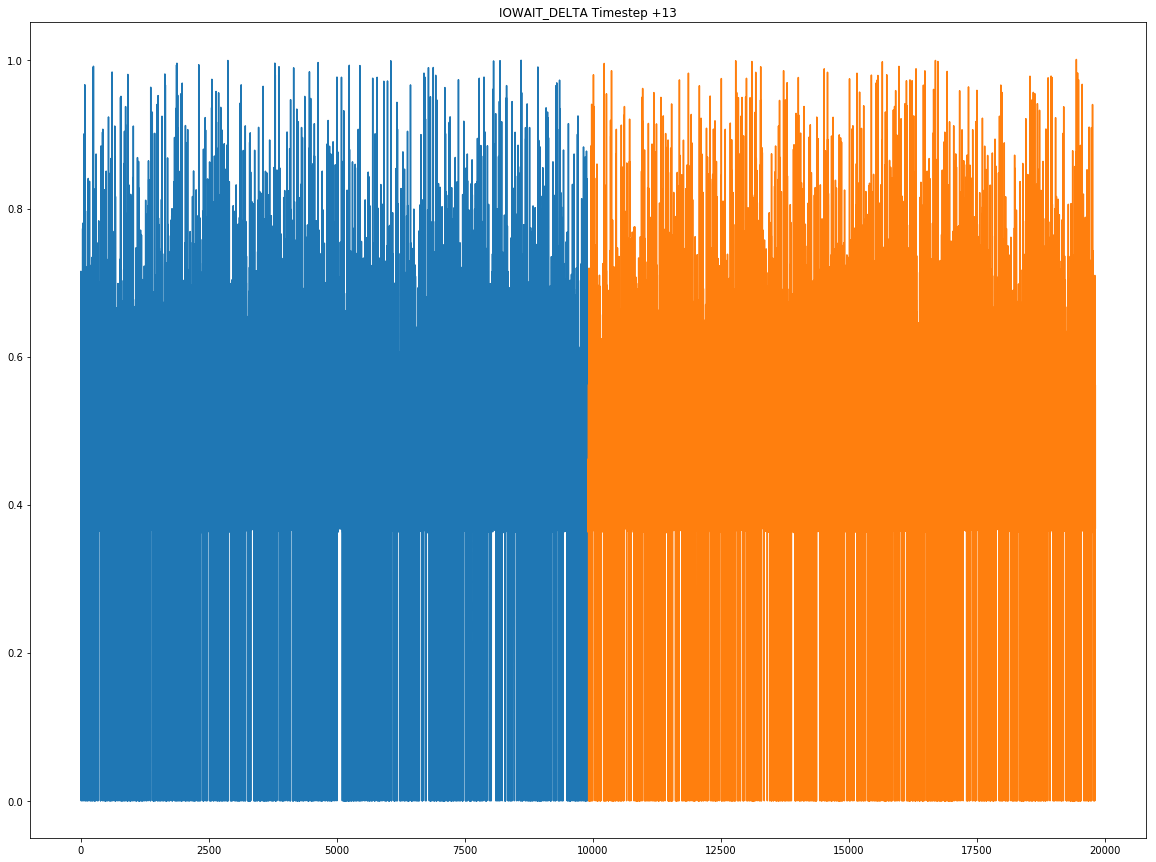

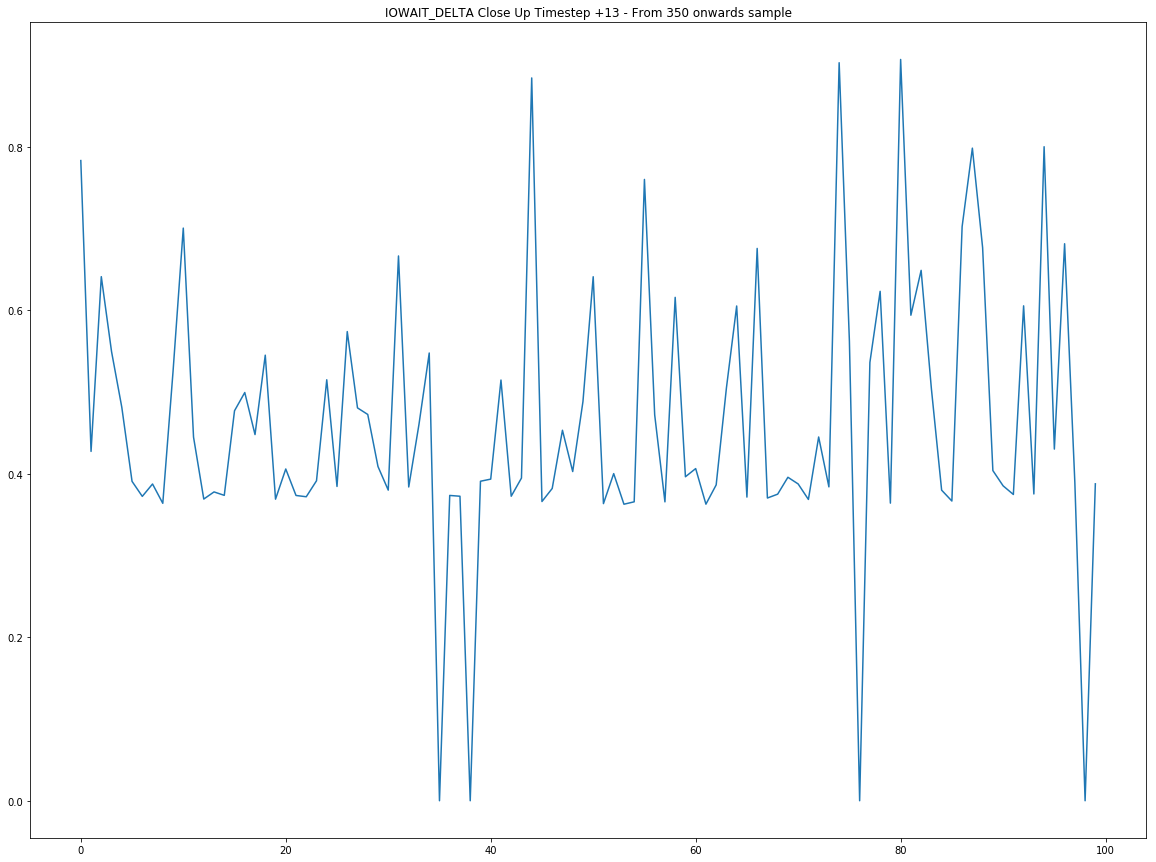

In [17]:
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
X_test = X_test.values
y_validate = y_validate.values
y_test = y_test.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)))

# Plotting label over time for train, test
for i in range(0, len(y_validate[0])):
  
    # Whole Sample
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.plot(y_train[:,i])
    validate_and_test = list(y_validate[:,i]) + list(y_test[:,i])
    plt.plot([None for j in y_train[:,i]] + [x for x in validate_and_test])
    plt.title(y_label[i%len(y_label)] + " Timestep +" + str(math.ceil((i+1)/len(y_label))))
    plt.show()
   
    # Sub-Sample (100 range)
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.plot([j for j in y_train[sub_sample_start:sub_sample_start+100,i]])
    plt.title(y_label[i%len(y_label)] + " Close Up Timestep +" + str(math.ceil((i+1)/len(y_label))) +" - From " + str(sub_sample_start) + " onwards sample")
    plt.show()

### Feature Selection

Implements a recursive solution, where in features are eliminated based on an ensemble evaluator.

In [18]:
class FeatureEliminator:
    """
    This class is dedicated to housing logic pertaining to feature selection - retaining only labels which are considered
    important.
    """
    def __init__(self, X_df, y_df):
        """
        Class constructor.
        :param X_df: (Pandas) Pandas feature matrix.
        :param y_df: (Pandas) Pandas label matrix.
        :return: None
        """
        self.__X_df = X_df
        self.__y_df = y_df
    
    def rfe_selector(self, test_split=.4, optimum_feature_count=0, parallel_degree=1, max_depth=None, max_features='sqrt', n_estimators=100):
        """
        Recursive Feature Elimination Function. Isolates and eliminated features one by one, up till the desired amount, starting
        by features which are considered less important.
        :param test_split:            (Float) Denotes training/testing data split.
        :param optimum_feature_count: (Integer) Denotes the best estimated number of features to retain before a performance drop
                                                is estimated.
        :param parallel_degree:       (Integer) Denotes model training parallel degree.
        :param max_depth:             (Integer) Denotes number of leaves to evaluate during decision tree pruning.
        :param max_features:          (Integer) Denotes number of features to consider during random subselection.
        :param n_estimators:          (Integer) Number of estimators (trees) to build for decision making.
        :return: (List) This list is composed of boolean values, which correspond to the input feature column headers. True List 
                        values denote columns which have been retained. False values denote eliminated feature headers.
        :return: (List) This list denotes feature rankings, which correspond to the input feature column headers. Values of '1',
                        denote that features have been retained.
        """
        X_df = self.__X_df.values
        y_df = self.__y_df[self.__y_df.columns[0]].values  # We can only use a single target column since RandomForests do not support multi target labels
        print(X_df.shape)
        print(y_df.shape)
        optimum_feature_count = int(optimum_feature_count)
        
        X_train, X_test, y_train, y_test = train_test_split(X_df, 
                                                            y_df, 
                                                            test_size=test_split)
        model = RandomForestRegressor(n_estimators=int(n_estimators), 
                                      n_jobs=parallel_degree,
                                      max_depth=max_depth,
                                      max_features='sqrt')

        # create the RFE model and select N attributes
        rfe_model = RFE(model, optimum_feature_count, step=1)
        rfe_model = rfe_model.fit(X_train, y_train)

        # summarize the selection of the attributes
        print(rfe_model.support_)
        print(rfe_model.ranking_)

        # evaluate the model on testing set
        pred_y = rfe_model.predict(X_test)
        predictions = [round(value) for value in pred_y]
        r2s = r2_score(y_test, predictions)
        
        return rfe_model.support_, rfe_model.ranking_
    
    def get_selected_features(self, column_mask):
        """
        Retrieves features which have not been eliminated from the RFE function.
        :param column_mask: (List) This list is composed of boolean values, which correspond to the input feature column headers. 
                                   True list values denote columns which have been retained. False values denote eliminated 
                                   feature headers. 
        :return: (Pandas) Pandas data matrix.
        """
        recommended_columns = []
        for i in range(len(self.__X_df.columns)):
            if (column_mask[i]):
                recommended_columns.append(self.__X_df.columns[i])
                
        return self.__X_df[recommended_columns]
    
# fe = FeatureEliminator(X_df=X_df,
#                        y_df=y_df)
# column_mask, column_rankings = fe.rfe_selector(test_split=test_split,
#                                                optimum_feature_count=int(X_df.shape[1]/8),
#                                                parallel_degree=2,
#                                                max_depth=1,
#                                                max_features='sqrt',
#                                                n_estimators=n_estimators)
# print(X_df.columns)
# X_df = fe.get_selected_features(column_mask=column_mask)
# print(X_df.columns)
recursively_eliminated_columns = ['var175(t-4)', 'var176(t-4)', 'var177(t-4)', 'var178(t-4)', 'var179(t-4)', 'var180(t-4)', 'var181(t-4)', 'var182(t-4)', 'var183(t-4)', 'var184(t-4)', 'var185(t-4)', 'var186(t-4)', 'var187(t-4)', 'var188(t-4)', 'var189(t-4)', 'var190(t-4)', 'var191(t-4)', 'var192(t-4)', 'var193(t-4)', 'var195(t-4)', 'var196(t-4)', 'var197(t-4)', 'var198(t-4)', 'var199(t-4)', 'var200(t-4)', 'var201(t-4)', 'var202(t-4)', 'var203(t-4)', 'var204(t-4)', 'var205(t-4)', 'var206(t-4)', 'var207(t-4)', 'var208(t-4)', 'var209(t-4)', 'var210(t-4)', 'var211(t-4)', 'var212(t-4)', 'var213(t-4)', 'var214(t-4)', 'var215(t-4)', 'var217(t-4)', 'var218(t-4)', 'var219(t-4)', 'var220(t-4)', 'var221(t-4)', 'var222(t-4)', 'var223(t-4)', 'var224(t-4)', 'var225(t-4)', 'var226(t-4)', 'var227(t-4)', 'var228(t-4)', 'var229(t-4)', 'var230(t-4)', 'var235(t-4)', 'var238(t-4)', 'var240(t-4)', 'var241(t-4)', 'var243(t-4)', 'var244(t-4)', 'var245(t-4)', 'var246(t-4)', 'var247(t-4)', 'var248(t-4)', 'var250(t-4)', 'var252(t-4)', 'var253(t-4)', 'var254(t-4)', 'var255(t-4)', 'var256(t-4)', 'var258(t-4)', 'var259(t-4)', 'var260(t-4)', 'var261(t-4)', 'var266(t-4)', 'var267(t-4)', 'var268(t-4)', 'var269(t-4)', 'var271(t-4)', 'var274(t-4)', 'var275(t-4)', 'var276(t-4)', 'var277(t-4)', 'var279(t-4)', 'var282(t-4)', 'var283(t-4)', 'var284(t-4)', 'var285(t-4)', 'var286(t-4)', 'var288(t-4)', 'var289(t-4)', 'var291(t-4)', 'var292(t-4)', 'var293(t-4)', 'var294(t-4)', 'var297(t-4)', 'var298(t-4)', 'var299(t-4)', 'var301(t-4)', 'var303(t-4)', 'var304(t-4)', 'var308(t-4)', 'var309(t-4)', 'var310(t-4)', 'var311(t-4)', 'var312(t-4)', 'var313(t-4)', 'var314(t-4)', 'var315(t-4)', 'var316(t-4)', 'var317(t-4)', 'var318(t-4)', 'var319(t-4)', 'var320(t-4)', 'var321(t-4)', 'var324(t-4)', 'var325(t-4)', 'var326(t-4)', 'var327(t-4)', 'var328(t-4)', 'var329(t-4)', 'var335(t-4)', 'var336(t-4)', 'var337(t-4)', 'var338(t-4)', 'var339(t-4)', 'var342(t-4)', 'var343(t-4)', 'var344(t-4)', 'var345(t-4)', 'var346(t-4)', 'var347(t-4)', 'var348(t-4)', 'var349(t-4)', 'var350(t-4)', 'var352(t-4)', 'var353(t-4)', 'var355(t-4)', 'var356(t-4)', 'var357(t-4)', 'var358(t-4)', 'var361(t-4)', 'var363(t-4)', 'var366(t-4)', 'var367(t-4)', 'var368(t-4)', 'var369(t-4)', 'var370(t-4)', 'var371(t-4)', 'var372(t-4)', 'var374(t-4)', 'var376(t-4)', 'var377(t-4)', 'var378(t-4)', 'var379(t-4)', 'var383(t-4)', 'var385(t-4)', 'var386(t-4)', 'var389(t-4)', 'var390(t-4)', 'var391(t-4)', 'var392(t-4)', 'var393(t-4)', 'var394(t-4)', 'var397(t-4)', 'var401(t-4)', 'var402(t-4)', 'var403(t-4)', 'var404(t-4)', 'var405(t-4)', 'var406(t-4)', 'var407(t-4)', 'var408(t-4)', 'var409(t-4)', 'var410(t-4)', 'var411(t-4)', 'var412(t-4)', 'var413(t-4)', 'var414(t-4)', 'var415(t-4)', 'var416(t-4)', 'var417(t-4)', 'var418(t-4)', 'var419(t-4)', 'var420(t-4)', 'var421(t-4)', 'var422(t-4)', 'var423(t-4)', 'var424(t-4)', 'var425(t-4)', 'var426(t-4)', 'var427(t-4)', 'var428(t-4)', 'var429(t-4)', 'var430(t-4)', 'var431(t-4)', 'var432(t-4)', 'var433(t-4)', 'var434(t-4)', 'var435(t-4)', 'var436(t-4)', 'var437(t-4)', 'var438(t-4)', 'var439(t-4)', 'var440(t-4)', 'var441(t-4)', 'var442(t-4)', 'var443(t-4)', 'var444(t-4)', 'var445(t-4)', 'var446(t-4)', 'var447(t-4)', 'var448(t-4)', 'var449(t-4)', 'var450(t-4)', 'var451(t-4)', 'var452(t-4)', 'var453(t-4)', 'var455(t-4)', 'var456(t-4)', 'var457(t-4)', 'var458(t-4)', 'var459(t-4)', 'var460(t-4)', 'var461(t-4)', 'var462(t-4)', 'var463(t-4)', 'var464(t-4)', 'var465(t-4)', 'var466(t-4)', 'var468(t-4)', 'var469(t-4)', 'var470(t-4)', 'var471(t-4)', 'var472(t-4)', 'var473(t-4)', 'var474(t-4)', 'var475(t-4)', 'var476(t-4)', 'var477(t-4)', 'var478(t-4)', 'var479(t-4)', 'var480(t-4)', 'var481(t-4)', 'var482(t-4)', 'var483(t-4)', 'var484(t-4)', 'var485(t-4)', 'var486(t-4)', 'var487(t-4)', 'var488(t-4)', 'var489(t-4)', 'var490(t-4)', 'var491(t-4)', 'var492(t-4)', 'var493(t-4)', 'var494(t-4)', 'var495(t-4)', 'var496(t-4)', 'var497(t-4)', 'var498(t-4)', 'var499(t-4)', 'var500(t-4)', 'var501(t-4)', 'var502(t-4)', 'var503(t-4)', 'var504(t-4)', 'var506(t-4)', 'var507(t-4)', 'var511(t-4)', 'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)', 'var7(t-3)', 'var8(t-3)', 'var11(t-3)', 'var12(t-3)', 'var13(t-3)', 'var14(t-3)', 'var16(t-3)', 'var19(t-3)', 'var20(t-3)', 'var22(t-3)', 'var23(t-3)', 'var25(t-3)', 'var28(t-3)', 'var30(t-3)', 'var31(t-3)', 'var37(t-3)', 'var39(t-3)', 'var41(t-3)', 'var42(t-3)', 'var45(t-3)', 'var47(t-3)', 'var48(t-3)', 'var50(t-3)', 'var52(t-3)', 'var53(t-3)', 'var54(t-3)', 'var58(t-3)', 'var59(t-3)', 'var61(t-3)', 'var62(t-3)', 'var63(t-3)', 'var66(t-3)', 'var67(t-3)', 'var68(t-3)', 'var70(t-3)', 'var72(t-3)', 'var75(t-3)', 'var77(t-3)', 'var78(t-3)', 'var79(t-3)', 'var80(t-3)', 'var86(t-3)', 'var88(t-3)', 'var89(t-3)', 'var91(t-3)', 'var92(t-3)', 'var94(t-3)', 'var95(t-3)', 'var96(t-3)', 'var98(t-3)', 'var99(t-3)', 'var100(t-3)', 'var101(t-3)', 'var102(t-3)', 'var103(t-3)', 'var106(t-3)', 'var108(t-3)', 'var109(t-3)', 'var114(t-3)', 'var115(t-3)', 'var116(t-3)', 'var117(t-3)', 'var119(t-3)', 'var120(t-3)', 'var121(t-3)', 'var122(t-3)', 'var123(t-3)', 'var124(t-3)', 'var126(t-3)', 'var127(t-3)', 'var132(t-3)', 'var133(t-3)', 'var138(t-3)', 'var144(t-3)', 'var145(t-3)', 'var148(t-3)', 'var150(t-3)', 'var154(t-3)', 'var155(t-3)', 'var158(t-3)', 'var160(t-3)', 'var162(t-3)', 'var163(t-3)', 'var164(t-3)', 'var170(t-3)', 'var171(t-3)', 'var172(t-3)', 'var173(t-3)', 'var176(t-3)', 'var177(t-3)', 'var180(t-3)', 'var181(t-3)', 'var190(t-3)', 'var191(t-3)', 'var192(t-3)', 'var193(t-3)', 'var195(t-3)', 'var196(t-3)', 'var197(t-3)', 'var198(t-3)', 'var199(t-3)', 'var200(t-3)', 'var201(t-3)', 'var202(t-3)', 'var203(t-3)', 'var204(t-3)', 'var205(t-3)', 'var206(t-3)', 'var207(t-3)', 'var208(t-3)', 'var209(t-3)', 'var210(t-3)', 'var211(t-3)', 'var212(t-3)', 'var213(t-3)', 'var214(t-3)', 'var215(t-3)', 'var216(t-3)', 'var217(t-3)', 'var218(t-3)', 'var219(t-3)', 'var220(t-3)', 'var221(t-3)', 'var222(t-3)', 'var223(t-3)', 'var224(t-3)', 'var225(t-3)', 'var226(t-3)', 'var227(t-3)', 'var228(t-3)', 'var229(t-3)', 'var230(t-3)', 'var231(t-3)', 'var232(t-3)', 'var233(t-3)', 'var234(t-3)', 'var235(t-3)', 'var236(t-3)', 'var237(t-3)', 'var238(t-3)', 'var240(t-3)', 'var241(t-3)', 'var242(t-3)', 'var243(t-3)', 'var244(t-3)', 'var245(t-3)', 'var246(t-3)', 'var247(t-3)', 'var248(t-3)', 'var249(t-3)', 'var250(t-3)', 'var251(t-3)', 'var252(t-3)', 'var253(t-3)', 'var254(t-3)', 'var256(t-3)', 'var257(t-3)', 'var258(t-3)', 'var259(t-3)', 'var261(t-3)', 'var262(t-3)', 'var264(t-3)', 'var265(t-3)', 'var266(t-3)', 'var267(t-3)', 'var268(t-3)', 'var269(t-3)', 'var270(t-3)', 'var271(t-3)', 'var272(t-3)', 'var273(t-3)', 'var274(t-3)', 'var276(t-3)', 'var277(t-3)', 'var278(t-3)', 'var279(t-3)', 'var280(t-3)', 'var281(t-3)', 'var282(t-3)', 'var283(t-3)', 'var284(t-3)', 'var285(t-3)', 'var286(t-3)', 'var287(t-3)', 'var288(t-3)', 'var289(t-3)', 'var290(t-3)', 'var291(t-3)', 'var292(t-3)', 'var293(t-3)', 'var294(t-3)', 'var295(t-3)', 'var300(t-3)', 'var301(t-3)', 'var305(t-3)', 'var306(t-3)', 'var307(t-3)', 'var309(t-3)', 'var310(t-3)', 'var311(t-3)', 'var313(t-3)', 'var314(t-3)', 'var315(t-3)', 'var317(t-3)', 'var318(t-3)', 'var319(t-3)', 'var321(t-3)', 'var327(t-3)', 'var329(t-3)', 'var330(t-3)', 'var331(t-3)', 'var335(t-3)', 'var336(t-3)', 'var337(t-3)', 'var338(t-3)', 'var339(t-3)', 'var342(t-3)', 'var344(t-3)', 'var345(t-3)', 'var347(t-3)', 'var349(t-3)', 'var351(t-3)', 'var352(t-3)', 'var354(t-3)', 'var355(t-3)', 'var356(t-3)', 'var357(t-3)', 'var363(t-3)', 'var365(t-3)', 'var366(t-3)', 'var367(t-3)', 'var369(t-3)', 'var370(t-3)', 'var371(t-3)', 'var373(t-3)', 'var374(t-3)', 'var375(t-3)', 'var376(t-3)', 'var378(t-3)', 'var379(t-3)', 'var380(t-3)', 'var382(t-3)', 'var383(t-3)', 'var384(t-3)', 'var385(t-3)', 'var386(t-3)', 'var388(t-3)', 'var391(t-3)', 'var398(t-3)', 'var403(t-3)', 'var404(t-3)', 'var405(t-3)', 'var406(t-3)', 'var407(t-3)', 'var408(t-3)', 'var409(t-3)', 'var410(t-3)', 'var411(t-3)', 'var413(t-3)', 'var414(t-3)', 'var415(t-3)', 'var417(t-3)', 'var418(t-3)', 'var420(t-3)', 'var424(t-3)', 'var425(t-3)', 'var426(t-3)', 'var428(t-3)', 'var429(t-3)', 'var431(t-3)', 'var432(t-3)', 'var434(t-3)', 'var441(t-3)', 'var443(t-3)', 'var445(t-3)', 'var446(t-3)', 'var447(t-3)', 'var448(t-3)', 'var449(t-3)', 'var450(t-3)', 'var451(t-3)', 'var454(t-3)', 'var455(t-3)', 'var461(t-3)', 'var462(t-3)', 'var467(t-3)', 'var468(t-3)', 'var469(t-3)', 'var471(t-3)', 'var472(t-3)', 'var473(t-3)', 'var475(t-3)', 'var476(t-3)', 'var478(t-3)', 'var479(t-3)', 'var480(t-3)', 'var481(t-3)', 'var482(t-3)', 'var483(t-3)', 'var484(t-3)', 'var486(t-3)', 'var488(t-3)', 'var490(t-3)', 'var491(t-3)', 'var492(t-3)', 'var493(t-3)', 'var494(t-3)', 'var495(t-3)', 'var496(t-3)', 'var497(t-3)', 'var498(t-3)', 'var499(t-3)', 'var500(t-3)', 'var503(t-3)', 'var504(t-3)', 'var505(t-3)', 'var506(t-3)', 'var507(t-3)', 'var508(t-3)', 'var509(t-3)', 'var510(t-3)', 'var511(t-3)', 'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)', 'var8(t-2)', 'var9(t-2)', 'var10(t-2)', 'var11(t-2)', 'var12(t-2)', 'var14(t-2)', 'var15(t-2)', 'var16(t-2)', 'var20(t-2)', 'var21(t-2)', 'var22(t-2)', 'var23(t-2)', 'var24(t-2)', 'var25(t-2)', 'var26(t-2)', 'var27(t-2)', 'var28(t-2)', 'var29(t-2)', 'var30(t-2)', 'var31(t-2)', 'var32(t-2)', 'var33(t-2)', 'var34(t-2)', 'var35(t-2)', 'var36(t-2)', 'var37(t-2)', 'var38(t-2)', 'var39(t-2)', 'var40(t-2)', 'var41(t-2)', 'var44(t-2)', 'var45(t-2)', 'var46(t-2)', 'var47(t-2)', 'var48(t-2)', 'var49(t-2)', 'var50(t-2)', 'var52(t-2)', 'var53(t-2)', 'var59(t-2)', 'var60(t-2)', 'var61(t-2)', 'var66(t-2)', 'var67(t-2)', 'var68(t-2)', 'var70(t-2)', 'var71(t-2)', 'var74(t-2)', 'var83(t-2)', 'var86(t-2)', 'var87(t-2)', 'var88(t-2)', 'var93(t-2)', 'var95(t-2)', 'var96(t-2)', 'var98(t-2)', 'var107(t-2)', 'var108(t-2)', 'var109(t-2)', 'var112(t-2)', 'var120(t-2)', 'var123(t-2)', 'var124(t-2)', 'var125(t-2)', 'var126(t-2)', 'var128(t-2)', 'var129(t-2)', 'var132(t-2)', 'var133(t-2)', 'var134(t-2)', 'var139(t-2)', 'var142(t-2)', 'var143(t-2)', 'var144(t-2)', 'var147(t-2)', 'var150(t-2)', 'var151(t-2)', 'var155(t-2)', 'var156(t-2)', 'var163(t-2)', 'var167(t-2)', 'var168(t-2)', 'var176(t-2)', 'var181(t-2)', 'var184(t-2)', 'var185(t-2)', 'var186(t-2)', 'var187(t-2)', 'var188(t-2)', 'var190(t-2)', 'var192(t-2)', 'var196(t-2)', 'var197(t-2)', 'var203(t-2)', 'var204(t-2)', 'var205(t-2)', 'var206(t-2)', 'var214(t-2)', 'var217(t-2)', 'var219(t-2)', 'var221(t-2)', 'var222(t-2)', 'var223(t-2)', 'var224(t-2)', 'var225(t-2)', 'var226(t-2)', 'var227(t-2)', 'var228(t-2)', 'var229(t-2)', 'var231(t-2)', 'var232(t-2)', 'var233(t-2)', 'var234(t-2)', 'var235(t-2)', 'var236(t-2)', 'var237(t-2)', 'var238(t-2)', 'var240(t-2)', 'var241(t-2)', 'var242(t-2)', 'var243(t-2)', 'var244(t-2)', 'var245(t-2)', 'var246(t-2)', 'var247(t-2)', 'var248(t-2)', 'var249(t-2)', 'var250(t-2)', 'var251(t-2)', 'var252(t-2)', 'var253(t-2)', 'var254(t-2)', 'var256(t-2)', 'var258(t-2)', 'var260(t-2)', 'var261(t-2)', 'var262(t-2)', 'var263(t-2)', 'var264(t-2)', 'var265(t-2)', 'var266(t-2)', 'var267(t-2)', 'var269(t-2)', 'var270(t-2)', 'var271(t-2)', 'var273(t-2)', 'var274(t-2)', 'var276(t-2)', 'var277(t-2)', 'var278(t-2)', 'var279(t-2)', 'var280(t-2)', 'var281(t-2)', 'var282(t-2)', 'var283(t-2)', 'var284(t-2)', 'var285(t-2)', 'var286(t-2)', 'var287(t-2)', 'var288(t-2)', 'var289(t-2)', 'var290(t-2)', 'var291(t-2)', 'var292(t-2)', 'var293(t-2)', 'var294(t-2)', 'var295(t-2)', 'var296(t-2)', 'var297(t-2)', 'var298(t-2)', 'var299(t-2)', 'var301(t-2)', 'var309(t-2)', 'var311(t-2)', 'var313(t-2)', 'var314(t-2)', 'var316(t-2)', 'var321(t-2)', 'var323(t-2)', 'var327(t-2)', 'var329(t-2)', 'var330(t-2)', 'var337(t-2)', 'var338(t-2)', 'var340(t-2)', 'var342(t-2)', 'var343(t-2)', 'var344(t-2)', 'var345(t-2)', 'var346(t-2)', 'var355(t-2)', 'var356(t-2)', 'var358(t-2)', 'var361(t-2)', 'var362(t-2)', 'var365(t-2)', 'var366(t-2)', 'var368(t-2)', 'var370(t-2)', 'var372(t-2)', 'var373(t-2)', 'var376(t-2)', 'var377(t-2)', 'var380(t-2)', 'var381(t-2)', 'var382(t-2)', 'var386(t-2)', 'var387(t-2)', 'var389(t-2)', 'var395(t-2)', 'var399(t-2)', 'var400(t-2)', 'var402(t-2)', 'var403(t-2)', 'var404(t-2)', 'var405(t-2)', 'var409(t-2)', 'var410(t-2)', 'var413(t-2)', 'var415(t-2)', 'var416(t-2)', 'var421(t-2)', 'var425(t-2)', 'var427(t-2)', 'var428(t-2)', 'var429(t-2)', 'var433(t-2)', 'var435(t-2)', 'var436(t-2)', 'var437(t-2)', 'var441(t-2)', 'var442(t-2)', 'var452(t-2)', 'var453(t-2)', 'var454(t-2)', 'var455(t-2)', 'var456(t-2)', 'var457(t-2)', 'var458(t-2)', 'var459(t-2)', 'var460(t-2)', 'var461(t-2)', 'var462(t-2)', 'var463(t-2)', 'var464(t-2)', 'var465(t-2)', 'var466(t-2)', 'var467(t-2)', 'var468(t-2)', 'var469(t-2)', 'var470(t-2)', 'var471(t-2)', 'var472(t-2)', 'var473(t-2)', 'var474(t-2)', 'var475(t-2)', 'var476(t-2)', 'var477(t-2)', 'var478(t-2)', 'var479(t-2)', 'var480(t-2)', 'var481(t-2)', 'var482(t-2)', 'var483(t-2)', 'var484(t-2)', 'var485(t-2)', 'var486(t-2)', 'var487(t-2)', 'var489(t-2)', 'var490(t-2)', 'var491(t-2)', 'var492(t-2)', 'var493(t-2)', 'var494(t-2)', 'var495(t-2)', 'var496(t-2)', 'var497(t-2)', 'var498(t-2)', 'var499(t-2)', 'var500(t-2)', 'var501(t-2)', 'var502(t-2)', 'var503(t-2)', 'var504(t-2)', 'var505(t-2)', 'var506(t-2)', 'var507(t-2)', 'var508(t-2)', 'var509(t-2)', 'var510(t-2)', 'var511(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)', 'var15(t-1)', 'var16(t-1)', 'var17(t-1)', 'var18(t-1)', 'var19(t-1)', 'var20(t-1)', 'var21(t-1)', 'var22(t-1)', 'var23(t-1)', 'var24(t-1)', 'var25(t-1)', 'var26(t-1)', 'var27(t-1)', 'var28(t-1)', 'var29(t-1)', 'var30(t-1)', 'var31(t-1)', 'var32(t-1)', 'var33(t-1)', 'var34(t-1)', 'var35(t-1)', 'var36(t-1)', 'var37(t-1)', 'var38(t-1)', 'var39(t-1)', 'var40(t-1)', 'var41(t-1)', 'var42(t-1)', 'var43(t-1)', 'var44(t-1)', 'var45(t-1)', 'var46(t-1)', 'var47(t-1)', 'var48(t-1)', 'var49(t-1)', 'var50(t-1)', 'var51(t-1)', 'var52(t-1)', 'var53(t-1)', 'var54(t-1)', 'var55(t-1)', 'var56(t-1)', 'var57(t-1)', 'var58(t-1)', 'var59(t-1)', 'var60(t-1)', 'var61(t-1)', 'var62(t-1)', 'var63(t-1)', 'var64(t-1)', 'var65(t-1)', 'var66(t-1)', 'var67(t-1)', 'var68(t-1)', 'var69(t-1)', 'var70(t-1)', 'var71(t-1)', 'var72(t-1)', 'var73(t-1)', 'var74(t-1)', 'var75(t-1)', 'var76(t-1)', 'var77(t-1)', 'var78(t-1)', 'var79(t-1)', 'var80(t-1)', 'var81(t-1)', 'var82(t-1)', 'var83(t-1)', 'var84(t-1)', 'var85(t-1)', 'var86(t-1)', 'var87(t-1)', 'var88(t-1)', 'var89(t-1)', 'var90(t-1)', 'var91(t-1)', 'var92(t-1)', 'var93(t-1)', 'var94(t-1)', 'var95(t-1)', 'var96(t-1)', 'var97(t-1)', 'var98(t-1)', 'var99(t-1)', 'var100(t-1)', 'var101(t-1)', 'var102(t-1)', 'var103(t-1)', 'var104(t-1)', 'var105(t-1)', 'var106(t-1)', 'var107(t-1)', 'var108(t-1)', 'var109(t-1)', 'var110(t-1)', 'var111(t-1)', 'var112(t-1)', 'var113(t-1)', 'var114(t-1)', 'var115(t-1)', 'var116(t-1)', 'var117(t-1)', 'var118(t-1)', 'var119(t-1)', 'var120(t-1)', 'var121(t-1)', 'var122(t-1)', 'var123(t-1)', 'var124(t-1)', 'var125(t-1)', 'var126(t-1)', 'var127(t-1)', 'var128(t-1)', 'var129(t-1)', 'var130(t-1)', 'var131(t-1)', 'var132(t-1)', 'var133(t-1)', 'var134(t-1)', 'var135(t-1)', 'var136(t-1)', 'var137(t-1)', 'var138(t-1)', 'var139(t-1)', 'var140(t-1)', 'var141(t-1)', 'var142(t-1)', 'var143(t-1)', 'var144(t-1)', 'var145(t-1)', 'var146(t-1)', 'var147(t-1)', 'var148(t-1)', 'var149(t-1)', 'var150(t-1)', 'var151(t-1)', 'var152(t-1)', 'var153(t-1)', 'var154(t-1)', 'var155(t-1)', 'var156(t-1)', 'var157(t-1)', 'var158(t-1)', 'var159(t-1)', 'var160(t-1)', 'var161(t-1)', 'var162(t-1)', 'var163(t-1)', 'var164(t-1)', 'var165(t-1)', 'var166(t-1)', 'var167(t-1)', 'var168(t-1)', 'var169(t-1)', 'var170(t-1)', 'var171(t-1)', 'var172(t-1)', 'var173(t-1)', 'var174(t-1)', 'var175(t-1)', 'var176(t-1)', 'var177(t-1)', 'var178(t-1)', 'var179(t-1)', 'var180(t-1)', 'var181(t-1)', 'var182(t-1)', 'var183(t-1)', 'var184(t-1)', 'var185(t-1)', 'var186(t-1)', 'var187(t-1)', 'var188(t-1)', 'var189(t-1)', 'var190(t-1)', 'var191(t-1)', 'var192(t-1)', 'var193(t-1)', 'var194(t-1)', 'var195(t-1)', 'var196(t-1)', 'var197(t-1)', 'var198(t-1)', 'var199(t-1)', 'var200(t-1)', 'var201(t-1)', 'var202(t-1)', 'var203(t-1)', 'var204(t-1)', 'var205(t-1)', 'var206(t-1)', 'var207(t-1)', 'var208(t-1)', 'var209(t-1)', 'var210(t-1)', 'var211(t-1)', 'var212(t-1)', 'var213(t-1)', 'var214(t-1)', 'var215(t-1)', 'var216(t-1)', 'var217(t-1)', 'var218(t-1)', 'var219(t-1)', 'var220(t-1)', 'var221(t-1)', 'var222(t-1)', 'var223(t-1)', 'var224(t-1)', 'var225(t-1)', 'var226(t-1)', 'var227(t-1)', 'var228(t-1)', 'var229(t-1)', 'var230(t-1)', 'var231(t-1)', 'var232(t-1)', 'var233(t-1)', 'var234(t-1)', 'var235(t-1)', 'var236(t-1)', 'var237(t-1)', 'var238(t-1)', 'var239(t-1)', 'var240(t-1)', 'var241(t-1)', 'var242(t-1)', 'var243(t-1)', 'var244(t-1)', 'var245(t-1)', 'var246(t-1)', 'var247(t-1)', 'var248(t-1)', 'var249(t-1)', 'var250(t-1)', 'var251(t-1)', 'var252(t-1)', 'var253(t-1)', 'var254(t-1)', 'var255(t-1)', 'var256(t-1)', 'var257(t-1)', 'var258(t-1)', 'var259(t-1)', 'var260(t-1)', 'var261(t-1)', 'var262(t-1)', 'var263(t-1)', 'var264(t-1)', 'var265(t-1)', 'var266(t-1)', 'var267(t-1)', 'var268(t-1)', 'var269(t-1)', 'var270(t-1)', 'var271(t-1)', 'var272(t-1)', 'var273(t-1)', 'var274(t-1)', 'var275(t-1)', 'var276(t-1)', 'var277(t-1)', 'var278(t-1)', 'var279(t-1)', 'var280(t-1)', 'var281(t-1)', 'var282(t-1)', 'var283(t-1)', 'var284(t-1)', 'var285(t-1)', 'var286(t-1)', 'var287(t-1)', 'var288(t-1)', 'var289(t-1)', 'var290(t-1)', 'var291(t-1)', 'var292(t-1)', 'var293(t-1)', 'var294(t-1)', 'var295(t-1)', 'var296(t-1)', 'var297(t-1)', 'var298(t-1)', 'var299(t-1)', 'var300(t-1)', 'var301(t-1)', 'var302(t-1)', 'var303(t-1)', 'var304(t-1)', 'var305(t-1)', 'var306(t-1)', 'var307(t-1)', 'var308(t-1)', 'var309(t-1)', 'var310(t-1)', 'var311(t-1)', 'var312(t-1)', 'var313(t-1)', 'var314(t-1)', 'var315(t-1)', 'var316(t-1)', 'var317(t-1)', 'var318(t-1)', 'var319(t-1)', 'var320(t-1)', 'var321(t-1)', 'var322(t-1)', 'var323(t-1)', 'var324(t-1)', 'var325(t-1)', 'var326(t-1)', 'var327(t-1)', 'var328(t-1)', 'var329(t-1)', 'var330(t-1)', 'var331(t-1)', 'var332(t-1)', 'var333(t-1)', 'var334(t-1)', 'var335(t-1)', 'var336(t-1)', 'var337(t-1)', 'var338(t-1)', 'var339(t-1)', 'var340(t-1)', 'var341(t-1)', 'var342(t-1)', 'var343(t-1)', 'var344(t-1)', 'var345(t-1)', 'var346(t-1)', 'var347(t-1)', 'var348(t-1)', 'var349(t-1)', 'var350(t-1)', 'var351(t-1)', 'var352(t-1)', 'var353(t-1)', 'var354(t-1)', 'var355(t-1)', 'var356(t-1)', 'var357(t-1)', 'var358(t-1)', 'var359(t-1)', 'var360(t-1)', 'var361(t-1)', 'var362(t-1)', 'var363(t-1)', 'var364(t-1)', 'var365(t-1)', 'var366(t-1)', 'var367(t-1)', 'var368(t-1)', 'var369(t-1)', 'var370(t-1)', 'var371(t-1)', 'var372(t-1)', 'var373(t-1)', 'var374(t-1)', 'var375(t-1)', 'var376(t-1)', 'var377(t-1)', 'var378(t-1)', 'var379(t-1)', 'var380(t-1)', 'var381(t-1)', 'var382(t-1)', 'var383(t-1)', 'var384(t-1)', 'var385(t-1)', 'var386(t-1)', 'var387(t-1)', 'var388(t-1)', 'var389(t-1)', 'var390(t-1)', 'var391(t-1)', 'var392(t-1)', 'var393(t-1)', 'var394(t-1)', 'var395(t-1)', 'var396(t-1)', 'var397(t-1)', 'var398(t-1)', 'var399(t-1)', 'var400(t-1)', 'var401(t-1)', 'var402(t-1)', 'var403(t-1)', 'var404(t-1)', 'var405(t-1)', 'var406(t-1)', 'var407(t-1)', 'var408(t-1)', 'var409(t-1)', 'var410(t-1)', 'var411(t-1)', 'var412(t-1)', 'var413(t-1)', 'var414(t-1)', 'var415(t-1)', 'var416(t-1)', 'var417(t-1)', 'var418(t-1)', 'var419(t-1)', 'var420(t-1)', 'var421(t-1)', 'var422(t-1)', 'var423(t-1)', 'var424(t-1)', 'var425(t-1)', 'var426(t-1)', 'var427(t-1)', 'var428(t-1)', 'var429(t-1)', 'var430(t-1)', 'var431(t-1)', 'var432(t-1)', 'var433(t-1)', 'var434(t-1)', 'var435(t-1)', 'var436(t-1)', 'var437(t-1)', 'var438(t-1)', 'var439(t-1)', 'var440(t-1)', 'var441(t-1)', 'var442(t-1)', 'var443(t-1)', 'var444(t-1)', 'var445(t-1)', 'var446(t-1)', 'var447(t-1)', 'var448(t-1)', 'var449(t-1)', 'var450(t-1)', 'var451(t-1)', 'var452(t-1)', 'var453(t-1)', 'var454(t-1)', 'var455(t-1)', 'var456(t-1)', 'var457(t-1)', 'var458(t-1)', 'var459(t-1)', 'var460(t-1)', 'var461(t-1)', 'var462(t-1)', 'var463(t-1)', 'var464(t-1)', 'var465(t-1)', 'var466(t-1)', 'var467(t-1)', 'var468(t-1)', 'var469(t-1)', 'var470(t-1)', 'var471(t-1)', 'var472(t-1)', 'var473(t-1)', 'var474(t-1)', 'var475(t-1)', 'var476(t-1)', 'var477(t-1)', 'var478(t-1)', 'var479(t-1)', 'var480(t-1)', 'var481(t-1)', 'var482(t-1)', 'var483(t-1)', 'var484(t-1)', 'var485(t-1)', 'var486(t-1)', 'var487(t-1)', 'var488(t-1)', 'var489(t-1)', 'var490(t-1)', 'var491(t-1)', 'var492(t-1)', 'var493(t-1)', 'var494(t-1)', 'var495(t-1)', 'var496(t-1)', 'var497(t-1)', 'var498(t-1)', 'var499(t-1)', 'var500(t-1)', 'var501(t-1)', 'var502(t-1)', 'var503(t-1)', 'var504(t-1)', 'var505(t-1)', 'var506(t-1)', 'var507(t-1)', 'var508(t-1)', 'var509(t-1)', 'var510(t-1)', 'var511(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)', 'var12(t)', 'var13(t)', 'var14(t)', 'var15(t)', 'var16(t)', 'var17(t)', 'var18(t)', 'var19(t)', 'var20(t)', 'var21(t)', 'var22(t)', 'var23(t)', 'var24(t)', 'var25(t)', 'var26(t)', 'var27(t)', 'var28(t)', 'var29(t)', 'var30(t)', 'var31(t)', 'var32(t)', 'var33(t)', 'var34(t)', 'var35(t)', 'var36(t)', 'var37(t)', 'var38(t)', 'var39(t)', 'var40(t)', 'var41(t)', 'var42(t)', 'var43(t)', 'var44(t)', 'var45(t)', 'var46(t)', 'var47(t)', 'var48(t)', 'var49(t)', 'var50(t)', 'var51(t)', 'var52(t)', 'var53(t)', 'var54(t)', 'var55(t)', 'var56(t)', 'var57(t)', 'var58(t)', 'var59(t)', 'var60(t)', 'var61(t)', 'var62(t)', 'var63(t)', 'var64(t)', 'var65(t)', 'var66(t)', 'var67(t)', 'var68(t)', 'var69(t)', 'var70(t)', 'var71(t)', 'var72(t)', 'var73(t)', 'var74(t)', 'var75(t)', 'var76(t)', 'var77(t)', 'var78(t)', 'var79(t)', 'var80(t)', 'var81(t)', 'var82(t)', 'var83(t)', 'var84(t)', 'var85(t)', 'var86(t)', 'var87(t)', 'var88(t)', 'var89(t)', 'var90(t)', 'var91(t)', 'var92(t)', 'var93(t)', 'var94(t)', 'var95(t)', 'var96(t)', 'var97(t)', 'var98(t)', 'var99(t)', 'var100(t)', 'var101(t)', 'var102(t)', 'var103(t)', 'var104(t)', 'var105(t)', 'var106(t)', 'var107(t)', 'var108(t)', 'var109(t)', 'var110(t)', 'var111(t)', 'var112(t)', 'var113(t)', 'var114(t)', 'var115(t)', 'var116(t)', 'var117(t)', 'var118(t)', 'var119(t)', 'var120(t)', 'var121(t)', 'var122(t)', 'var123(t)', 'var124(t)', 'var125(t)', 'var126(t)', 'var127(t)', 'var128(t)', 'var129(t)', 'var130(t)', 'var131(t)', 'var132(t)', 'var133(t)', 'var134(t)', 'var135(t)', 'var136(t)', 'var137(t)', 'var138(t)', 'var139(t)', 'var141(t)', 'var142(t)', 'var143(t)', 'var144(t)', 'var145(t)', 'var146(t)', 'var147(t)', 'var148(t)', 'var149(t)', 'var150(t)', 'var151(t)', 'var152(t)', 'var153(t)', 'var154(t)', 'var155(t)', 'var156(t)', 'var157(t)', 'var158(t)', 'var159(t)', 'var160(t)', 'var161(t)', 'var162(t)', 'var163(t)', 'var164(t)', 'var165(t)', 'var166(t)', 'var167(t)', 'var168(t)', 'var169(t)', 'var170(t)', 'var171(t)', 'var172(t)', 'var173(t)', 'var174(t)', 'var176(t)', 'var177(t)', 'var178(t)', 'var179(t)', 'var180(t)', 'var182(t)', 'var183(t)', 'var184(t)', 'var185(t)', 'var186(t)', 'var187(t)', 'var188(t)', 'var189(t)', 'var190(t)', 'var191(t)', 'var192(t)', 'var193(t)', 'var194(t)', 'var195(t)', 'var196(t)', 'var197(t)', 'var198(t)', 'var199(t)', 'var200(t)', 'var201(t)', 'var202(t)', 'var203(t)', 'var204(t)', 'var205(t)', 'var206(t)', 'var207(t)', 'var208(t)', 'var209(t)', 'var210(t)', 'var211(t)', 'var212(t)', 'var213(t)', 'var214(t)', 'var215(t)', 'var216(t)', 'var217(t)', 'var218(t)', 'var219(t)', 'var220(t)', 'var221(t)', 'var222(t)', 'var223(t)', 'var224(t)', 'var225(t)', 'var226(t)', 'var227(t)', 'var228(t)', 'var229(t)', 'var230(t)', 'var231(t)', 'var232(t)', 'var233(t)', 'var234(t)', 'var235(t)', 'var236(t)', 'var237(t)', 'var238(t)', 'var239(t)', 'var240(t)', 'var241(t)', 'var242(t)', 'var243(t)', 'var244(t)', 'var245(t)', 'var246(t)', 'var247(t)', 'var248(t)', 'var249(t)', 'var250(t)', 'var251(t)', 'var252(t)', 'var253(t)', 'var254(t)', 'var255(t)', 'var256(t)', 'var257(t)', 'var259(t)', 'var260(t)', 'var261(t)', 'var262(t)', 'var263(t)', 'var265(t)', 'var266(t)', 'var267(t)', 'var268(t)', 'var270(t)', 'var271(t)', 'var272(t)', 'var273(t)', 'var274(t)', 'var275(t)', 'var276(t)', 'var277(t)', 'var278(t)', 'var279(t)', 'var280(t)', 'var281(t)', 'var282(t)', 'var283(t)', 'var284(t)', 'var285(t)', 'var286(t)', 'var287(t)', 'var288(t)', 'var289(t)', 'var290(t)', 'var291(t)', 'var292(t)', 'var293(t)', 'var294(t)', 'var295(t)', 'var296(t)', 'var297(t)', 'var298(t)', 'var299(t)', 'var300(t)', 'var301(t)', 'var302(t)', 'var303(t)', 'var304(t)', 'var305(t)', 'var306(t)', 'var307(t)', 'var308(t)', 'var309(t)', 'var310(t)', 'var311(t)', 'var312(t)', 'var313(t)', 'var314(t)', 'var315(t)', 'var316(t)', 'var317(t)', 'var319(t)', 'var320(t)', 'var321(t)', 'var322(t)', 'var323(t)', 'var324(t)', 'var325(t)', 'var326(t)', 'var328(t)', 'var330(t)', 'var331(t)', 'var332(t)', 'var333(t)', 'var334(t)', 'var336(t)', 'var337(t)', 'var338(t)', 'var339(t)', 'var340(t)', 'var341(t)', 'var342(t)', 'var343(t)', 'var344(t)', 'var345(t)', 'var346(t)', 'var347(t)', 'var348(t)', 'var349(t)', 'var350(t)', 'var351(t)', 'var352(t)', 'var353(t)', 'var354(t)', 'var355(t)', 'var356(t)', 'var357(t)', 'var358(t)', 'var359(t)', 'var360(t)', 'var361(t)', 'var362(t)', 'var363(t)', 'var364(t)', 'var365(t)', 'var366(t)', 'var367(t)', 'var368(t)', 'var369(t)', 'var371(t)', 'var372(t)', 'var373(t)', 'var374(t)', 'var375(t)', 'var376(t)', 'var377(t)', 'var378(t)', 'var379(t)', 'var380(t)', 'var381(t)', 'var382(t)', 'var383(t)', 'var384(t)', 'var385(t)', 'var386(t)', 'var387(t)', 'var388(t)', 'var389(t)', 'var390(t)', 'var391(t)', 'var392(t)', 'var393(t)']
X_df = X_df[recursively_eliminated_columns]

### Value Decomposition

Principal component analysis: Factor model in which the factors are based on summarizing the total variance. With PCA, unities are used in the diagonal of the correlation matrix computationally implying that all the variance is common or shared.

https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe

    var175(t-4)  var176(t-4)  var177(t-4)  var178(t-4)  var179(t-4)  \
12     0.009126     0.089646     0.012983     0.007238     0.002514   
13     0.008070     0.134643     0.023533     0.005454     0.001099   
14     0.003367     0.000411     0.000423     0.001051     0.029433   
15     0.031562     0.048655     0.005396     0.027300     0.008063   
16     0.007412     0.261450     0.229336     0.003323     0.000038   

    var180(t-4)  var181(t-4)  var182(t-4)  var183(t-4)  var184(t-4)  \
12     0.079005     0.006542     0.324863     0.023579     0.293187   
13     0.155668     0.015173     0.408152     0.020793     0.349002   
14     0.002839     0.002281     0.259713     0.004325     1.000000   
15     0.010227     0.000765     0.078083     0.027737     0.232895   
16     0.473234     0.225877     0.516583     0.004159     1.000000   

      ...      var384(t)  var385(t)  var386(t)  var387(t)  var388(t)  \
12    ...       0.600528   0.623168   0.615350   0.623070   0.704366   
13

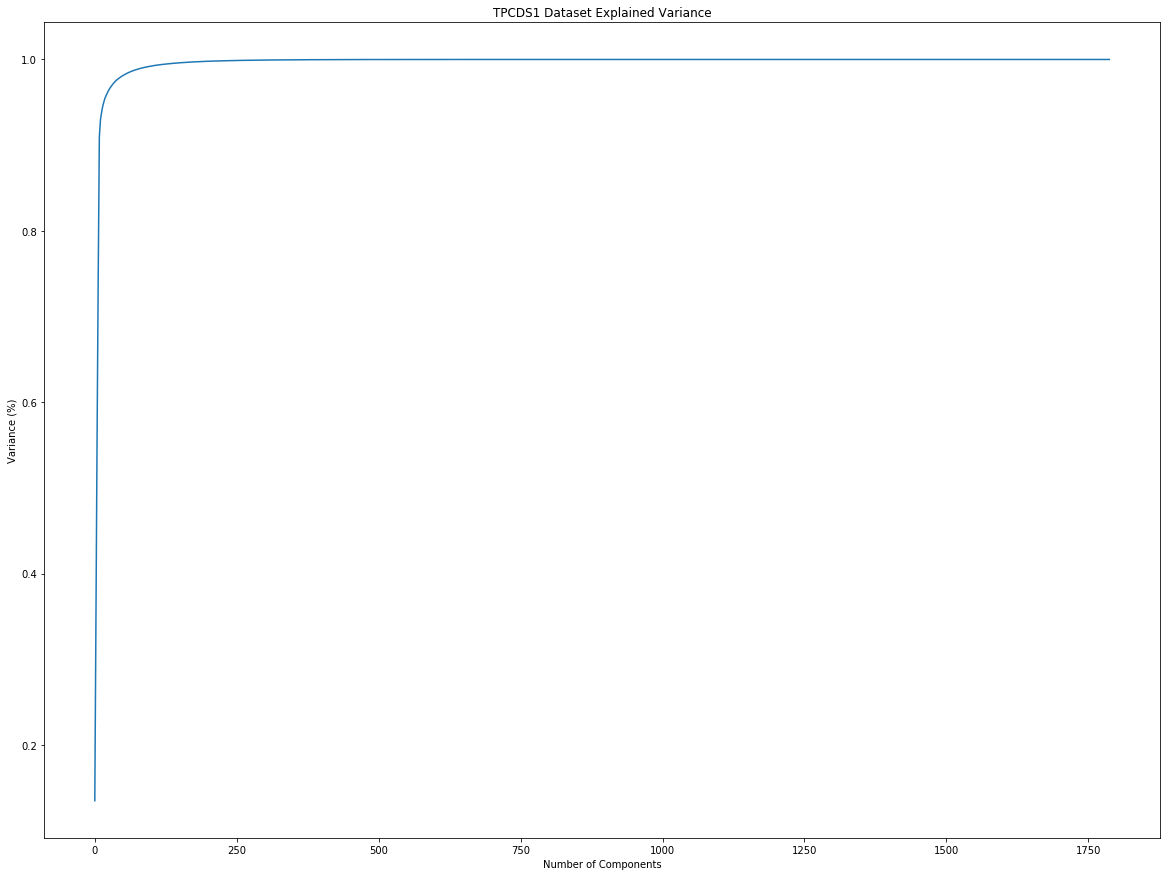

------------------------------
   Component_0  Component_1  Component_2  Component_3  Component_4  \
0    -3.006258    -5.147142     3.111295    -1.028456     0.484277   
1    -1.731205     4.850360    -0.935646    -0.012605     0.276055   
2    -5.975765    -1.534934    -1.421596    -1.050914     1.010543   
3     0.971477    -1.444033    -0.753581    -1.917816     0.007397   
4     1.713594    -1.651846    -2.563567    -0.042473     0.192221   

   Component_5  Component_6  Component_7  Component_8  Component_9  \
0     3.595671    -5.921892    -2.192013     2.402604    -1.656772   
1    -4.275183     3.447125    -3.887846     2.106015     2.252357   
2     1.234698     1.368995     1.334101     0.776521     0.819644   
3     2.094274     1.205274     1.983403     4.108823    -1.300620   
4     1.511193     4.757103    -5.045080    -0.764371    -0.428143   

       ...       Component_73  Component_74  Component_75  Component_76  \
0      ...           0.069961     -0.049812      0.2

In [19]:
class PrincipalComponentAnalysisClass:
    """
    This class handles logic related to PCA data transformations.
    https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
    """
    def __init__(self, X_df):
        """
        Cosntructor method.
        :param X_df: (Pandas) Dataframe consisting of input features, which will be subject to PCA.
        :return: None
        """
        self.__X_df = X_df
        
    def get_default_component_variances(self):
        """
        Fitting the PCA algorithm with our Data.
        :return: (Numpy array) Array of feature variances.
        """
        pca = PCA().fit(self.__X_df.values)
        return np.cumsum(pca.explained_variance_ratio_)
        
    def get_default_component_count(self, threshold=.99):
        """
        Retrieves the recommended number of component decomposition, above which very little variance 
        gain is achieved. This treshold will be set at a 0.999 variance threshold.
        :param threshold: (Float) Threshold value between 0 and 1. Stops immediately as soon the number
                                  of required components exceeds the threshold value.
        :return: (Integer) Returns the number of recommended components.
        """
        variance_ratios = self.get_default_component_variances()
        n = 0
        for val in variance_ratios:
            if val < threshold:
                n += 1
        return n
    
    def plot_variance_per_reduction(self):
        """
        This method subjects the feature matrix to a PCA decomposition. The number of components is plot
        vs the amount of retained variance.
        :return: None
        """
        variance_ratios = self.get_default_component_variances()
        
        #Plotting the Cumulative Summation of the Explained Variance
        plt.figure()
        plt.plot(variance_ratios)
        plt.xlabel('Number of Components')
        plt.ylabel('Variance (%)') #for each component
        plt.title(tpcds + ' Dataset Explained Variance')
        plt.show()
        
    def apply_PCA(self, n_components):
        """
        Applies Principle Component Analysis on the constructor passed data matrix, on a number of components.
        A new pandas data matrix is returned, with renamed 'Principal Component' headers.
        :param n_components: (Integer) Denotes number of component breakdown.
        :return: (Pandas) Dataframe consisting of new decomposed components.
        """
        pca = PCA(n_components=n_components)
        dataset = pca.fit_transform(self.__X_df.values)
        header_list = []
        for i in range(dataset.shape[1]):
            header_list.append('Component_' + str(i))
        return pd.DataFrame(data=dataset, columns=header_list)

print(X_df.head())
print(X_df.shape)

pcac = PrincipalComponentAnalysisClass(X_df=X_df)
pcac.plot_variance_per_reduction()
component_count = pcac.get_default_component_count()
X_df = pcac.apply_PCA(n_components=component_count)

print('-'*30)
print(X_df.head())
print(X_df.shape)

## Neural Network (Keras + Tensorflow backend)
### Designing the network

- The first step is to define your network.
- Neural networks are defined in Keras as a sequence of layers. The container for these layers is the **Sequential class**.
- The first step is to create an instance of the Sequential class. Then you can create your layers and add them in the order that they should be connected.
- This experiment assumes a classical Feed Forward Network.

### Relavent Links

Network structure pointers [https://www.heatonresearch.com/2017/06/01/hidden-layers.html]. Rough heuristics to start with:

* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.

--------------------------------------------------------------------------------------------

* https://machinelearningmastery.com/models-sequence-prediction-recurrent-neural-networks/
* https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
* https://machinelearningmastery.com/5-step-life-cycle-long-short-term-memory-models-keras/
* https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
* https://arxiv.org/pdf/1312.6026.pdf
* https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/
* https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/

In [20]:
# NeuralNet Class
class NeuralNet:
    """
    NeuralNet Class
    """

    def __init__(self, X, y, lag, loss_func, activation, optimizer='sgd', layers=1, dropout=.0,
                 y_labels=None, initializer='uniform'):
        """
        Initiating the class creates a net with the established parameters
        :param X             - (Numpy 2D Array) Training data used to train the model (Features).
        :param y             - (Numpy 2D Array) Test data used to test the model (Labels
        :param lag           - (Integer) Denotes lag step value
        :param loss_function - (String)  Denotes mode of measure fitting of model (Fitting function).
        :param activation    - (String)  Neuron activation function used to activate/trigger neurons.
        :param optimizer     - (String)  Denotes which function to us to optimize the model build (eg: Gradient Descent).
        :param layers        - (Integer) Denotes the number of Neuron layers to be included in the model build.
        :param dropout       - (Float)   Denotes amount of dropout for model. This parameter must be a value between 0 and 1.
        :param: y_labels     - (List)    List of target label names.
        :param: initializer  - (String)  String initializer which denotes starting weights.
        """
        self.__lag = lag
        self.__model = ke.models.Sequential()
        self.__y_labels = y_labels

        if dropout > 1 and dropout < 0:
            raise ValueError('Dropout parameter exceeded! Must be a value between 0 and 1.')

        for i in range(0, layers):
            self.__model.add(ke.layers.Dense(X.shape[1],
                                             kernel_initializer=initializer,
                                             activation=activation,
                                             input_shape=(X.shape[1],)))
            self.__model.add(ke.layers.Dropout(dropout))
        self.__model.add(ke.layers.Dense(X.shape[1],
                                         kernel_initializer=initializer,
                                         activation=activation,
                                         input_shape=(X.shape[1],)))
        self.__model.add(ke.layers.Dropout(dropout))

        self.__model.add(ke.layers.Dense(y.shape[1],
                                         kernel_initializer=initializer,
                                         activation='sigmoid'))
        self.__model.compile(loss=loss_func, optimizer=optimizer, metrics=['mse','mae'])
        print(self.__model.summary())

    def fit_model(self, X_train=None, X_test=None, y_train=None, y_test=None, epochs=50, batch_size=50, verbose=2,
                  shuffle=False, plot=False):
        """
        Fit data to model & validate. Trains a number of epochs.

        :param: X_train    - (Numpy 2D Array) Numpy matrix consisting of input training features
        :param: X_test     - (Numpy 2D Array) Numpy matrix consisting of input validation/testing features
        :param: y_train    - (Numpy 2D Array) Numpy matrix consisting of output training labels
        :param: y_test     - (Numpy 2D Array) Numpy matrix consisting of output validation/testing labels
        :param: epochs     - (Integer) Integer value denoting number of trained epochs
        :param: verbose    - (Integer) Integer value denoting net verbosity (Amount of information shown to user during NeuralNet training)
        :param: shuffle    - (Bool) Boolean value denoting whether or not to shuffle data. This parameter must always remain 'False' for time series datasets.
        :param: plot       - (Bool) Boolean value denoting whether this function should plot out it's evaluation

        :return: None
        """
        if X_test is not None and y_test is not None:
            history = self.__model.fit(x=X_train,
                                       y=y_train,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       validation_data=(X_test, y_test),
                                       verbose=verbose,
                                       shuffle=shuffle)
        else:
            history = self.__model.fit(x=X_train,
                                       y=y_train,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       verbose=verbose,
                                       shuffle=shuffle)

        if plot:
            plt.rcParams['figure.figsize'] = [20, 15]
            plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
            plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()

    def predict(self, X, batch_size):
        """
        Predicts label/s from input feature 'X'
        :param: X - Numpy matrix consisting of a single feature vector
        :param: batch_size - (Integer) Denotes prediction batch size
        :return: Numpy matrix of predicted label output
        """
        yhat = self.__model.predict(X, batch_size=batch_size)
        return yhat

#     def evaluate(self, y, yhat, plot=False):
#         """
#         Receives 2D matrix of input features and 2D matrix of output labels, and evaluates input data and target predictions.
#         :param: y    - Numpy array consisting of output label vectors (Test Set)
#         :param: yhat - Numpy array consisting of output label vectors (Prediction Set)
#         :param: plot     - (Bool) Boolean value denoting whether this function should plot out it's evaluation
#         :return: None
#         """
#         # RMSE Evaluation
#         if self.mode == 'regression':
#             rmse = math.sqrt(mean_squared_error(y, yhat))
#             if not plot:
#                 return rmse
#             print('Reported: ' + str(rmse) + ' rmse')

#         elif self.mode == 'classification':
#             column_names = []
#             for i in range(len(self.__y_labels)):
#                 column_names.append("column" + str(i))

#             y = BinClass.discretize_value(y, bin_value)
#             yhat = BinClass.discretize_value(yhat, bin_value)
#             y = y.flatten()
#             yhat = yhat.flatten()

#             # F1-Score Evaluation
#             print(y)
#             print(yhat)
#             accuracy = accuracy_score(y, yhat)
#             f1 = f1_score(y,
#                           yhat,
#                           average='macro')  # Calculate metrics globally by counting the total true positives, false negatives and false positives.
#             print('Accuracy [' + str(accuracy) + ']')
#             print('FScore [' + str(f1) + ']')

#             if not plot:
#                 return accuracy, f1

#         if plot:
#             plt.rcParams['figure.figsize'] = [20, 15]
#             plt.plot(y, label='actual')
#             plt.plot(yhat, label='predicted')
#             plt.legend(['actual', 'predicted'], loc='upper left')
#             plt.title('Actual vs Predicted')
#             plt.show()

    @staticmethod
    def write_results_to_disk(path, iteration, lag, test_split, batch, dropout, epoch, layer, activation, initializer,
                              rmse, accuracy, f_score, time_train):
        """
        Static method which is used for test harness utilities. This method attempts a grid search across many
        trained NeuralNet models, each denoted with different configurations.

        Attempted configurations:
        * Varied data test split
        * Varied batch sizes
        * Varied epoch counts

        Each configuration is denoted with a score, and used to identify the most optimal configuration.

        :param: path       - (String) String denoting result csv output.
        :param: iteration  - (Integer) Integer denoting test iteration (Unique per test configuration).
        :param: lag        - (Integer) Denotes lag time shift
        :param: test_split - (Float) Float denoting data sample sizes.
        :param: epoch      - (Integer) Integer denoting number of NeuralNet training iterations.
        :param: layer      - (Integer) Integer denoting number of NeuralNet layers.
        :param: activation - (String) String denoting activation for NeuralNet layers.
        :param: initializer- (String) String denoting NeuralNet initializing weights.
        :param: dropout    - (Float) Float denoting model dropout layer.
        :param: rmse       - (Float) Float denoting experiment configuration RSME score.
        :param: accuracy   - (Float) Float denoting experiment accuracy score.
        :param: fscore     - (Float) Float denoting experiment fscore score.
        :param: time_train - (Integer) Integer denoting number of seconds taken by NeuralNet training iteration.

        :return: None
        """
        file_exists = os.path.isfile(path)
        with open(path, 'a+') as csvfile:
            headers = ['iteration', 'test_split', 'batch', 'epoch', 'layer', 'dropout', 'activation', 'initializer',
                       'rmse', 'accuracy', 'f_score', 'time_train', 'lag']
            writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=headers)
            if not file_exists:
                writer.writeheader()  # file doesn't exist yet, write a header
            writer.writerow({'iteration': iteration,
                             'test_split': test_split,
                             'batch': batch,
                             'epoch': epoch,
                             'layer': layer,
                             'dropout': dropout,
                             'activation': activation,
                             'initializer': initializer,
                             'rmse': rmse,
                             'accuracy': accuracy,
                             'f_score': f_score,
                             'time_train': time_train,
                             'lag': lag})

    @staticmethod
    def lag_multiple(X, lag):
        """
        Divides the total number of rows by the lag value, until a perfect multiple amount is retrieved.
        :param X: (Numpy) 2D array consisting of input.
        :param lag: (Integer) Denotes time shift value.
        :return: (Numpy) 2D array consisting of a perfect lag multiple rows.
        """
        n_rows = X.shape[0]
        multiple = int(n_rows/lag)
        max_new_rows = multiple * lag
        return X[0:max_new_rows,:]

## Neural Net (Feed Foward) Training (Week Prior: Day 1 - 7) (CPU)

A neural net model is trained on a week worth of data. Once the model is fit, it will then be used to establish predictions for upcoming days.

* https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
* https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
* https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
* https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks


Reshaping Training Frames
X_train shape [(9909, 83)] Type - <class 'numpy.ndarray'>
X_validate shape [(9910, 83)] Type - <class 'numpy.ndarray'>
y_train shape [(9909, 13)] Type - <class 'numpy.ndarray'>
y_validate shape [(9910, 13)] Type - <class 'numpy.ndarray'>


INFO:plaidml:Opening device "opencl_amd_tonga.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 83)                6972      
_________________________________________________________________
dropout_1 (Dropout)          (None, 83)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 83)                6972      
_________________________________________________________________
dropout_2 (Dropout)          (None, 83)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 83)                6972      
_________________________________________________________________
dropout_3 (Dropout)          (None, 83)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 13)                1092      
Total para

Epoch 40/600
 - 5s - loss: 0.0506 - mean_squared_error: 0.0506 - mean_absolute_error: 0.1802 - val_loss: 0.0510 - val_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.1814
Epoch 41/600
 - 5s - loss: 0.0506 - mean_squared_error: 0.0506 - mean_absolute_error: 0.1801 - val_loss: 0.0510 - val_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.1814
Epoch 42/600
 - 5s - loss: 0.0506 - mean_squared_error: 0.0506 - mean_absolute_error: 0.1800 - val_loss: 0.0510 - val_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.1814
Epoch 43/600
 - 5s - loss: 0.0506 - mean_squared_error: 0.0506 - mean_absolute_error: 0.1799 - val_loss: 0.0510 - val_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.1813
Epoch 44/600
 - 5s - loss: 0.0505 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1799 - val_loss: 0.0510 - val_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.1813
Epoch 45/600
 - 5s - loss: 0.0505 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1798 - val_loss: 

Epoch 86/600
 - 5s - loss: 0.0487 - mean_squared_error: 0.0487 - mean_absolute_error: 0.1745 - val_loss: 0.0519 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.1814
Epoch 87/600
 - 5s - loss: 0.0487 - mean_squared_error: 0.0487 - mean_absolute_error: 0.1743 - val_loss: 0.0520 - val_mean_squared_error: 0.0520 - val_mean_absolute_error: 0.1815
Epoch 88/600
 - 5s - loss: 0.0486 - mean_squared_error: 0.0486 - mean_absolute_error: 0.1742 - val_loss: 0.0520 - val_mean_squared_error: 0.0520 - val_mean_absolute_error: 0.1816
Epoch 89/600
 - 5s - loss: 0.0486 - mean_squared_error: 0.0486 - mean_absolute_error: 0.1740 - val_loss: 0.0521 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1816
Epoch 90/600
 - 5s - loss: 0.0485 - mean_squared_error: 0.0485 - mean_absolute_error: 0.1739 - val_loss: 0.0521 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1817
Epoch 91/600
 - 5s - loss: 0.0485 - mean_squared_error: 0.0485 - mean_absolute_error: 0.1737 - val_loss: 

Epoch 132/600
 - 5s - loss: 0.0457 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1666 - val_loss: 0.0554 - val_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.1846
Epoch 133/600
 - 5s - loss: 0.0456 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1664 - val_loss: 0.0555 - val_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.1846
Epoch 134/600
 - 5s - loss: 0.0455 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1662 - val_loss: 0.0556 - val_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.1847
Epoch 135/600
 - 5s - loss: 0.0455 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1660 - val_loss: 0.0556 - val_mean_squared_error: 0.0556 - val_mean_absolute_error: 0.1848
Epoch 136/600
 - 6s - loss: 0.0454 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1658 - val_loss: 0.0557 - val_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.1848
Epoch 137/600
 - 5s - loss: 0.0453 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1657 - val_

Epoch 178/600
 - 5s - loss: 0.0424 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1582 - val_loss: 0.0596 - val_mean_squared_error: 0.0596 - val_mean_absolute_error: 0.1880
Epoch 179/600
 - 5s - loss: 0.0423 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1580 - val_loss: 0.0597 - val_mean_squared_error: 0.0597 - val_mean_absolute_error: 0.1881
Epoch 180/600
 - 5s - loss: 0.0423 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1578 - val_loss: 0.0598 - val_mean_squared_error: 0.0598 - val_mean_absolute_error: 0.1882
Epoch 181/600
 - 5s - loss: 0.0422 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1577 - val_loss: 0.0599 - val_mean_squared_error: 0.0599 - val_mean_absolute_error: 0.1882
Epoch 182/600
 - 5s - loss: 0.0421 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1575 - val_loss: 0.0600 - val_mean_squared_error: 0.0600 - val_mean_absolute_error: 0.1883
Epoch 183/600
 - 5s - loss: 0.0421 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1573 - val_

Epoch 224/600
 - 5s - loss: 0.0393 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1500 - val_loss: 0.0638 - val_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.1911
Epoch 225/600
 - 5s - loss: 0.0392 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1499 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - val_mean_absolute_error: 0.1911
Epoch 226/600
 - 5s - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1497 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - val_mean_absolute_error: 0.1912
Epoch 227/600
 - 5s - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1495 - val_loss: 0.0641 - val_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.1912
Epoch 228/600
 - 5s - loss: 0.0390 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1494 - val_loss: 0.0641 - val_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.1913
Epoch 229/600
 - 5s - loss: 0.0390 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1492 - val_

Epoch 270/600
 - 5s - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1427 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - val_mean_absolute_error: 0.1938
Epoch 271/600
 - 5s - loss: 0.0364 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1426 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - val_mean_absolute_error: 0.1938
Epoch 272/600
 - 5s - loss: 0.0364 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1424 - val_loss: 0.0679 - val_mean_squared_error: 0.0679 - val_mean_absolute_error: 0.1939
Epoch 273/600
 - 5s - loss: 0.0363 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1423 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - val_mean_absolute_error: 0.1940
Epoch 274/600
 - 5s - loss: 0.0363 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1421 - val_loss: 0.0681 - val_mean_squared_error: 0.0681 - val_mean_absolute_error: 0.1940
Epoch 275/600
 - 5s - loss: 0.0362 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1420 - val_

Epoch 316/600
 - 5s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.1366 - val_loss: 0.0714 - val_mean_squared_error: 0.0714 - val_mean_absolute_error: 0.1966
Epoch 317/600
 - 5s - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.1365 - val_loss: 0.0715 - val_mean_squared_error: 0.0715 - val_mean_absolute_error: 0.1966
Epoch 318/600
 - 5s - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.1364 - val_loss: 0.0716 - val_mean_squared_error: 0.0716 - val_mean_absolute_error: 0.1967
Epoch 319/600
 - 5s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.1362 - val_loss: 0.0716 - val_mean_squared_error: 0.0716 - val_mean_absolute_error: 0.1967
Epoch 320/600
 - 5s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.1361 - val_loss: 0.0717 - val_mean_squared_error: 0.0717 - val_mean_absolute_error: 0.1968
Epoch 321/600
 - 5s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.1360 - val_

Epoch 362/600
 - 5s - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1315 - val_loss: 0.0749 - val_mean_squared_error: 0.0749 - val_mean_absolute_error: 0.1993
Epoch 363/600
 - 5s - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1314 - val_loss: 0.0750 - val_mean_squared_error: 0.0750 - val_mean_absolute_error: 0.1994
Epoch 364/600
 - 5s - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1313 - val_loss: 0.0750 - val_mean_squared_error: 0.0750 - val_mean_absolute_error: 0.1995
Epoch 365/600
 - 5s - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1312 - val_loss: 0.0751 - val_mean_squared_error: 0.0751 - val_mean_absolute_error: 0.1995
Epoch 366/600
 - 5s - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1311 - val_loss: 0.0752 - val_mean_squared_error: 0.0752 - val_mean_absolute_error: 0.1996
Epoch 367/600
 - 5s - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1310 - val_

Epoch 408/600
 - 5s - loss: 0.0306 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1272 - val_loss: 0.0783 - val_mean_squared_error: 0.0783 - val_mean_absolute_error: 0.2023
Epoch 409/600
 - 5s - loss: 0.0306 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1271 - val_loss: 0.0784 - val_mean_squared_error: 0.0784 - val_mean_absolute_error: 0.2023
Epoch 410/600
 - 5s - loss: 0.0306 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1270 - val_loss: 0.0784 - val_mean_squared_error: 0.0784 - val_mean_absolute_error: 0.2024
Epoch 411/600
 - 5s - loss: 0.0305 - mean_squared_error: 0.0305 - mean_absolute_error: 0.1269 - val_loss: 0.0785 - val_mean_squared_error: 0.0785 - val_mean_absolute_error: 0.2025
Epoch 412/600
 - 5s - loss: 0.0305 - mean_squared_error: 0.0305 - mean_absolute_error: 0.1268 - val_loss: 0.0786 - val_mean_squared_error: 0.0786 - val_mean_absolute_error: 0.2025
Epoch 413/600
 - 5s - loss: 0.0305 - mean_squared_error: 0.0305 - mean_absolute_error: 0.1268 - val_

Epoch 454/600
 - 5s - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1236 - val_loss: 0.0813 - val_mean_squared_error: 0.0813 - val_mean_absolute_error: 0.2048
Epoch 455/600
 - 5s - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1235 - val_loss: 0.0814 - val_mean_squared_error: 0.0814 - val_mean_absolute_error: 0.2049
Epoch 456/600
 - 5s - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1234 - val_loss: 0.0814 - val_mean_squared_error: 0.0814 - val_mean_absolute_error: 0.2049
Epoch 457/600
 - 5s - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1234 - val_loss: 0.0815 - val_mean_squared_error: 0.0815 - val_mean_absolute_error: 0.2050
Epoch 458/600
 - 5s - loss: 0.0291 - mean_squared_error: 0.0291 - mean_absolute_error: 0.1233 - val_loss: 0.0816 - val_mean_squared_error: 0.0816 - val_mean_absolute_error: 0.2051
Epoch 459/600
 - 5s - loss: 0.0291 - mean_squared_error: 0.0291 - mean_absolute_error: 0.1232 - val_

Epoch 500/600
 - 5s - loss: 0.0281 - mean_squared_error: 0.0281 - mean_absolute_error: 0.1205 - val_loss: 0.0840 - val_mean_squared_error: 0.0840 - val_mean_absolute_error: 0.2071
Epoch 501/600
 - 5s - loss: 0.0280 - mean_squared_error: 0.0280 - mean_absolute_error: 0.1205 - val_loss: 0.0841 - val_mean_squared_error: 0.0841 - val_mean_absolute_error: 0.2072
Epoch 502/600
 - 5s - loss: 0.0280 - mean_squared_error: 0.0280 - mean_absolute_error: 0.1204 - val_loss: 0.0841 - val_mean_squared_error: 0.0841 - val_mean_absolute_error: 0.2072
Epoch 503/600
 - 5s - loss: 0.0280 - mean_squared_error: 0.0280 - mean_absolute_error: 0.1203 - val_loss: 0.0842 - val_mean_squared_error: 0.0842 - val_mean_absolute_error: 0.2073
Epoch 504/600
 - 5s - loss: 0.0280 - mean_squared_error: 0.0280 - mean_absolute_error: 0.1203 - val_loss: 0.0842 - val_mean_squared_error: 0.0842 - val_mean_absolute_error: 0.2073
Epoch 505/600
 - 5s - loss: 0.0280 - mean_squared_error: 0.0280 - mean_absolute_error: 0.1202 - val_

Epoch 546/600
 - 5s - loss: 0.0271 - mean_squared_error: 0.0271 - mean_absolute_error: 0.1179 - val_loss: 0.0866 - val_mean_squared_error: 0.0866 - val_mean_absolute_error: 0.2094
Epoch 547/600
 - 5s - loss: 0.0271 - mean_squared_error: 0.0271 - mean_absolute_error: 0.1179 - val_loss: 0.0866 - val_mean_squared_error: 0.0866 - val_mean_absolute_error: 0.2094
Epoch 548/600
 - 5s - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1178 - val_loss: 0.0867 - val_mean_squared_error: 0.0867 - val_mean_absolute_error: 0.2095
Epoch 549/600
 - 5s - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1178 - val_loss: 0.0867 - val_mean_squared_error: 0.0867 - val_mean_absolute_error: 0.2095
Epoch 550/600
 - 5s - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1177 - val_loss: 0.0868 - val_mean_squared_error: 0.0868 - val_mean_absolute_error: 0.2096
Epoch 551/600
 - 5s - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1177 - val_

Epoch 592/600
 - 5s - loss: 0.0263 - mean_squared_error: 0.0263 - mean_absolute_error: 0.1157 - val_loss: 0.0889 - val_mean_squared_error: 0.0889 - val_mean_absolute_error: 0.2115
Epoch 593/600
 - 5s - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_error: 0.1157 - val_loss: 0.0890 - val_mean_squared_error: 0.0890 - val_mean_absolute_error: 0.2115
Epoch 594/600
 - 5s - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_error: 0.1156 - val_loss: 0.0890 - val_mean_squared_error: 0.0890 - val_mean_absolute_error: 0.2116
Epoch 595/600
 - 5s - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_error: 0.1156 - val_loss: 0.0891 - val_mean_squared_error: 0.0891 - val_mean_absolute_error: 0.2116
Epoch 596/600
 - 5s - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_error: 0.1155 - val_loss: 0.0891 - val_mean_squared_error: 0.0891 - val_mean_absolute_error: 0.2117
Epoch 597/600
 - 5s - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_error: 0.1155 - val_

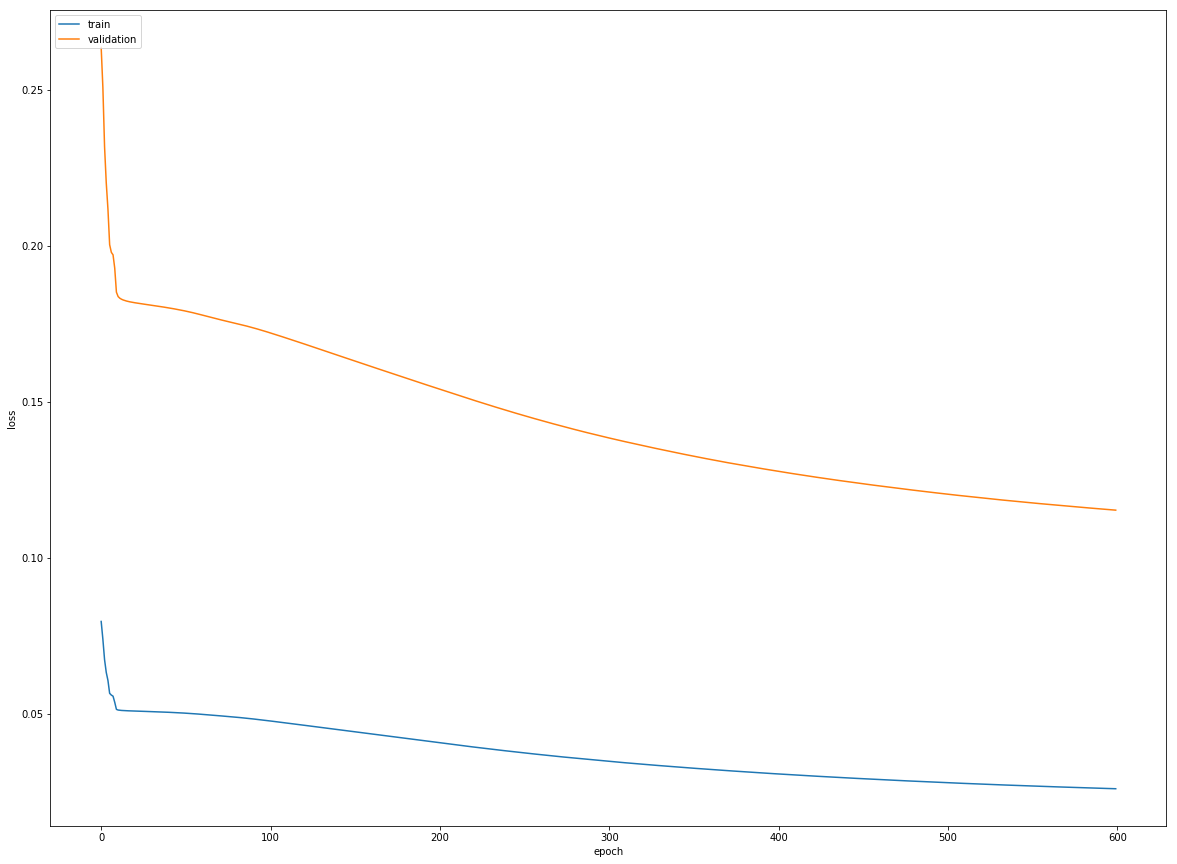

Wall time: 49min 11s


In [21]:
%%time
y_labels2 = []
for label in y_df.columns:
    if 'var1' in label:
        y_labels2.append(label)
y_df2 = y_df[y_labels2]

preprocessing.minmax_scale

X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df2, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = NeuralNet(X=X_train,
                  y=y_train,
                  lag=lag,
                  loss_func='mean_squared_error',
                  activation=activation,
                  optimizer='adam',
                  layers=layer,
                  dropout=dropout,
                  y_labels=y_label,
                  initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

## Neural Net (Feed Foward) Validation: Day 8 - 14 (CPU)

Evaluating model fit to day 1 forecasts. 

Day 1
Feature vectors: (1415, 83)
Label vectors: (1415, 13)
Label: 0
Accuracy: 0.5173144876325089
F1Score: 0.3681776133209991
--------------------------
Label: 1
Accuracy: 0.5102473498233215
F1Score: 0.38180196253345233
--------------------------
Label: 2
Accuracy: 0.5328621908127208
F1Score: 0.40504050405040504
--------------------------
Label: 3
Accuracy: 0.5300353356890459
F1Score: 0.3720491029272899
--------------------------
Label: 4
Accuracy: 0.5144876325088339
F1Score: 0.3475783475783476
--------------------------
Label: 5
Accuracy: 0.5074204946996467
F1Score: 0.3278688524590164
--------------------------
Label: 6
Accuracy: 0.5180212014134276
F1Score: 0.35047619047619055
--------------------------
Label: 7
Accuracy: 0.5307420494699646
F1Score: 0.35282651072124754
--------------------------
Label: 8
Accuracy: 0.8346289752650177
F1Score: 0.8151658767772512
--------------------------
Label: 9
Accuracy: 0.9137809187279152
F1Score: 0.9067278287461774
--------------------------
Label:

Label: 0
Accuracy: 0.503886925795053
F1Score: 0.4558139534883721
--------------------------
Label: 1
Accuracy: 0.5173144876325089
F1Score: 0.4406224406224406
--------------------------
Label: 2
Accuracy: 0.511660777385159
F1Score: 0.4588880187940485
--------------------------
Label: 3
Accuracy: 0.5010600706713781
F1Score: 0.4378980891719745
--------------------------
Label: 4
Accuracy: 0.5024734982332155
F1Score: 0.4421553090332805
--------------------------
Label: 5
Accuracy: 0.49823321554770317
F1Score: 0.4237012987012987
--------------------------
Label: 6
Accuracy: 0.5081272084805654
F1Score: 0.4131534569983137
--------------------------
Label: 7
Accuracy: 0.5095406360424029
F1Score: 0.5646173149309912
--------------------------
Label: 8
Accuracy: 0.8862190812720848
F1Score: 0.8685714285714287
--------------------------
Label: 9
Accuracy: 0.9335689045936396
F1Score: 0.9283536585365854
--------------------------
Label: 10
Accuracy: 0.9611307420494699
F1Score: 0.956726986624705
-----

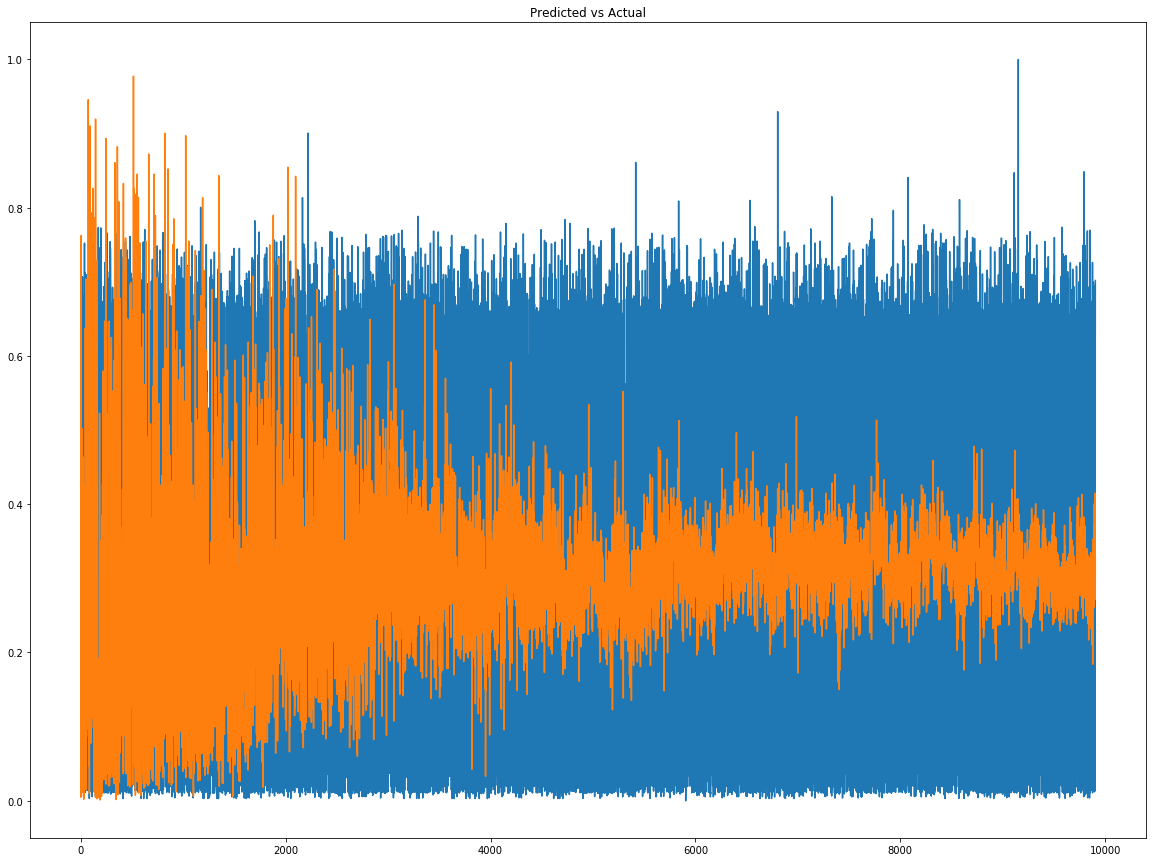

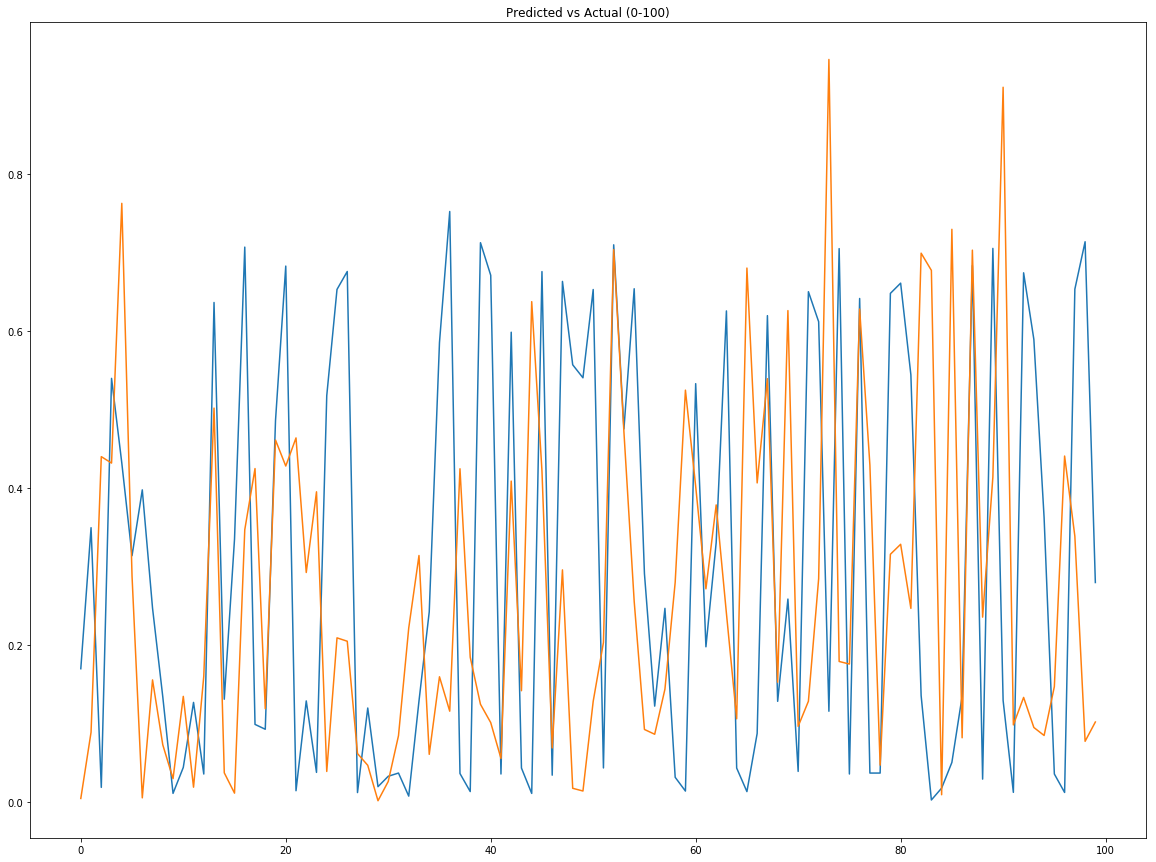

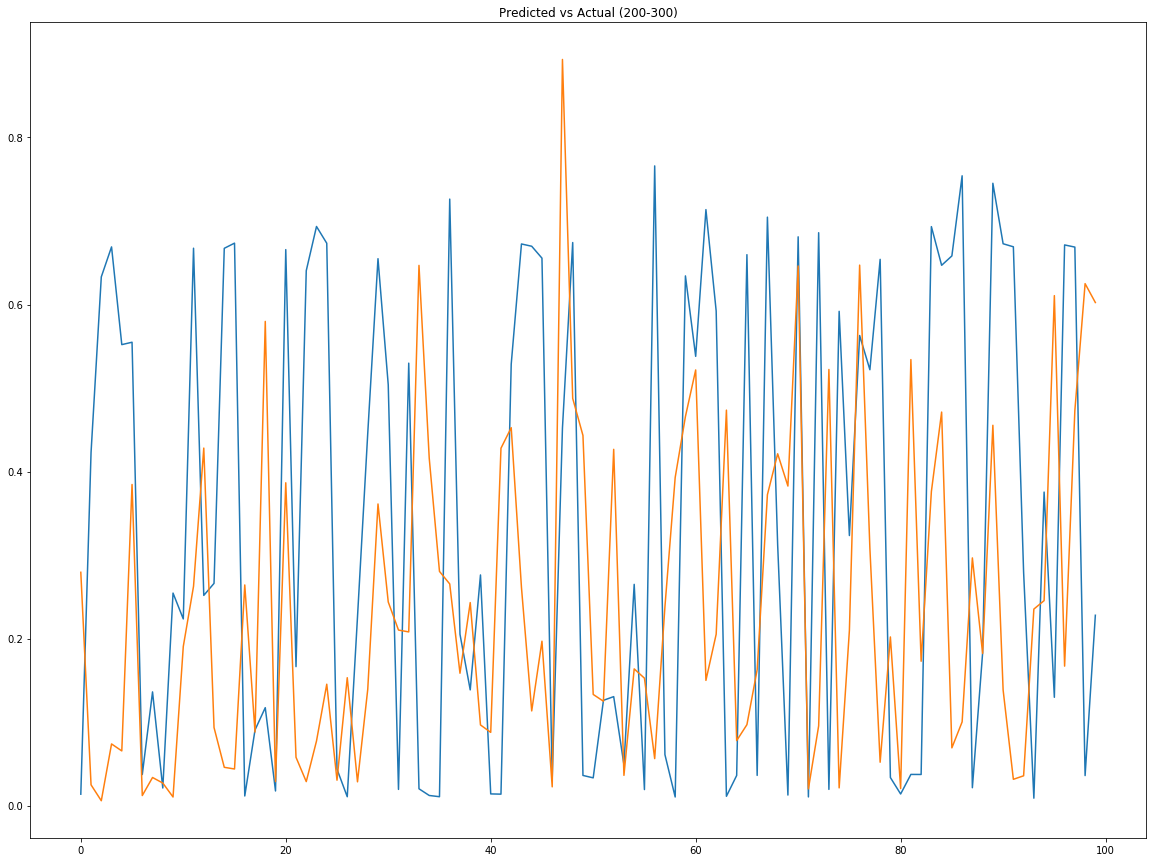

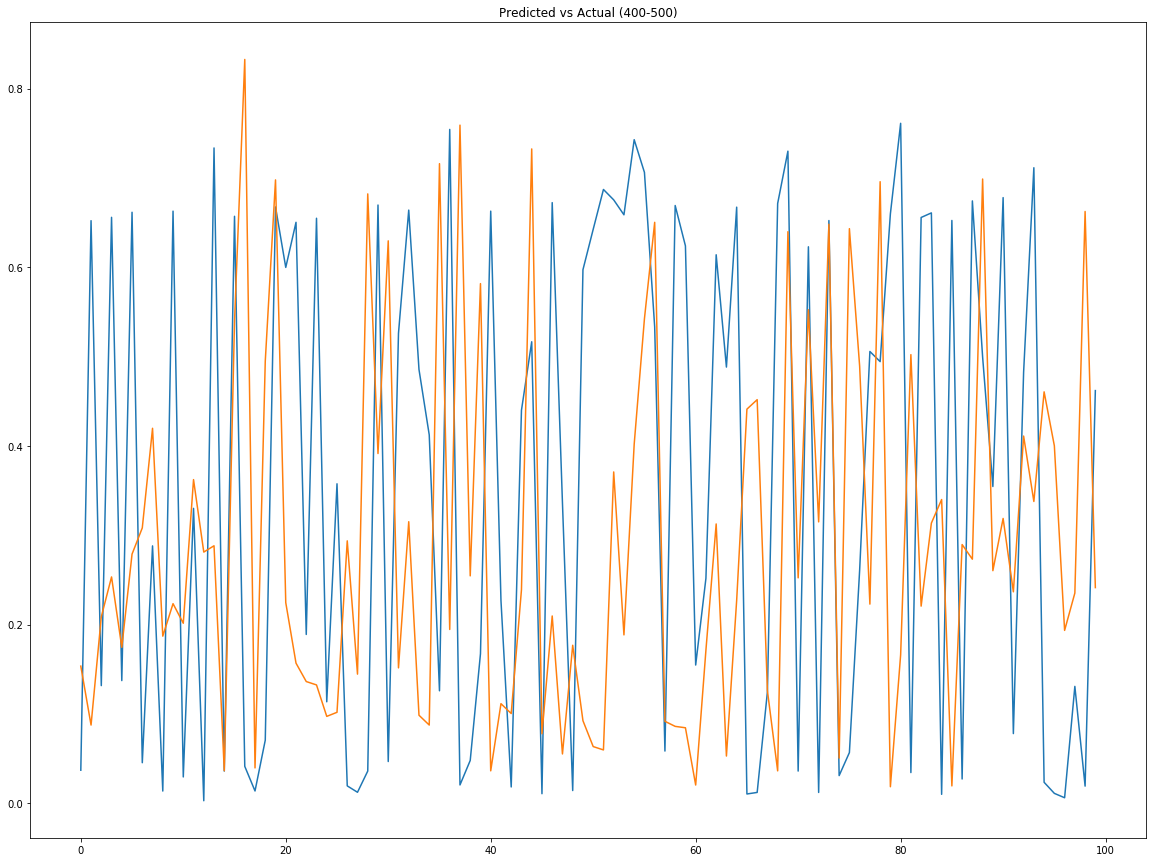

Wall time: 4min 15s


In [22]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
#NEW
y_actual, y_predicted = [],[]
#NEW
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = X_validate_temp[j,:]
        X = X.reshape(1,-1)
        #X = X.reshape((int(X.shape[0] / lag), lag, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        #NEW
        y_actual.append(y[0])
        y_predicted.append(yhat[0])
        #NEW
        
        for z in range(yhat.shape[0]):
            y[z] = BinClass.discretize_value(y[z], cpu_avg)
            yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(len(y_labels2)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

#NEW
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual, label='y_actual')
plt.plot(y_predicted, label='y_predicted')
plt.title('Predicted vs Actual')
plt.show()

plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[0:100], label='y_actual')
plt.plot(y_predicted[0:100], label='y_predicted')
plt.title('Predicted vs Actual (0-100)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[200:300], label='y_actual')
plt.plot(y_predicted[200:300], label='y_predicted')
plt.title('Predicted vs Actual (200-300)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[400:500], label='y_actual')
plt.plot(y_predicted[400:500], label='y_predicted')
plt.title('Predicted vs Actual (400-500)')
plt.show()
#NEW

## Scoring per day (CPU)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

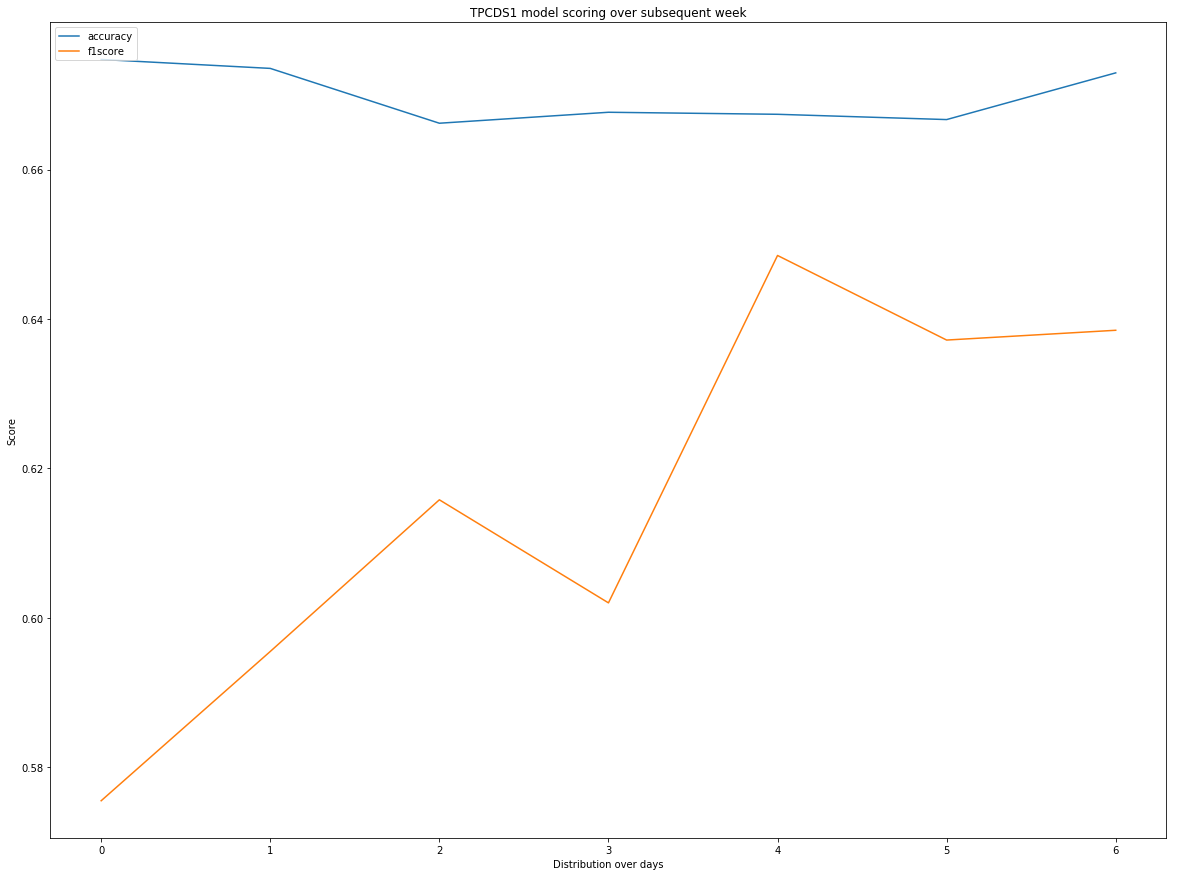

In [23]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

## Neural Net (Feed Foward) Training (Week Prior: Day 1 - 7) (IO)

A neural net model is trained on a week worth of data. Once the model is fit, it will then be used to establish predictions for upcoming days.

* https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
* https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
* https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
* https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks


Reshaping Training Frames
X_train shape [(9909, 83)] Type - <class 'numpy.ndarray'>
X_validate shape [(9910, 83)] Type - <class 'numpy.ndarray'>
y_train shape [(9909, 13)] Type - <class 'numpy.ndarray'>
y_validate shape [(9910, 13)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 83)                6972      
_________________________________________________________________
dropout_4 (Dropout)          (None, 83)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 83)                6972      
_________________________________________________________________
dropout_5 (Dropout)          (None, 83)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 83)                6972      
_________

 - 5s - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1086 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1087
Epoch 39/600
 - 5s - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1085 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1086
Epoch 40/600
 - 5s - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1083 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1085
Epoch 41/600
 - 5s - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1082 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1085
Epoch 42/600
 - 5s - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1081 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1084
Epoch 43/600
 - 5s - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1079 - val_loss: 0.0265 - val_

Epoch 84/600
 - 5s - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1028 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1052
Epoch 85/600
 - 5s - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1027 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1052
Epoch 86/600
 - 5s - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1027 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1052
Epoch 87/600
 - 5s - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1026 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1053
Epoch 88/600
 - 6s - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1026 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1053
Epoch 89/600
 - 5s - loss: 0.0250 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1025 - val_loss: 

Epoch 130/600
 - 5s - loss: 0.0239 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1009 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1081
Epoch 131/600
 - 5s - loss: 0.0239 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1009 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1081
Epoch 132/600
 - 5s - loss: 0.0238 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1008 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1082
Epoch 133/600
 - 5s - loss: 0.0238 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1008 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1083
Epoch 134/600
 - 5s - loss: 0.0238 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1008 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1084
Epoch 135/600
 - 5s - loss: 0.0237 - mean_squared_error: 0.0237 - mean_absolute_error: 0.1007 - val_

Epoch 176/600
 - 5s - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.0990 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1123
Epoch 177/600
 - 5s - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.0989 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1124
Epoch 178/600
 - 5s - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.0989 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1125
Epoch 179/600
 - 5s - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.0989 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1126
Epoch 180/600
 - 5s - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.0988 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1127
Epoch 181/600
 - 5s - loss: 0.0223 - mean_squared_error: 0.0223 - mean_absolute_error: 0.0988 - val_

Epoch 222/600
 - 5s - loss: 0.0211 - mean_squared_error: 0.0211 - mean_absolute_error: 0.0972 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1169
Epoch 223/600
 - 5s - loss: 0.0211 - mean_squared_error: 0.0211 - mean_absolute_error: 0.0972 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1170
Epoch 224/600
 - 5s - loss: 0.0211 - mean_squared_error: 0.0211 - mean_absolute_error: 0.0971 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1171
Epoch 225/600
 - 5s - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.0971 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1172
Epoch 226/600
 - 5s - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.0970 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1173
Epoch 227/600
 - 5s - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.0970 - val_

Epoch 268/600
 - 5s - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error: 0.0956 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1211
Epoch 269/600
 - 5s - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error: 0.0955 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1212
Epoch 270/600
 - 5s - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error: 0.0955 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1213
Epoch 271/600
 - 5s - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error: 0.0955 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1214
Epoch 272/600
 - 5s - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.0954 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1215
Epoch 273/600
 - 5s - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.0954 - val_

Epoch 314/600
 - 5s - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.0941 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1249
Epoch 315/600
 - 6s - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.0941 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1250
Epoch 316/600
 - 5s - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.0941 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1251
Epoch 317/600
 - 6s - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.0940 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1251
Epoch 318/600
 - 6s - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.0940 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1252
Epoch 319/600
 - 6s - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.0940 - val_

Epoch 360/600
 - 5s - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.0929 - val_loss: 0.0356 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.1282
Epoch 361/600
 - 5s - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.0928 - val_loss: 0.0357 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1283
Epoch 362/600
 - 5s - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.0928 - val_loss: 0.0357 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1284
Epoch 363/600
 - 5s - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.0928 - val_loss: 0.0357 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1284
Epoch 364/600
 - 5s - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.0927 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1285
Epoch 365/600
 - 5s - loss: 0.0181 - mean_squared_error: 0.0181 - mean_absolute_error: 0.0927 - val_

Epoch 406/600
 - 5s - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0917 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1310
Epoch 407/600
 - 6s - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0917 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1311
Epoch 408/600
 - 5s - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0917 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1312
Epoch 409/600
 - 5s - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0917 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1312
Epoch 410/600
 - 5s - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.0917 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1313
Epoch 411/600
 - 5s - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.0916 - val_

Epoch 452/600
 - 5s - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.0908 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1334
Epoch 453/600
 - 4s - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.0908 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1335
Epoch 454/600
 - 4s - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.0908 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1336
Epoch 455/600
 - 5s - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.0907 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1336
Epoch 456/600
 - 5s - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.0907 - val_loss: 0.0381 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1337
Epoch 457/600
 - 5s - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.0907 - val_

Epoch 498/600
 - 5s - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0900 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1355
Epoch 499/600
 - 5s - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0899 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1355
Epoch 500/600
 - 6s - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0899 - val_loss: 0.0390 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1356
Epoch 501/600
 - 5s - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0899 - val_loss: 0.0390 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1357
Epoch 502/600
 - 5s - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0899 - val_loss: 0.0390 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1356
Epoch 503/600
 - 5s - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0899 - val_

Epoch 544/600
 - 6s - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0892 - val_loss: 0.0397 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1372
Epoch 545/600
 - 6s - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0892 - val_loss: 0.0398 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1373
Epoch 546/600
 - 5s - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0892 - val_loss: 0.0398 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1373
Epoch 547/600
 - 5s - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0892 - val_loss: 0.0398 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1374
Epoch 548/600
 - 6s - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0891 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1374
Epoch 549/600
 - 5s - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0891 - val_

Epoch 590/600
 - 4s - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0886 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1387
Epoch 591/600
 - 4s - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0886 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1388
Epoch 592/600
 - 5s - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0886 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1388
Epoch 593/600
 - 5s - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0886 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1389
Epoch 594/600
 - 5s - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0885 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1389
Epoch 595/600
 - 5s - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0885 - val_

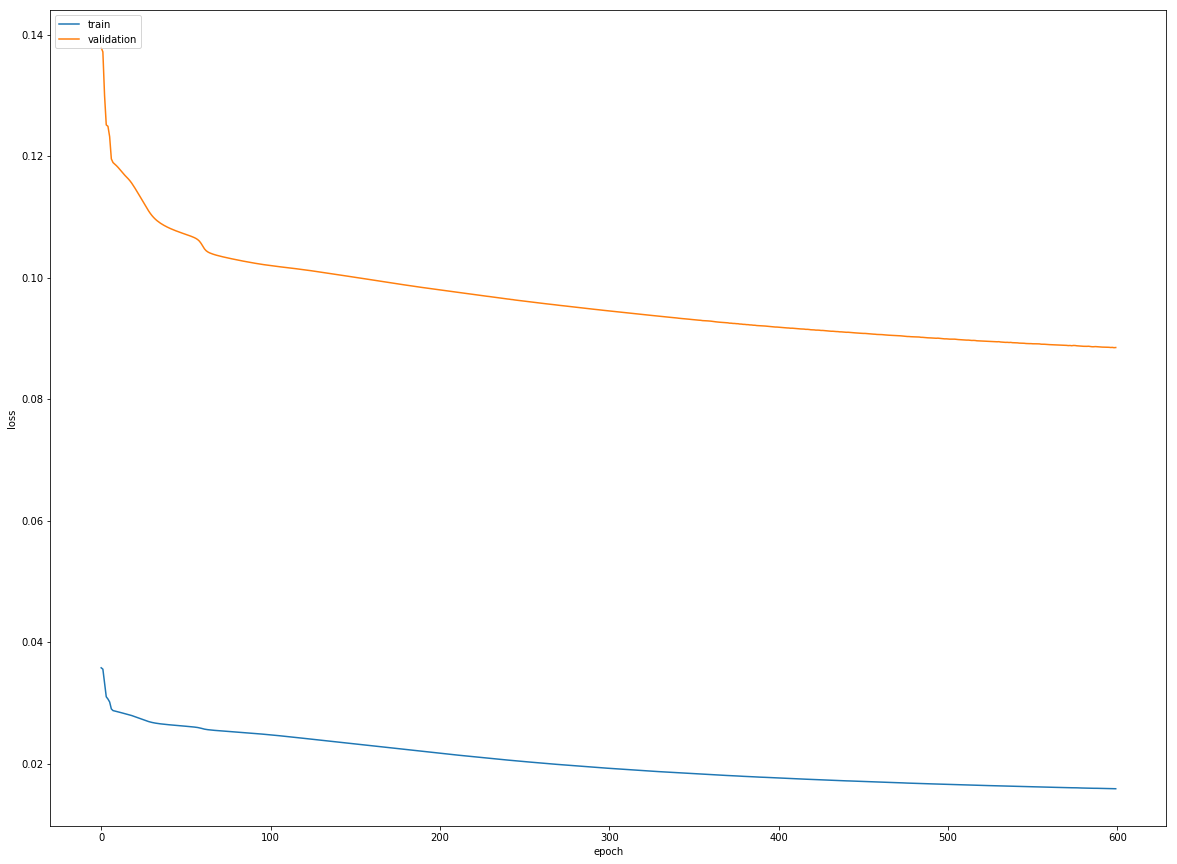

Wall time: 50min 46s


In [24]:
%%time
y_labels2 = []
for label in y_df.columns:
    if 'var2' in label:
        y_labels2.append(label)
y_df2 = y_df[y_labels2]
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df2, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = NeuralNet(X=X_train,
                  y=y_train,
                  lag=lag,
                  loss_func='mean_squared_error',
                  activation=activation,
                  optimizer='adam',
                  layers=layer,
                  dropout=dropout,
                  y_labels=y_label,
                  initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

## Neural Net (Feed Foward) Validation: Day 8 - 14 (IO)

Evaluating model fit to day 1 forecasts. 

Day 1
Feature vectors: (1415, 83)
Label vectors: (1415, 13)
Label: 0
Accuracy: 0.5173144876325089
F1Score: 0.4750192159877017
--------------------------
Label: 1
Accuracy: 0.508833922261484
F1Score: 0.4730856709628506
--------------------------
Label: 2
Accuracy: 0.49187279151943464
F1Score: 0.4845878136200717
--------------------------
Label: 3
Accuracy: 0.5300353356890459
F1Score: 0.4181977252843394
--------------------------
Label: 4
Accuracy: 0.5229681978798587
F1Score: 0.45783132530120474
--------------------------
Label: 5
Accuracy: 0.49540636042402825
F1Score: 0.43601895734597157
--------------------------
Label: 6
Accuracy: 0.4925795053003534
F1Score: 0.42190016103059585
--------------------------
Label: 7
Accuracy: 0.5081272084805654
F1Score: 0.44936708860759494
--------------------------
Label: 8
Accuracy: 0.5745583038869257
F1Score: 0.4517304189435337
--------------------------
Label: 9
Accuracy: 0.7710247349823321
F1Score: 0.76
--------------------------
Label: 10
Accuracy:

Label: 0
Accuracy: 0.4777385159010601
F1Score: 0.48716169326856346
--------------------------
Label: 1
Accuracy: 0.4657243816254417
F1Score: 0.4408284023668639
--------------------------
Label: 2
Accuracy: 0.5060070671378092
F1Score: 0.5080928923293456
--------------------------
Label: 3
Accuracy: 0.508833922261484
F1Score: 0.42323651452282157
--------------------------
Label: 4
Accuracy: 0.5484098939929328
F1Score: 0.3165775401069519
--------------------------
Label: 5
Accuracy: 0.4876325088339223
F1Score: 0.43928847641144625
--------------------------
Label: 6
Accuracy: 0.5031802120141343
F1Score: 0.47261815453863465
--------------------------
Label: 7
Accuracy: 0.49469964664310956
F1Score: 0.45627376425855515
--------------------------
Label: 8
Accuracy: 0.5067137809187279
F1Score: 0.5192837465564739
--------------------------
Label: 9
Accuracy: 0.8911660777385159
F1Score: 0.8651488616462346
--------------------------
Label: 10
Accuracy: 0.8904593639575972
F1Score: 0.859218891916439

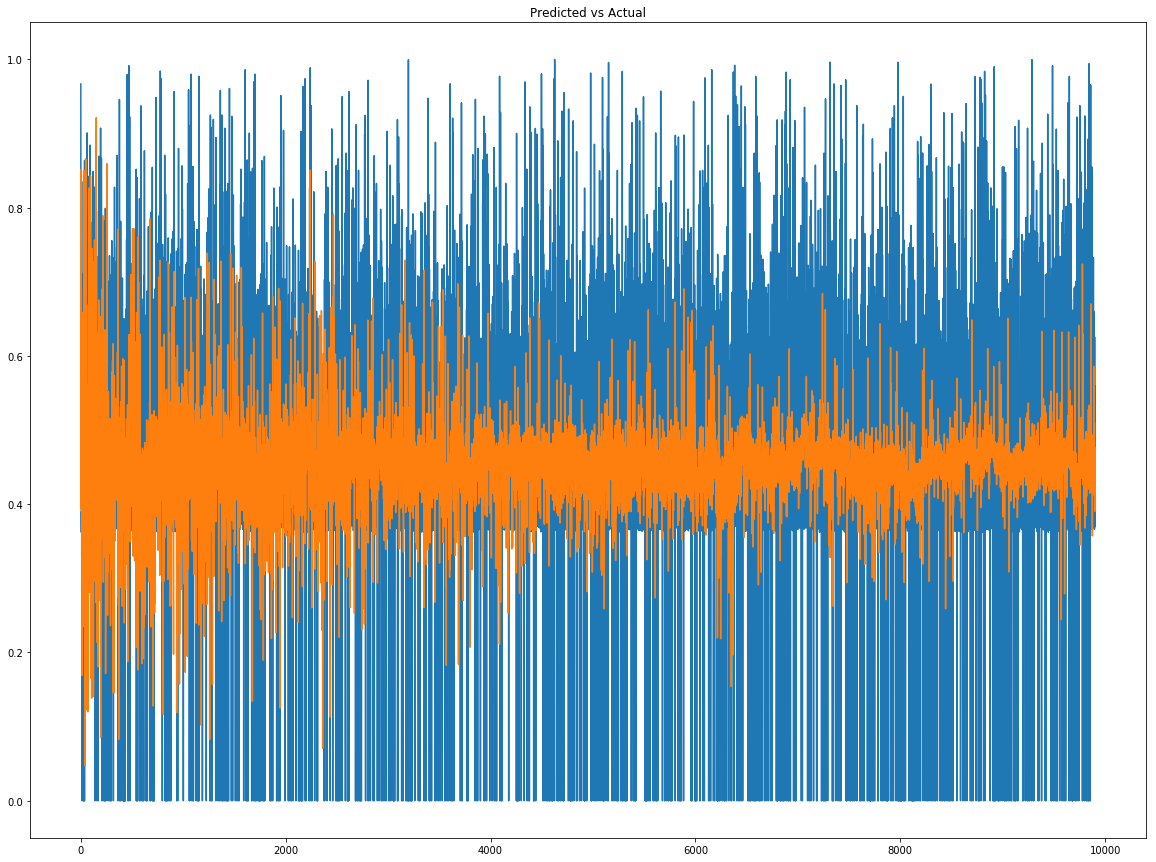

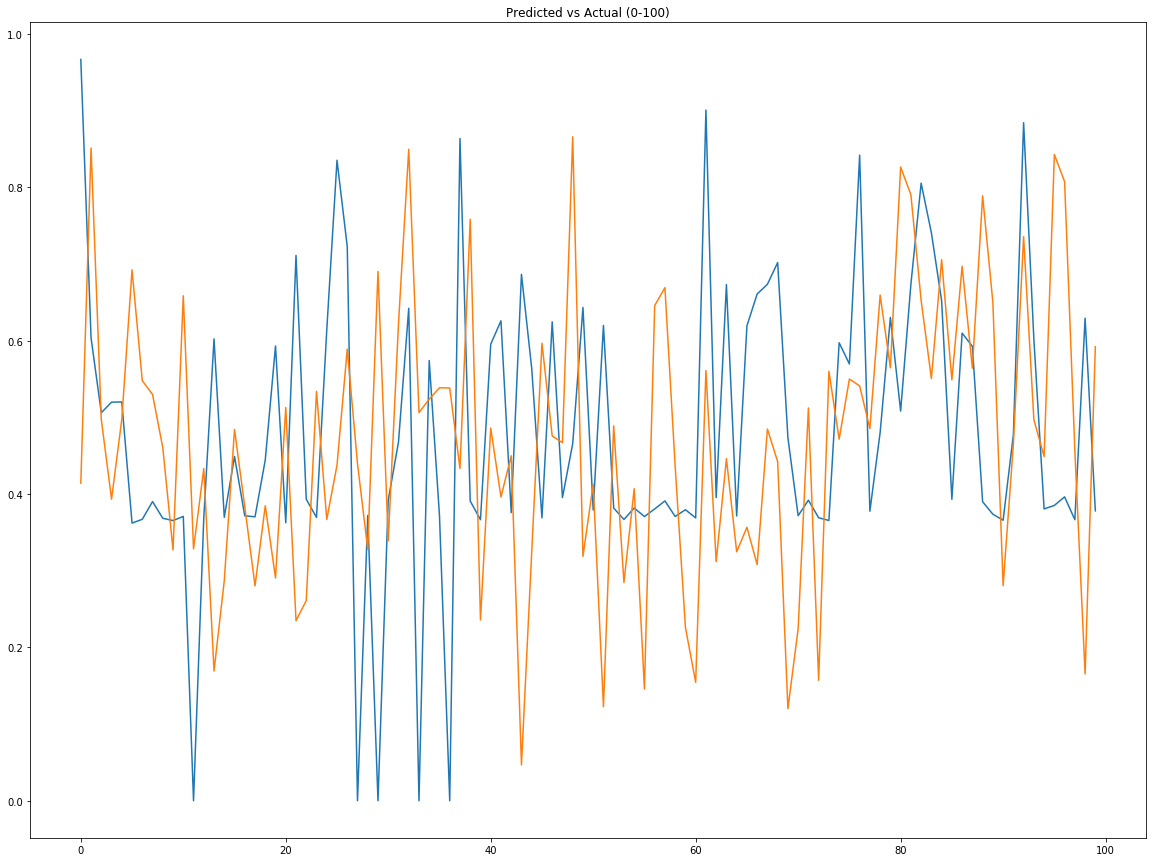

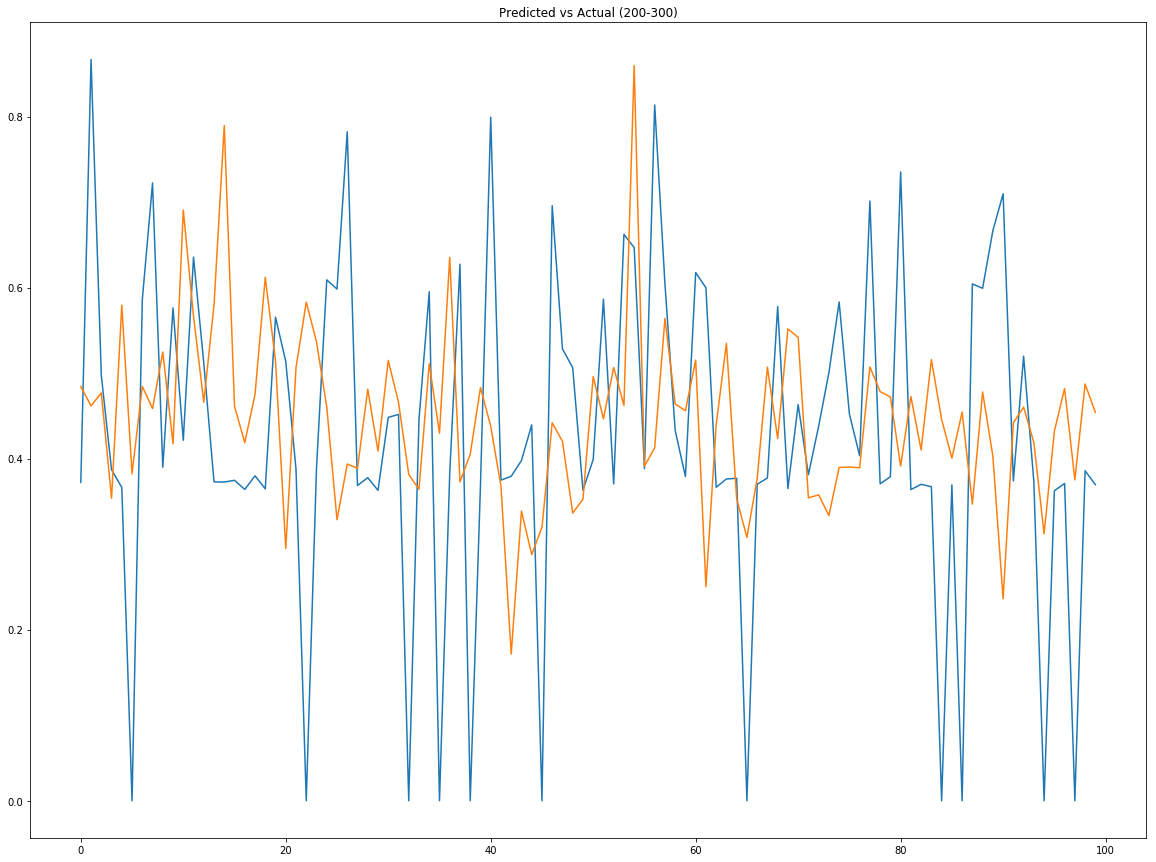

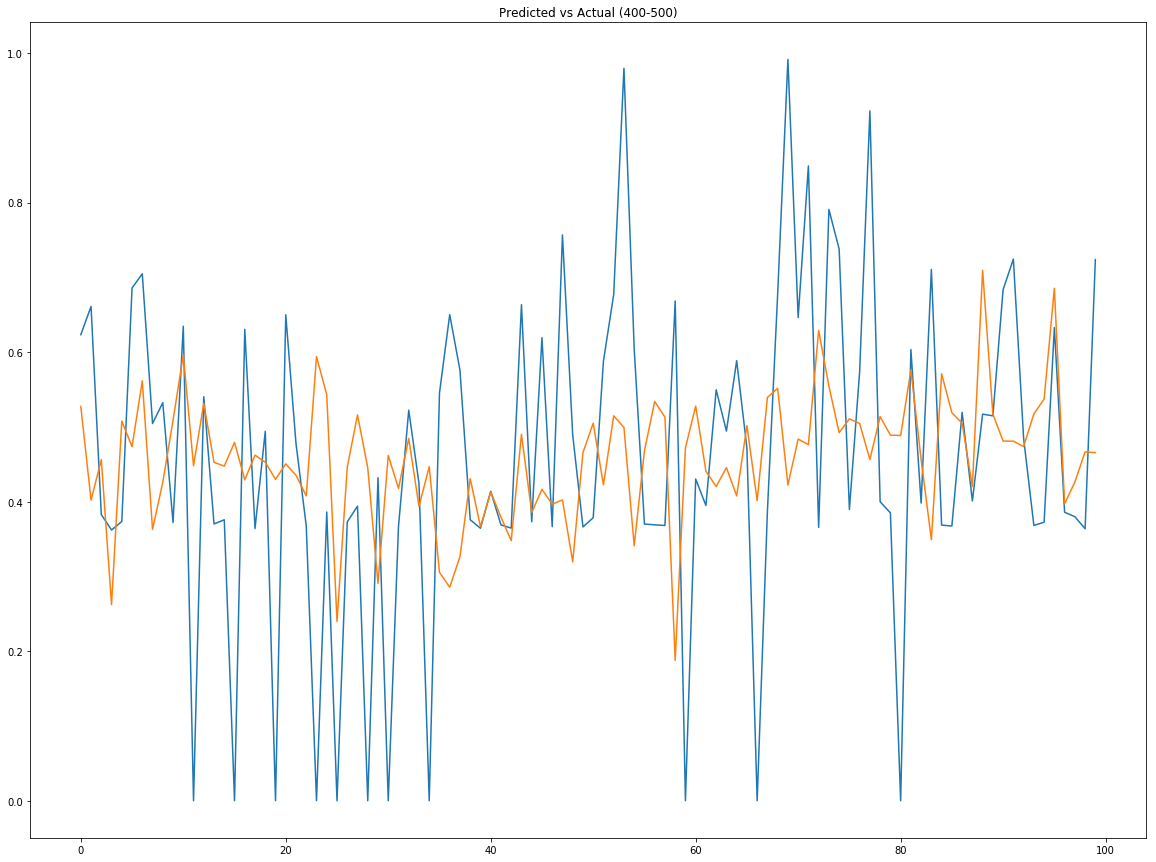

Wall time: 4min 13s


In [25]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
#NEW
y_actual, y_predicted = [],[]
#NEW
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = X_validate_temp[j,:]
        X = X.reshape(1,-1)
        #X = X.reshape((int(X.shape[0] / lag), lag, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        #NEW
        y_actual.append(y[0])
        y_predicted.append(yhat[0])
        #NEW
        
        for z in range(yhat.shape[0]):
            y[z] = BinClass.discretize_value(y[z], io_avg)
            yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(len(y_labels2)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)
    
#NEW
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual, label='y_actual')
plt.plot(y_predicted, label='y_predicted')
plt.title('Predicted vs Actual')
plt.show()

plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[0:100], label='y_actual')
plt.plot(y_predicted[0:100], label='y_predicted')
plt.title('Predicted vs Actual (0-100)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[200:300], label='y_actual')
plt.plot(y_predicted[200:300], label='y_predicted')
plt.title('Predicted vs Actual (200-300)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[400:500], label='y_actual')
plt.plot(y_predicted[400:500], label='y_predicted')
plt.title('Predicted vs Actual (400-500)')
plt.show()
#NEW

## Scoring per day (IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

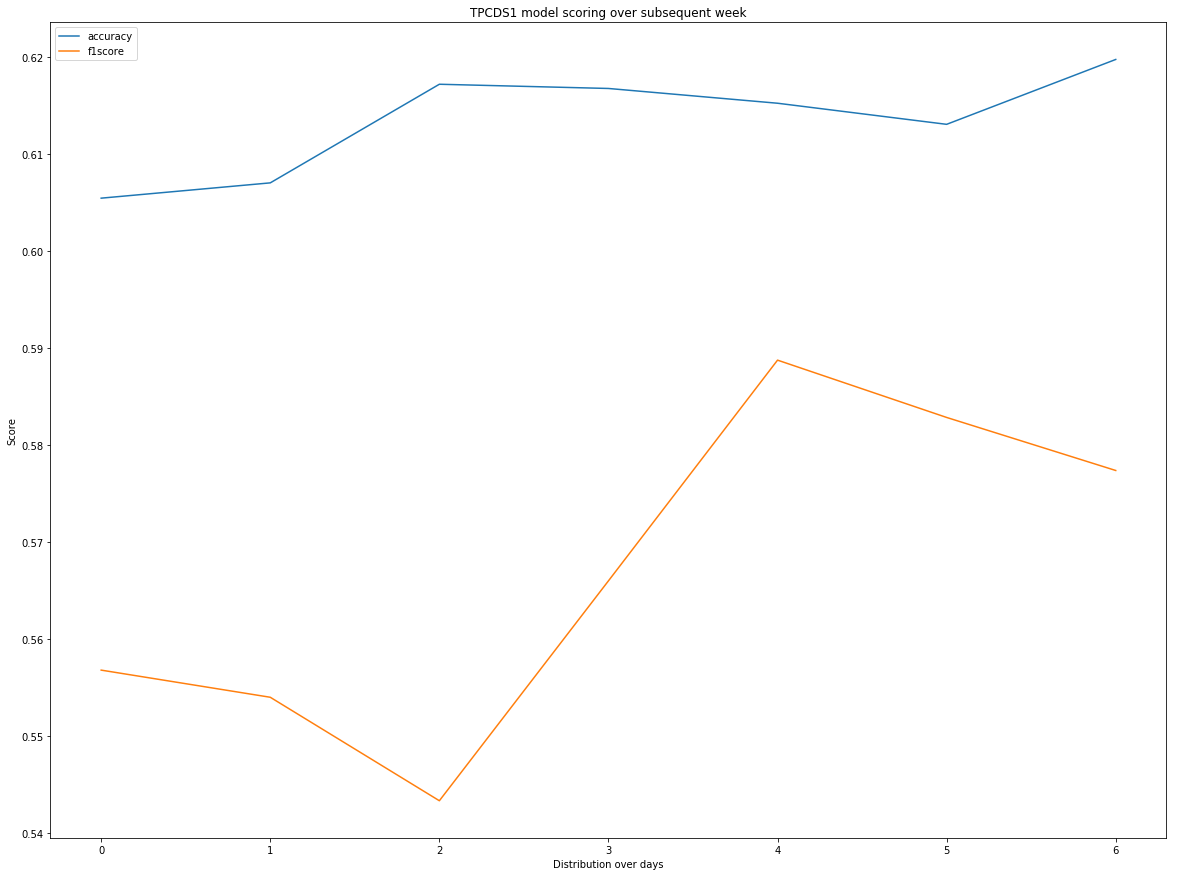

In [26]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

## Neural Net (Feed Foward) Training (Week Prior: Day 1 - 7) (CPU + IO)

A neural net model is trained on a week worth of data. Once the model is fit, it will then be used to establish predictions for upcoming days.

* https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
* https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
* https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
* https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks


Reshaping Training Frames
X_train shape [(9909, 83)] Type - <class 'numpy.ndarray'>
X_validate shape [(9910, 83)] Type - <class 'numpy.ndarray'>
y_train shape [(9909, 26)] Type - <class 'numpy.ndarray'>
y_validate shape [(9910, 26)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 83)                6972      
_________________________________________________________________
dropout_7 (Dropout)          (None, 83)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 83)                6972      
_________________________________________________________________
dropout_8 (Dropout)          (None, 83)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 83)                6972      
_________

 - 4s - loss: 0.0392 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1473 - val_loss: 0.0397 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1488
Epoch 39/600
 - 4s - loss: 0.0392 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1472 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1487
Epoch 40/600
 - 4s - loss: 0.0392 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1471 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1486
Epoch 41/600
 - 4s - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1470 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1485
Epoch 42/600
 - 4s - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1468 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1484
Epoch 43/600
 - 4s - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1467 - val_loss: 0.0396 - val_

Epoch 84/600
 - 4s - loss: 0.0377 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1417 - val_loss: 0.0392 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1455
Epoch 85/600
 - 4s - loss: 0.0377 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1416 - val_loss: 0.0392 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1454
Epoch 86/600
 - 4s - loss: 0.0376 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1415 - val_loss: 0.0392 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1454
Epoch 87/600
 - 4s - loss: 0.0376 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1413 - val_loss: 0.0392 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1453
Epoch 88/600
 - 4s - loss: 0.0375 - mean_squared_error: 0.0375 - mean_absolute_error: 0.1412 - val_loss: 0.0392 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1453
Epoch 89/600
 - 4s - loss: 0.0375 - mean_squared_error: 0.0375 - mean_absolute_error: 0.1411 - val_loss: 

Epoch 130/600
 - 4s - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1371 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1455
Epoch 131/600
 - 4s - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1370 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1455
Epoch 132/600
 - 4s - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1369 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1456
Epoch 133/600
 - 4s - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1369 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1456
Epoch 134/600
 - 4s - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1368 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1456
Epoch 135/600
 - 4s - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1367 - val_

Epoch 176/600
 - 4s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.1329 - val_loss: 0.0419 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1478
Epoch 177/600
 - 4s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.1328 - val_loss: 0.0420 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1479
Epoch 178/600
 - 4s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.1327 - val_loss: 0.0420 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1479
Epoch 179/600
 - 4s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.1326 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1480
Epoch 180/600
 - 4s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.1326 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1480
Epoch 181/600
 - 4s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.1325 - val_

Epoch 222/600
 - 4s - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.1286 - val_loss: 0.0442 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1501
Epoch 223/600
 - 4s - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.1286 - val_loss: 0.0442 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1501
Epoch 224/600
 - 4s - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.1285 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1502
Epoch 225/600
 - 4s - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.1284 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1502
Epoch 226/600
 - 4s - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.1283 - val_loss: 0.0444 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1503
Epoch 227/600
 - 4s - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.1282 - val_

Epoch 268/600
 - 4s - loss: 0.0313 - mean_squared_error: 0.0313 - mean_absolute_error: 0.1249 - val_loss: 0.0464 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1523
Epoch 269/600
 - 4s - loss: 0.0313 - mean_squared_error: 0.0313 - mean_absolute_error: 0.1248 - val_loss: 0.0464 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1523
Epoch 270/600
 - 4s - loss: 0.0312 - mean_squared_error: 0.0312 - mean_absolute_error: 0.1247 - val_loss: 0.0465 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1524
Epoch 271/600
 - 4s - loss: 0.0312 - mean_squared_error: 0.0312 - mean_absolute_error: 0.1246 - val_loss: 0.0465 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1524
Epoch 272/600
 - 4s - loss: 0.0312 - mean_squared_error: 0.0312 - mean_absolute_error: 0.1246 - val_loss: 0.0465 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1524
Epoch 273/600
 - 4s - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_error: 0.1245 - val_

Epoch 314/600
 - 4s - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1217 - val_loss: 0.0484 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1542
Epoch 315/600
 - 4s - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1216 - val_loss: 0.0484 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1542
Epoch 316/600
 - 4s - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1216 - val_loss: 0.0485 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1543
Epoch 317/600
 - 4s - loss: 0.0300 - mean_squared_error: 0.0300 - mean_absolute_error: 0.1215 - val_loss: 0.0485 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1543
Epoch 318/600
 - 4s - loss: 0.0300 - mean_squared_error: 0.0300 - mean_absolute_error: 0.1214 - val_loss: 0.0486 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1543
Epoch 319/600
 - 4s - loss: 0.0300 - mean_squared_error: 0.0300 - mean_absolute_error: 0.1214 - val_

Epoch 360/600
 - 4s - loss: 0.0291 - mean_squared_error: 0.0291 - mean_absolute_error: 0.1191 - val_loss: 0.0503 - val_mean_squared_error: 0.0503 - val_mean_absolute_error: 0.1560
Epoch 361/600
 - 4s - loss: 0.0291 - mean_squared_error: 0.0291 - mean_absolute_error: 0.1190 - val_loss: 0.0503 - val_mean_squared_error: 0.0503 - val_mean_absolute_error: 0.1560
Epoch 362/600
 - 4s - loss: 0.0291 - mean_squared_error: 0.0291 - mean_absolute_error: 0.1190 - val_loss: 0.0504 - val_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.1560
Epoch 363/600
 - 4s - loss: 0.0291 - mean_squared_error: 0.0291 - mean_absolute_error: 0.1189 - val_loss: 0.0504 - val_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.1561
Epoch 364/600
 - 4s - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_error: 0.1189 - val_loss: 0.0504 - val_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.1561
Epoch 365/600
 - 4s - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_error: 0.1188 - val_

Epoch 406/600
 - 4s - loss: 0.0283 - mean_squared_error: 0.0283 - mean_absolute_error: 0.1169 - val_loss: 0.0520 - val_mean_squared_error: 0.0520 - val_mean_absolute_error: 0.1576
Epoch 407/600
 - 4s - loss: 0.0283 - mean_squared_error: 0.0283 - mean_absolute_error: 0.1169 - val_loss: 0.0520 - val_mean_squared_error: 0.0520 - val_mean_absolute_error: 0.1576
Epoch 408/600
 - 4s - loss: 0.0283 - mean_squared_error: 0.0283 - mean_absolute_error: 0.1168 - val_loss: 0.0520 - val_mean_squared_error: 0.0520 - val_mean_absolute_error: 0.1576
Epoch 409/600
 - 4s - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1168 - val_loss: 0.0521 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1577
Epoch 410/600
 - 4s - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1167 - val_loss: 0.0521 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1577
Epoch 411/600
 - 4s - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1167 - val_

Epoch 452/600
 - 4s - loss: 0.0276 - mean_squared_error: 0.0276 - mean_absolute_error: 0.1151 - val_loss: 0.0534 - val_mean_squared_error: 0.0534 - val_mean_absolute_error: 0.1589
Epoch 453/600
 - 4s - loss: 0.0276 - mean_squared_error: 0.0276 - mean_absolute_error: 0.1151 - val_loss: 0.0534 - val_mean_squared_error: 0.0534 - val_mean_absolute_error: 0.1589
Epoch 454/600
 - 4s - loss: 0.0276 - mean_squared_error: 0.0276 - mean_absolute_error: 0.1150 - val_loss: 0.0534 - val_mean_squared_error: 0.0534 - val_mean_absolute_error: 0.1589
Epoch 455/600
 - 4s - loss: 0.0276 - mean_squared_error: 0.0276 - mean_absolute_error: 0.1150 - val_loss: 0.0535 - val_mean_squared_error: 0.0535 - val_mean_absolute_error: 0.1589
Epoch 456/600
 - 4s - loss: 0.0275 - mean_squared_error: 0.0275 - mean_absolute_error: 0.1150 - val_loss: 0.0535 - val_mean_squared_error: 0.0535 - val_mean_absolute_error: 0.1590
Epoch 457/600
 - 4s - loss: 0.0275 - mean_squared_error: 0.0275 - mean_absolute_error: 0.1149 - val_

Epoch 498/600
 - 4s - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1136 - val_loss: 0.0546 - val_mean_squared_error: 0.0546 - val_mean_absolute_error: 0.1600
Epoch 499/600
 - 4s - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1136 - val_loss: 0.0547 - val_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.1600
Epoch 500/600
 - 4s - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1136 - val_loss: 0.0547 - val_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.1600
Epoch 501/600
 - 4s - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1136 - val_loss: 0.0547 - val_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.1601
Epoch 502/600
 - 4s - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1135 - val_loss: 0.0547 - val_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.1601
Epoch 503/600
 - 4s - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1135 - val_

Epoch 544/600
 - 4s - loss: 0.0266 - mean_squared_error: 0.0266 - mean_absolute_error: 0.1124 - val_loss: 0.0558 - val_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.1610
Epoch 545/600
 - 4s - loss: 0.0266 - mean_squared_error: 0.0266 - mean_absolute_error: 0.1124 - val_loss: 0.0558 - val_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.1610
Epoch 546/600
 - 4s - loss: 0.0266 - mean_squared_error: 0.0266 - mean_absolute_error: 0.1124 - val_loss: 0.0558 - val_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.1610
Epoch 547/600
 - 4s - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1123 - val_loss: 0.0558 - val_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.1611
Epoch 548/600
 - 4s - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1123 - val_loss: 0.0558 - val_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.1611
Epoch 549/600
 - 4s - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1123 - val_

Epoch 590/600
 - 4s - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_error: 0.1114 - val_loss: 0.0567 - val_mean_squared_error: 0.0567 - val_mean_absolute_error: 0.1619
Epoch 591/600
 - 4s - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_error: 0.1113 - val_loss: 0.0567 - val_mean_squared_error: 0.0567 - val_mean_absolute_error: 0.1619
Epoch 592/600
 - 4s - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_error: 0.1113 - val_loss: 0.0568 - val_mean_squared_error: 0.0568 - val_mean_absolute_error: 0.1619
Epoch 593/600
 - 4s - loss: 0.0261 - mean_squared_error: 0.0261 - mean_absolute_error: 0.1113 - val_loss: 0.0568 - val_mean_squared_error: 0.0568 - val_mean_absolute_error: 0.1619
Epoch 594/600
 - 4s - loss: 0.0261 - mean_squared_error: 0.0261 - mean_absolute_error: 0.1113 - val_loss: 0.0568 - val_mean_squared_error: 0.0568 - val_mean_absolute_error: 0.1619
Epoch 595/600
 - 4s - loss: 0.0261 - mean_squared_error: 0.0261 - mean_absolute_error: 0.1112 - val_

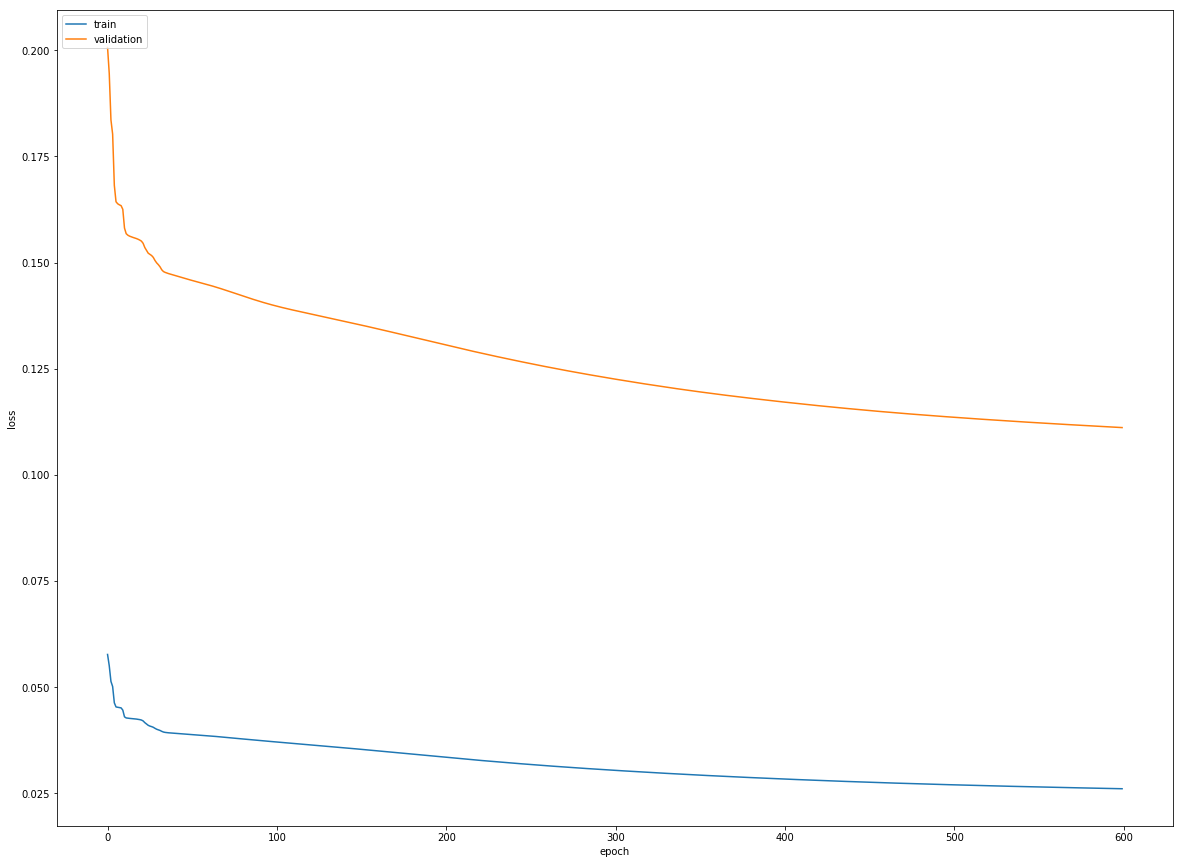

Wall time: 38min 42s


In [27]:
%%time

X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = NeuralNet(X=X_train,
                  y=y_train,
                  lag=lag,
                  loss_func='mean_squared_error',
                  activation=activation,
                  optimizer='adam',
                  layers=layer,
                  dropout=dropout,
                  y_labels=y_label,
                  initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

## Neural Net (Feed Foward) Validation: Day 8 - 14 (CPU + IO)

Evaluating model fit to day 1 forecasts. 

In [28]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = X_validate_temp[j,:]
        X = X.reshape(1,-1)
        #X = X.reshape((int(X.shape[0] / lag), lag, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for z in range(yhat.shape[0]):
            if z % 2 == 0:
                #print('CPU')
                y[z] = BinClass.discretize_value(y[z], cpu_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
            else:
                #print('IO')
                y[z] = BinClass.discretize_value(y[z], io_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(lag * len(y_label)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (1415, 83)
Label vectors: (1415, 26)
Label: 0
Accuracy: 0.5187279151943462
F1Score: 0.3029682702149437
--------------------------
Label: 1
Accuracy: 0.48480565371024736
F1Score: 0.45556385362210605
--------------------------
Label: 2
Accuracy: 0.49187279151943464
F1Score: 0.43162055335968375
--------------------------
Label: 3
Accuracy: 0.5137809187279152
F1Score: 0.4715821812596006
--------------------------
Label: 4
Accuracy: 0.4925795053003534
F1Score: 0.4143556280587276
--------------------------
Label: 5
Accuracy: 0.4911660777385159
F1Score: 0.49930458970792774
--------------------------
Label: 6
Accuracy: 0.4989399293286219
F1Score: 0.37970253718285213
--------------------------
Label: 7
Accuracy: 0.5399293286219081
F1Score: 0.457047539616347
--------------------------
Label: 8
Accuracy: 0.49469964664310956
F1Score: 0.4076222038111019
--------------------------
Label: 9
Accuracy: 0.4925795053003534
F1Score: 0.4519083969465649
--------------------------
Labe

Label: 0
Accuracy: 0.49328621908127207
F1Score: 0.37270341207349084
--------------------------
Label: 1
Accuracy: 0.4925795053003534
F1Score: 0.4172077922077922
--------------------------
Label: 2
Accuracy: 0.5024734982332155
F1Score: 0.4517133956386292
--------------------------
Label: 3
Accuracy: 0.49187279151943464
F1Score: 0.5058419243986254
--------------------------
Label: 4
Accuracy: 0.5159010600706714
F1Score: 0.4380639868744873
--------------------------
Label: 5
Accuracy: 0.4664310954063604
F1Score: 0.4267274107820805
--------------------------
Label: 6
Accuracy: 0.5215547703180212
F1Score: 0.44644317252657395
--------------------------
Label: 7
Accuracy: 0.5151943462897527
F1Score: 0.39824561403508774
--------------------------
Label: 8
Accuracy: 0.49187279151943464
F1Score: 0.4732600732600732
--------------------------
Label: 9
Accuracy: 0.5420494699646643
F1Score: 0.438474870017331
--------------------------
Label: 10
Accuracy: 0.4989399293286219
F1Score: 0.450813323005422

## Scoring per day (CPU + IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

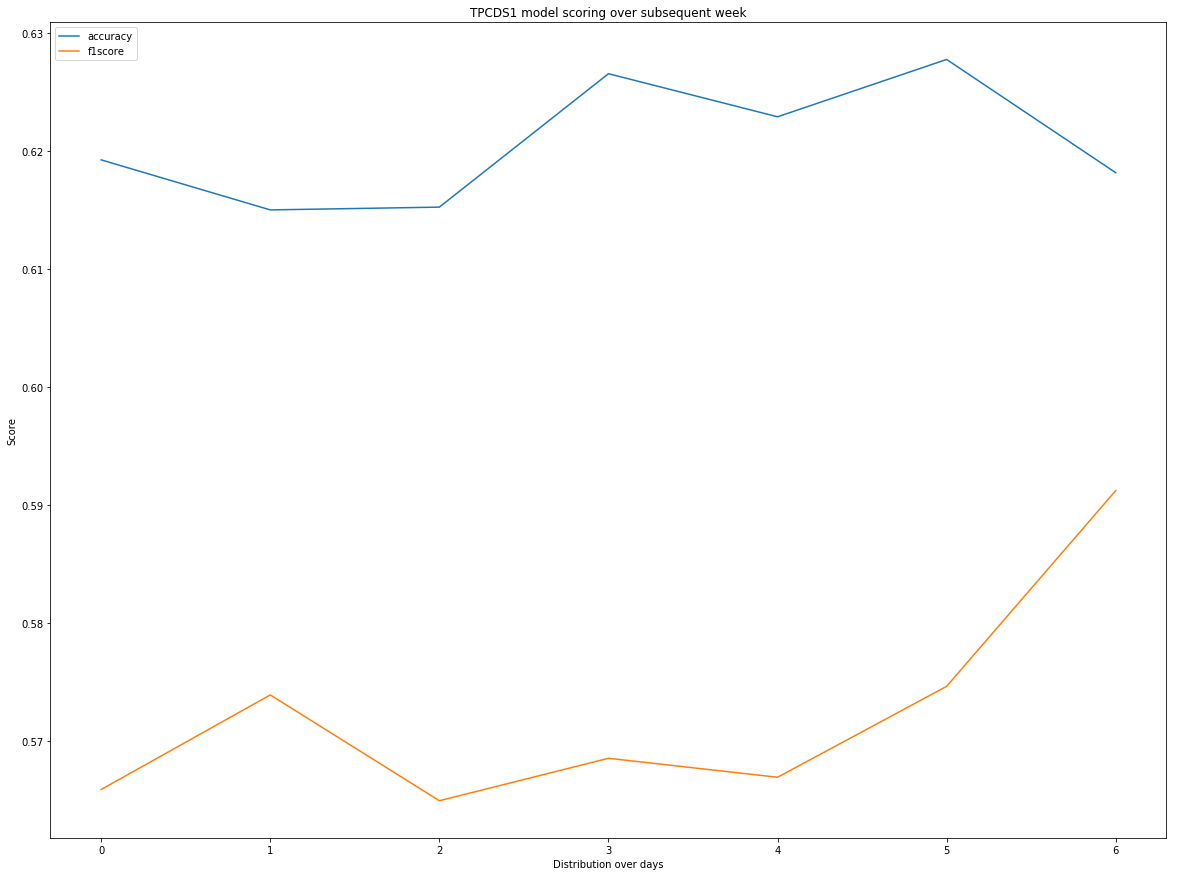

In [29]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()